***
# Quality control of astrometric solutions
***

<div class="alert alert-block alert-info"> This Jupyter Notebook serves as additional guideline for Chapter 5 in my Master Thesis. All code used to analyse data and produce plots is presented here 

</div>

<font color="#31688e">   <i> In this chapter we do a first assessment of the quality of the astrometric calibration for a set of repeat
observations of one target. The purpose is to get familiar with astrometry, the use of astrometry software,
bringing the theory of previous chapters into practice. Chapter 3 describes the importance of physical eects
originating from atmosphere, optics and detectors in the process of converting pixel positions on a detector
to positions on the sky. This conversion is done by applying astrometric solutions and determining astrometry.
Chapter 4 described how these physical effects can be represented by software and used in information
systems to apply calibration and do a quality control. The AstroWISE information system is taken as an example.
It uses an astrometric model in its calibration pipeline to derive astrometric solutions and astrometry.
AstroWISE stores the solutions in an $\texttt{AstrometricParameters}$ object and the corresponding catalogue with
calibrated source positions $\texttt{(RA}$, $\texttt{DEC)}$ in a $\texttt{SourceList}$. For each calibration to a different reference catalogue,
at least one new combination of an $\texttt{AstrometricParameters}$ and $\texttt{SourceList}$ object is created. </i>   </font>
<a id = "LOC" LOC></a>


<div class="alert alert-block alert-info">
<b>  List of content of Chapter 5</b> <br>
<i> Figure and Table numbers refer to the numbers in the thesis </i>
    <br> <br>

[5.1](#5.1) <b>Cross-matching based on astrometry</b> . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . [Figure 5.1](#f5.1)<br>
<br>
[5.2](#5.2) <b>How to use AssociateList's in AstroWISE</b> . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . <br>
[5.2.1](#5.2.1) Creating an AssociateList from multiple SourceLists . . . . . . . . . . . . . . . . . . . . . . . <br>
[5.2.2](#5.2.2) Obtaining data from AssociateList . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .   <br>
<br>
[5.3](#5.3) <b>Cross-matching DetectorImages from OmegaCAM Selected Area, field 113</b> . .  <br>
[5.3.1](#5.3.1) Comparing Instrumental and Calibrated AstrometricSolutions . . . . . . . . . . . . . . . . <br>
<br>
[5.4](#5.4) <b>Criteria to Define the Quality of Associations</b>. . . . . . . . . . . . . . . . . . . . . . . . . . . . . [Figure 5.4](#fthesis)     [Figure 5.5](#fthesis)  [Figure 5.6](#fthesis) <br>



</div>


In [1]:
from __future__ import print_function

import warnings
warnings.filterwarnings("ignore")
%run py/setup_awe

try:
    context.set_project('OMEGACAM@VST')
    context.set_privileges(3)
    radec_SA113=[325.375,0.499]
    ra_SA113,dec_SA113,dra_SA113,ddec_SA113=radec_SA113[0],radec_SA113[1],1.,1.
    radec_SA107=[234.825,-0.263] 
    ra_SA107,dec_SA107,dra_SA107,ddec_SA107=radec_SA107[0],radec_SA107[1],1.,1.
except NameError as err:
    print("NameError: Module Context not imported, go to AW environment")
    pass

ImportError: Module Context not imported, go to AW environment
NameError: Module Context not imported, go to AW environment


In [3]:

import pickle
import datetime
import numpy as np
try: 
    import pandas as pd
    from pandas.plotting import register_matplotlib_converters
    register_matplotlib_converters()
except ImportError as err:
    print("ImportError: Python pandas module not imported, not available in Astro-WISE environment")
    import sqlite3
    pass

import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.cm as cmx
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
from matplotlib.ticker import FixedLocator, FixedFormatter

import matplotlib.dates as dates

import sys
import os

sys.path.insert(1,"../../pythonscripts/")

from Astrom import AstromAW

import pixel2radec as p2rd
import select_from_awedb as slct
import plotutils_awe as pltut


def _to_hex(c):
    """Convert arbitray color specification to hex string.
    
    Usage: 
        color = _to_hex((0.267004, 0.004874, 0.329415)) 
    Returns:
        HEX colors in the form of #440154
    
    """
    ctype = type(c)

    # Convert rgb to hex.
    if ctype is tuple or ctype is np.ndarray or ctype is list:
        return colors.rgb2hex(c)
    if ctype is str:
        # If color is already hex, simply return it.
        regex = re.compile('^#[A-Fa-f0-9]{6}$')
        if regex.match(c):
            return c
        # Convert named color to hex.
        return colors.cnames[c]
    raise Exception("Can't handle color of type: {}".format(ctype))

# Obtaining colors for scatter plot
purple = _to_hex((0.267004, 0.004874, 0.329415))
blue_purple = _to_hex((0.267968, 0.223549, 0.512008))
blue = _to_hex((0.190631, 0.407061, 0.556089))
green_blue = _to_hex((0.128729, 0.563265, 0.551229))
green_blue2 = _to_hex((0.288921, 0.758394, 0.428426))
green = _to_hex((0.20803, 0.718701, 0.472873))
yellow_green = _to_hex((0.555484, 0.840254, 0.269281))
yellow = _to_hex((0.993248, 0.906157, 0.143936)) 

# print(purple, blue_purple, blue, green_blue, green_blue2, green, yellow_green, yellow)

# Obtaining colors for exclusion zones
silver = _to_hex((0.93, 0.93, 0.93))
grey_blue = _to_hex((0.36, 0.48, 0.58))  
hist_purple = '#7F7FFF'  # the color used for all histograms, taking into acount its alpha
cum_red = '#FD0306' #the color used for all cumulative histogram plots

#print(silver, grey_blue)

In [2]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script> <i>
The code used to load the data, plot the Figures & Tables and analyse the results is hidden by default.
To show the raw code, click  <a href="javascript:code_toggle()">here</a> </i>.''') 


<br><br>
[Go back to list of contents](#LOC)

<a id = "5.1" CM></a>
***
# Cross-matching based on astrometry
***
<i> In astronomical context cross-matching is often referred to as the identification of different objects that refer to the same object. These can be present in either a single or multiple catalogues. For this project we will focus on the cross-matching of <b>one main Master catalogue together with multiple astrometrical sourcelists</b> which by themselves can be seen as small catalogues. </i>

Cross-matching astronomical catalogues is a scientifically and technologically complex problem. For small patches of the sky it can be done quiet easily, even by the human eye. However matching large surveys including several millions or billions of sources becomes difficult as identifications "by eye" are not longer possible. Therefore, for the larges catalogues the process of cross-matching and statistically validating of the associations must be automated.

The basic procedure of astronomical cross-matching is spatially joining catalogues spatially based on the sources' equatorial coordinates. Two sources that are less than the specified distance apart from each other form a pair. This pair can be seen as two matches: S1 matches S2 and S2 matches S1.  
Traditionally there have been multiple approaches used to perform these spatial joins. With the ever largely growing catalogues, another basic question arises: how can we organise data in an optimal and efficient way to enable quick searches and joins. Hierarchical Equal Area isoLatitude Pixelization of a sphere, [HEALPix](http://ascl.net/1107.018), and Hierarchical Triangular Mesh, [HTM](https://www.researchgate.net/publication/226072008_The_Hierarchical_Triangular_Mesh), are two of the most commonly used indexing schemes. Especially relational databases that dealing with several coordinate systems, spatial indexes are of great importance. 

<a id = "CM0" CM></a>
## Case-study: the basic principle of cross-matching

As just mentioned, the basic procedure of astronomical cross-matching is spatially joining catalogues spatially based on the sources' equatorial coordinates. The principle of cross-matching is illustrated in Figure 1.  


In [42]:
def get_SourceList_data(slid, attrlist = None, SA_radec=[325.375 ,0.499]):
    ''' Obtaining numpy array or list containing all values for the attribute in a single SourceLists made using
    SourceLists in the Astro-WISE database

    (1) Selecting SourceList by SLID, from Astro-WISE Database
    (2) Obtaining requested attributes from AssociateList, as defined by attrlist
    (3) Per attribute append values to data list
    (4) Obtain specific information for SourceLists regarding its detection frame: observation time, filter

        Parameters
        ----------
        attrlist : list [Default = ['MU_MAX', 'Xpos', 'MAGERR_APER', 'FLUXERR_APER', 'Ypos', 'FLUXERR_AUTO', 'MAG_ISO',
                                  'ERRA_IMAGE', 'XM2', 'RA', 'POSANG', 'SLID', 'ERRX2_IMAGE', 'ERRY2_IMAGE', 'Flag',
                                  'FLUX_AUTO', 'Level', 'SID', 'HTM', 'FWHM_IMAGE', 'FIELD_POS', 'ERRTHETA_IMAGE',
                                  'YM2', 'FLAG', 'BackGr', 'A', 'MAGERR_ISO', 'Corr', 'FLUX_RADIUS', 'DEC', 'MaxVal',
                                  'ERRB_IMAGE', 'FLUX_ISO', 'CLASS_STAR', 'MAG_APER', 'ERRXY_IMAGE', 'SeqNr', 'FLUX_APER',
                                  'NPIX', 'FLUXERR_ISO', 'B']
            List containing wanted attributes as str

        slid : int [Default = 76132781]
            SourceList Identifier number

        SA_radec : list [Default = [325.375,0.499]]
            List containing pointing of SA113 field in RA and DEC [first SA when this function was created]

        Returns
        -------
        data_float : list
            List containing [attrlist] ordered by Sources in AW-SourceList. All values are stored as floats

        slid_id : list
            List containing SourceList Identifier number

        obs_date : list
            List containing ObservationDate


    ------------------------------- User example --------------------------------
    ###### Using get_SourceList_data() to obtain SourceList data from AW-SoruceList #######

        data, slid_ids, obs_date = get_SourceList_data()

    '''
    # (1) Selecting AssociateList by ALID, from Astro-WISE Database
    try:
        SL = (SourceList.SLID == slid)
    except NameError as err:
        try:
            with open('data/SA113_SL{}.data'.format(slid), 'rb') as filehandle:
                # open the file 'SA113_2692091.data' as binary data stream
                attrlist, data, slid_id, obs_date = pickle.load(filehandle)
            return data, slid_id, obs_date, attrlist
        except ModuleNotFoundError as err:
            nprint("ModuleNotFoundError: module pickle not found. --> import pickle" )
            return None
    if attrlist == None:
        attrlist=['MU_MAX', 'Xpos', 'MAGERR_APER', 'FLUXERR_APER', 'Ypos', 'FLUXERR_AUTO', 'MAG_ISO',
                                  'ERRA_IMAGE', 'XM2', 'RA', 'POSANG', 'SLID', 'ERRX2_IMAGE', 'ERRY2_IMAGE', 'Flag',
                                  'FLUX_AUTO', 'Level', 'SID', 'HTM', 'FWHM_IMAGE', 'FIELD_POS', 'ERRTHETA_IMAGE',
                                  'YM2', 'FLAG', 'BackGr', 'A', 'MAGERR_ISO', 'Corr', 'FLUX_RADIUS', 'DEC', 'MaxVal',
                                  'ERRB_IMAGE', 'FLUX_ISO', 'CLASS_STAR', 'MAG_APER', 'ERRXY_IMAGE', 'SeqNr', 'FLUX_APER',
                                  'NPIX', 'FLUXERR_ISO', 'B']
    else: 
        pass
    sl_data_floats = SL[0].sources
        
    data_float = []

    for source in sl_data_floats:
        source_float = []
        for att in attrlist:
            if type(source[att]) == float or type(source[att]) == int:
                source_nptype = source[att]  
            else:
                source_nptype = float(np.array(source[att]).astype(np.float64))
            source_float.append(source_nptype)
        # (3) Per source append attributes to data list
        data_float.append(source_float)
    # (4) Obtain information for SourceLists in AssociateList
    obs_date = SL[0].frame.DATE_OBS
    slid_id = slid
    saveObject = (attrlist, data_float, slid_id, obs_date)
    SAfield = 'SA113'
    with open('data/{}_SL{}.data'.format(SAfield, slid), 'wb') as filehandle:
        # store the data as binary data stream
        pickle.dump(saveObject, filehandle)
    print("{}_SL{}.data is saved and stored".format(SAfield, slid))
    return data_float, slid_id, obs_date, attrlist

attrlist_in = ['MU_MAX', 'Xpos', 'MAGERR_APER', 'FLUXERR_APER', 'Ypos', 'FLUXERR_AUTO', 'MAG_ISO',
                                  'ERRA_IMAGE', 'XM2', 'RA', 'POSANG', 'SLID', 'Flag',
                                  'FLUX_AUTO', 'Level', 'SID', 'HTM', 'FWHM_IMAGE', 'FIELD_POS', 'ERRTHETA_IMAGE',
                                  'YM2', 'FLAG', 'BackGr', 'A', 'MAGERR_ISO', 'Corr', 'FLUX_RADIUS', 'DEC', 'MaxVal',
                                  'ERRB_IMAGE', 'FLUX_ISO', 'CLASS_STAR', 'MAG_APER', 'SeqNr', 'FLUX_APER',
                                  'NPIX', 'FLUXERR_ISO', 'B']


def intitialize_PandasTable_from_SL(SLID, save = 'on'):
    data, slid_id, obs_date, attrlist = get_SourceList_data(slid=SLID)
    
    df_raw = pd.DataFrame({'SLID': pd.Series([], dtype='int'), 'SID': pd.Series([], dtype='int'), 'RA': pd.Series([], dtype='float'), 'DEC': pd.Series([], dtype='float'), 'Xpos': pd.Series([], dtype='float'), 'Ypos': pd.Series([], dtype='float'), 'MAG_ISO': pd.Series([], dtype='float'), 'FLUX_APER': pd.Series([], dtype='float'), 'FLUXERR_APER': pd.Series([], dtype='float'),  'S2N': pd.Series([], dtype='float'), 'ERRX2_IMAGE': pd.Series([], dtype='float'), 'ERRY2_IMAGE': pd.Series([], dtype='float'), 'ERRXY_IMAGE': pd.Series([], dtype='float')  })
    df_stats = pd.DataFrame({'SLID': pd.Series([], dtype='int'), 'RA_MEAN': pd.Series([], dtype='float'), 'RA_RES': pd.Series([], dtype='float'), 'DEC_MEAN': pd.Series([], dtype='float'), 'DEC_RES': pd.Series([], dtype='float'), 'MAG_MEAN': pd.Series([], dtype='float'), 'FLUX_MEAN': pd.Series([], dtype='float'),  'FLUXERR_MEAN': pd.Series([], dtype='float'), 'S2N_MEAN': pd.Series([], dtype='float') })
    
    idx_ra = attrlist.index("RA"); idx_dec =  attrlist.index("DEC"); idx_xpos = attrlist.index("Xpos"); idx_ypos =  attrlist.index("Ypos")
    idx_mag = attrlist.index("MAG_ISO"); idx_flux = attrlist.index("FLUX_APER"); idx_fluxerr = attrlist.index("FLUXERR_APER")
    idx_errx2 = attrlist.index("ERRX2_IMAGE"); idx_erry2 = attrlist.index("ERRY2_IMAGE"); idx_errxy = attrlist.index("ERRXY_IMAGE")
    nr_sources = len(data)
    # Obtaining information/statistics per attribute
    RA = [data[i][idx_ra] for i in range(nr_sources)]
    DEC = [data[i][idx_dec] for i in range(nr_sources)] 
    XPOS = [data[i][idx_xpos] for i in range(nr_sources)]
    YPOS = [data[i][idx_ypos] for i in range(nr_sources)]
    ISO = [data[i][idx_mag] for i in range(nr_sources)]
    FLUX = [data[i][idx_flux] for i in range(nr_sources)]
    FLUXERR = [data[i][idx_fluxerr] for i in range(nr_sources)]
    ERRX2 = [data[i][idx_errx2] for i in range(nr_sources)]
    ERRY2 = [data[i][idx_erry2] for i in range(nr_sources)]
    ERRXY = [data[i][idx_errxy] for i in range(nr_sources)]
    RA_MEAN, DEC_MEAN, ISO_MEAN = np.mean(RA), np.mean(DEC), np.mean(ISO),
    FLUX_ISOMEAN, FLUXERR_ISOMEAN, S2N_MEAN = np.mean(FLUX), np.mean(FLUXERR), (np.mean(FLUX)/np.mean(FLUXERR))
    RA_RES, DEC_RES = [], []
    for idx_source in range(nr_sources):
        # Obtaining information/statistics per source in single associates
        sid = idx_source
        ra = RA[idx_source]
        dec = DEC[idx_source]
        xpos = XPOS[idx_source]
        ypos = YPOS[idx_source]
        mag_iso = ISO[idx_source]
        flux_aper = FLUX[idx_source]
        fluxerr_aper = FLUXERR[idx_source]
        s2n = FLUX[idx_source]/FLUXERR[idx_source]
        errx2 = ERRX2[idx_source]
        erry2 = ERRY2[idx_source]
        errxy = ERRXY[idx_source]
        row_raw = [{'SLID': SLID, 'SID': sid,'RA': ra, 'DEC': dec, 'Xpos': xpos, 'Ypos': ypos, 'MAG_ISO': mag_iso, 'FLUX_APER': flux_aper, 'FLUXERR_APER': fluxerr_aper, 'S2N': s2n, 'ERRX2_IMAGE': errx2, 'ERRY2_IMAGE': erry2, 'ERRXY_IMAGE': errxy }]
        df_raw = df_raw.append(row_raw, ignore_index=False, sort=False)
        RA_RES.append(ra - RA_MEAN) ; DEC_RES.append(dec - DEC_MEAN)
        print("{}/{}".format(idx_source + 1, nr_sources), end='\r')
    sl_stats = [{'SLID': SLID, 'RA_MEAN': np.mean(RA_MEAN), 'RA_RES': np.mean(RA_RES),  'DEC_MEAN': DEC_MEAN, 'DEC_RES': np.mean(DEC_RES), 'MAG_MEAN': ISO_MEAN, 'FLUX_MEAN': FLUX_ISOMEAN,  'FLUXERR_MEAN': FLUXERR_ISOMEAN, 'S2N_MEAN': S2N_MEAN }]
    df_stats = df_stats.append(sl_stats, ignore_index=False, sort=False)
#     print("PandasTable from Sourcelist SLID={} has been created".format(SLID))
    
    if save == 'on':
        df_raw.to_csv('data/sl{}raw.csv'.format(SLID))
        df_stats.to_csv('data/sl{}stats.csv'.format(SLID))
        print("Tables stored as data/sl{}raw.csv, and data/sl{}stats.csv".format(SLID, SLID))
    else:
        pass
    return df_stats, df_raw, obs_date


<a id = "f5.1" LOC></a>

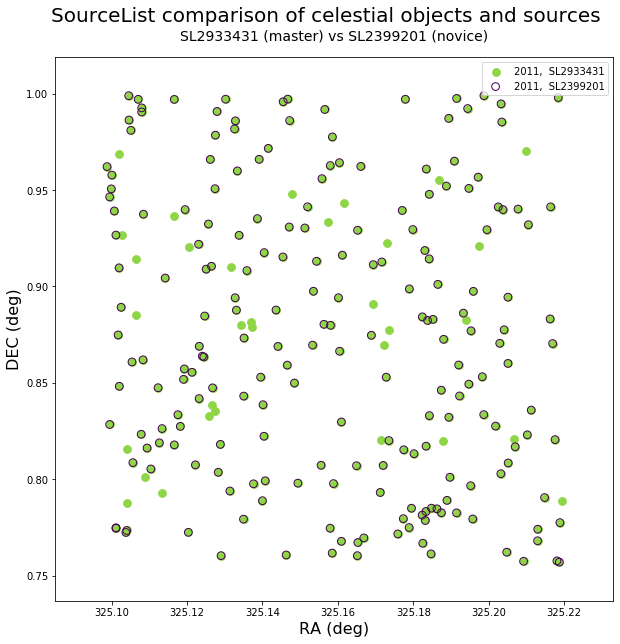

In [40]:
def get_SourceList_data_forplotting(slid, attrlist = None, SA_radec=[325.375 ,0.499]):
    ''' Obtaining numpy array or list containing all values for the attribute in a single SourceLists made using
    SourceLists in the Astro-WISE database --- THIS VERSION IS INTEDED FOR DIRECT PLOTTING IN JUPYTER NOTEBOOK 

    (1) Selecting SourceList by SLID, from Astro-WISE Database
    (2) Obtaining requested attributes from AssociateList, as defined by attrlist
    (3) Per attribute append values to data list
    (4) Obtain specific information for SourceLists regarding its detection frame: observation time, filter

        Parameters
        ----------
        attrlist : list [Default = ['Xpos', 'Ypos', 'RA', 'SLID', 'SID', 'DEC']]
            List containing wanted attributes as str

        slid : int 
            SourceList Identifier number

        SA_radec : list [Default = [325.375,0.499]]
            List containing pointing of SA113 field in RA and DEC [first SA when this function was created]

        Returns
        -------
        data_float : list
            List containing [attrlist] ordered by Sources in AW-SourceList. All values are stored as floats

        slid_id : list
            List containing SourceList Identifier number

        obs_date : list
            List containing ObservationDate
            
        RA : list
        
        DEC : list

    ------------------------------- User example --------------------------------
    ###### Using get_SourceList_data() to obtain SourceList data from AW-SoruceList #######

        data, slid_ids, obs_date = get_SourceList_data()

    '''
    # (1) Selecting AssociateList by ALID, from Astro-WISE Database
    try:
        SL = (SourceList.SLID == slid)
    except NameError as err:
        try:
            with open('data/SA113_SL{}.data'.format(slid), 'rb') as filehandle:
                # open the file 'SA113_2692091.data' as binary data stream
                attrlist, data, slid_id, obs_date = pickle.load(filehandle)
                
                idx_ra = attrlist.index("RA"); idx_dec =  attrlist.index("DEC"); idx_xpos = attrlist.index("Xpos"); idx_ypos =  attrlist.index("Ypos")
                nr_sources = len(data)
                # Obtaining information/statistics per attribute
                RA = [data[i][idx_ra] for i in range(nr_sources)]
                DEC = [data[i][idx_dec] for i in range(nr_sources)] 
                XPOS = [data[i][idx_xpos] for i in range(nr_sources)]
                YPOS = [data[i][idx_ypos] for i in range(nr_sources)]
            return RA, DEC, obs_date
        except ModuleNotFoundError as err:
            print("ModuleNotFoundError: module pickle not found. --> import pickle" )
            return None
    if attrlist == None:
        attrlist=['Xpos', 'Ypos', 'RA', 'SLID', 'SID', 'DEC']
    else: 
        pass
    sl_data_floats = SL[0].sources
        
    data_float = []

    for source in sl_data_floats:
        source_float = []
        for att in attrlist:
            if type(source[att]) == float or type(source[att]) == int:
                source_nptype = source[att]  
            else:
                source_nptype = float(np.array(source[att]).astype(np.float64))
            source_float.append(source_nptype)
        # (3) Per source append attributes to data list
        data_float.append(source_float)
    # (4) Obtain information for SourceLists in AssociateList
    obs_date = SL[0].frame.DATE_OBS
    slid_id = slid
    saveObject = (attrlist, data_float, slid_id, obs_date)
    SAfield = 'SA113'
    
    idx_ra = attrlist.index("RA"); idx_dec =  attrlist.index("DEC"); idx_xpos = attrlist.index("Xpos"); idx_ypos =  attrlist.index("Ypos")
    nr_sources = len(data)
    # Obtaining information/statistics per attribute
    RA = [data[i][idx_ra] for i in range(nr_sources)]
    DEC = [data[i][idx_dec] for i in range(nr_sources)] 
                
    with open('data/{}_SL{}.data'.format(SAfield, slid), 'wb') as filehandle:
        # store the data as binary data stream
        pickle.dump(saveObject, filehandle)
    print("{}_SL{}.data is saved and stored".format(SAfield, slid))
    return RA, DEC, obs_date 
    
    
#  ----------------------------------------
#  Plotting two SourceLists to show overlap
#  ----------------------------------------
    
noviceSLs = [2399201]#, 2399551, 2933431, 2931811, 3111081, 3244531]
masterSL = 2933431

for noviceSL in noviceSLs:
    RA_MSL, DEC_MSL, obs_dateMSL = get_SourceList_data_forplotting(slid=masterSL)
    RA_NSL, DEC_NSL, obs_dateNSL = get_SourceList_data_forplotting(slid=noviceSL)

    fig, ax = plt.subplots(figsize=(10, 10), ncols=1, nrows=1)

    ax.set_title(r"SL{} (master) vs SL{} (novice)".format(masterSL , noviceSL, ), fontsize=14, y=1.02)
    ax.scatter(RA_MSL, DEC_MSL, marker='o', color=yellow_green, alpha= 1, s= 60, label="{},  SL{}".format(obs_dateNSL.strftime('%Y'), masterSL))
    ax.scatter(RA_NSL, DEC_NSL,  marker='o', facecolors='none', edgecolors=purple, alpha= 1, s= 60, label="{},  SL{}".format(obs_dateNSL.strftime('%Y'), noviceSL))
    ax.xaxis.set_label_text(r"RA (deg)", fontsize=16)
    ax.yaxis.set_label_text(r"DEC (deg)", fontsize=16)

    # Plotting grid, adding title, show plot and save it
    fig.suptitle(r"SourceList comparison of celestial objects and sources", fontsize=20, y=0.95)
    fig.subplots_adjust(wspace=0.35)
    filename = "./plots/checksloverlap/comparisonSL_MSL{}_NSL{}.pdf".format(masterSL , noviceSL)

    plt.legend()
    plt.savefig(filename, bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close()

<center><i><b>Figure 1:</b>  Comparison of source extractions present in $\texttt{SourceList}$ with SLID 2399201 $\texttt{(NoviceList}$; <font color="#440154"> <b>purple circles</b></font>) and 2933431 $\texttt{(MasterSourceList}$; <font color="#8ed645"> <b>green dots</b></font>).  The green dots are defined to be our 'true' celestial objects.</i></center>  


As we investigate by eye, we can easily identify the sources extractions that are both present in the master- and novicelist. However, telling a computer how to see whether source extractions from different observations are actually the same object becomes less trivial. The way the Astro-WISE system deals with cross-matching, is by using AssociateList objects. In the following sections we will go through more explainations of the basic steps to create, update, and inspect AssociateList objects.

<br><br>
[Go back to list of contents](#LOC)

<a id = "5.2" LOC></a>
***
# How to use $\texttt{$\texttt{AssociateList}$}$'s in AstroWISE 
***

<b>Untill now we went though some theory regarding cross-matching and how this is performed in Astro-WISE. The next step is to create, obtain, and inspect an AssociateList. The purpose is to check and access the quality of the astrometric solutions from the $\texttt{SourceList}$'s that will be matched with our masterlist.</b> <br>


For the entire description of $\texttt{$\texttt{AssociateList}$}$'s you can check the [entire documentation](http://doc.astro-wise.org/man_howto_sourcelists.html#how-to-associate-sourcelists). 

The Astro-WISE information system uses HTM for its spatial indexing and cone search in the cross-matching process. This process makes it possible to associate sources from $\texttt{SourceList}$s, [results of a sextractor run on ScienceFrames]. The result is a so-called $\texttt{AssociateList}$ that links directly to all the information regarding the associated $\texttt{SourceList}$s, their sources and their matching AssociateIDentifier, AID. We will now focus on the process of making, and the results of an $\texttt{$\texttt{AssociateList}$}$ into more detail.

<b>Definitions:</b>

* <b>Match</b> a combination between two sources. <br>
* <b>Pair</b> an unique combination between two sources. (a pair consists of two matches) <br>
* <b>Association</b> an ensamble of all sources with a maximum of one  associated to a single $\texttt{CelestialObject}$ <br>
* <b>$\texttt{SourceExtraction}$</b> an extraction from a $\texttt{SourceList}$. <br>

* <b>$\texttt{CelestialObject}$</b> An unique object in the sky with known position in terms of $\texttt{RA}$ and $\texttt{DEC}$. A $\texttt{CelestialObject}$ can be spatially connected to one $\texttt{SourceExtraction}$ per $\texttt{DetectorImage}$. <br>

* <b>$\texttt{SourceList}$</b> An extraction of a signal measurements in a $\texttt{DetectorImage}$. Information from a $\texttt{SourceExtraction}$ is stored in terms of $\texttt{X}$ and $\texttt{Y}$. By using astrometry, a $\texttt{SourceExtraction}$ can be linked to an unique $\texttt{CelestialObject}$. <br>

* <b>$\texttt{AssociateList}$</b> An AstroWISE specific object containing associations made between multiple $\texttt{SourceList}$s. <br>

* <b>$\texttt{MasterSourceList}$</b> An AstroWISE $\texttt{SourceList}$ that we define to be the true sky. This would be an astrometric catalogue like USNO-B1.0 or Gaia. <br>

* <b>$\texttt{Novicelist}$</b> an AW $\texttt{SourceList}$ that is being associated with the $\texttt{MasterSourceList}$ in an $\texttt{AssociateList}$. <br>

According to the Astro-WISE documentation the purpose of an $\texttt{AssociateList}$ is to spatial associate sources from different $\texttt{SourceList}$s with each other according to their positions on the sky. To do so, it makes use of: 
* HTM index to select the area of interest (the overlap of the $\texttt{SourceList}$s)
* HTM index to find neighbouring indices
* SQL to do the INNER JOIN of two $\texttt{SourceList}$s
* AWE to store the associations in an $\texttt{AssociateList}$ 

<br>

[Go back to list of contents](#LOC)

<a id = “5.2.1” LOC></a>
 
### Creating an $\texttt{AssociateList}$ from multiple $\texttt{SourceList}$s 

For the user creating an $\texttt{AssociateList}$ is done locally by running the following lines in the command line:
``` bash
awe> masterlist = (SourceList.SLID == slid_idx0)[0]
awe> novicelist = (SourceList.SLID == slid_idx1)[0]

awe> AL = AssociateList()
awe> AL.associatelisttype = 2
awe> AL.process_params.SEXTRACTOR_FLAG_MASK = 255
awe> AL.name = "AL_name"
awe> AL.input_lists.append(masterlist)
awe> AL.input_lists.append(novicelist)
awe> AL.set_search_distance(5.0)

awe> AL.make()
awe> AL.commit()
```

By calling `AL.make()` the system will start constructing the $\texttt{AssociateList}$: 
`AL.associatelisttype = [1,2,3]` allows you to set a type of association. Options are:
1. <b>chain association</b>: $\texttt{SourceExtraction}$s are only paired to previous $\texttt{SourceExtraction}$s: useful for updating old information.
* <b>master association</b>: all $\texttt{SourceExtraction}$s in associated $\texttt{SourceList}$s are paired with a 'master' $\texttt{SourceList}$ : we call it a $\texttt{MasterSourceList}$.
* <b>matched association</b>: only $\texttt{SourceExtraction}$s which have at least one companion end up in an association.


For this experiment we want to use <b>master</b> association. We use an external catalogue as $\texttt{MasterSourceList}$. Multiple $\texttt{SourceList}$s containing $\texttt{DetectorImage}$s will become our $\texttt{NoviceList}$s.  By adding `AL.process_params.SEXTRACTOR_FLAG_MASK = 255` we choose to keep the objects which have Flag > 0 instead of filtering them out. By setting a name (`AL.name = "AL_name"`) we are able to easily search and describe the $\texttt{AssociateList}$. 
The first $\texttt{SourceList}$ in  `AL.input_lists.append(SourceList)` is known to be the $\texttt{MasterSourceList}$ in case of <b>master</b> association.
The association process starts with determining the overlap of the two $\texttt{SourceList}$s ($\texttt{MasterSourceList}$, novicelist). If there are no overlapping areas, consequently there will be no associating. After the overlap has been determined, $\texttt{SourceExtraction}$s in the $\texttt{NoviceList}$ are associated with $\texttt{CelestialObject}$s in the masterlist. The command `AL.set_search_distance(5.0)` determines the distance to which the $\texttt{SourceExtraction}$s and $\texttt{CelestialObject}$s are paired. The default distance is 5 arcseconds. The final `AL.commit()` line will commit the list to the Astro-WISE database, with the current privileges within the current project. 

During the association process, every $\texttt{SourceExtraction}$ connected to a $\texttt{CelestialObject}$ get an unique associate ID (AID) and are stored in the $\texttt{AssociateList}$. A filter is used to select only the closest pairs.
Finally the $\texttt{SourceExtraction}$s which are not paired with the $\texttt{CelestialObject}$s but are inside the overlapping area of the $\texttt{Master and NoviceList}$ are stored in the $\texttt{AssociateList}$ as singles. They too get an unique AID.

<br>

[Go back to list of contents](#LOC)

<a id = “5.2.2” LOC></a>
 
### Obtaining data from $\texttt{AssociateList}$
 

By running $\texttt{AssociateList}$ tasks in the AW environment, or jupyter notebook, we are able to commit the objects that we produce. As they are present in the database, we can also query for $\texttt{AssociateList}$ objects. Important is how to obtain and inspect the data from the database. 

There are multiple methods to obtain data from $\texttt{AssociateList}$ objects. We will elaborate on the methods `get_data[_on_associates]()` and `get_distances_on_associates()`:
* `get_data[_on_associates]()`
> The method `get_data[_on_associates]` collects and returns the requested attributes for associations. It returns a dictionary with as key the AID (Association IDentifier). The dictionary values are the requested attribute values for all the association members. Note that the attributes SLID, SID are given by default as the first and second item in the dictionary. Lets look at the inputs of the method to make this more clear:
`get_data(attrlist=[], mask=None, mode='ANY', count=None, countmode='EQ')`
    * attrlist contains the requested attributes of the AID members. attrlist = ['RA', 'DEC'] would return 
    ``` {"AID_1": SLID_1, SID_1, RA_1, DEC_1  }  ```
    * mask allows to set a filter on the data that you want to obtain. It can be a bitmask, a list of SLIDs ($\texttt{SourceList}$ IDentifiers) or $\texttt{SourceList}$ Instances 
    * mode determines how the mask is being applied to the data. The mode can be set to ('ALL'), ('INTERSECT') or ('ANY') using only the associations which contain $\texttt{SourceExtraction}$ from exact, at least or at least one of the specified $\texttt{SourceList}$s.
    * count determines the number of different $\texttt{SourceList}$s which participate in an association depending on the countmode.
    * countmode can be set to ('LT'), less than or equal ('LE'), equal ('EQ'), greater than or equal ('GE') or greater than ('GT') but works only when count is defined.

* `get_distances_on_associates()`
>  The method `get_distances_on_associates()` calculates the distance between all possible matches between $\texttt{SourceExtraction}$ and the possibly corresponding $\texttt{CelestialObject}$ in an association. It returns a dictionary with as key the associate ID (AID) and as value a list containing for each match a tuple consisting of: ((SLID1, SID1), (SLID2, SID2), DISTANCE). 

Both methods can be used but will give different association information. The method `get_data[_on_associates]` does take into account the `AL.associatelisttype`, where the method `get_distances_on_associates()` directly gives you all the possible associations. Later on, as we will talk about the set-up of our $\texttt{MasterCatalogue}$, we start to use <b> matched </b> association. At that moment, we want to obtain all possible matches between a $\texttt{CelestialObject}$
and 
$\texttt{SourceExtraction}$s or between $\texttt{SourceExtraction}$s. With <b> master </b> association we do not get the associations that only associate $\texttt{SourceExtraction}$s.



<br><br>

[Go back to list of contents](#LOC)

<a id = "5.1" LOC></a>
***
# Cross-matching $\texttt{DetectorImage}$s from OmegaCAM Selected Area, field 113
***



Recall that $\texttt{AssociateList}$s are created by asking for $\texttt{SourceList}$'s as input. Recall that SourceList objects can be obtained by using either $\texttt{AstromParams}$ or $\texttt{AstrometricParameters}$ as input for the astrometrical solutions. $\texttt{AstromParams}$ is the astrometric solution as provided by the observing instrument, whereas is there exists an $\texttt{AstrometricParameters}$ for a ReducedSienceFrame, the frame was already calibrated using an astrometric reference catalogue. The latter provides us with distortion coefficients that go beyond linear transformations. We will go into futher details in this section(reference). 

```
                                                              MasterFlatFrame
SourceList ----> AstrometricParameters/astrom_params ----> ReducedScienceFrame ---->   ColdPixelMap  ----> RawScienceFrame 
                                                                HotPixelMap
                                                                 BiasFrame
```

First we start by making an inventory of all available SourceList's that are accessible to any user of the Astro-WISE system. We have to set $\texttt{context.set_privileges(3)}$, which sets the data access privilege level to $\texttt{3}$. Recall that the products with privilege level $\texttt{3}$ are accessible from any database project. To access data products with lower privilage levels, we use $\texttt{context.set_project('OMEGACAM@VST')}$ meaning. we have access to all data products within the OMEGACAM@VST project. The inventory will give us insight in how much data is available for SA 113. 



#### Query for existing SourceList objects
We can query the database for existing SourceList objects by including exposures with(in):
* `OMEGACAM@VST` project
* Privilege level 3
* SA113 field, pointing RA= 325.375, DEC= 0.499
* Field of View of 1 squared degree
* DectectorID: `ESO_CCD_#90`
* Filter: `OCAM_r_SDSS`

using the following command lines: 

``` bash
awe > context.set_project('OMEGACAM@VST') 
awe > context.set_privileges(3)

awe > radec_SA113=[325.375,0.499]
awe > ra,dec,dra,ddec=radec_SA113[0],radec_SA113[1],1.,1.

awe> query = (SourceList.OBJECT=='STD,ZEROPOINT') & (SourceList.ulRA<ra+dra) & (SourceList.ulRA>ra-dra) & (SourceList.ulDEC<dec+ddec) & (SourceList.ulDEC>dec-ddec) & (SourceList.chip.name=="ESO_CCD_#90")  &  (SourceList.raw.filter.name=='OCAM_r_SDSS')
awe> nr_sourcelists = len(query) # 19
```

Querying the database for SourceList's shows that there are 19 objects found in the area of SA 113. This implies that there should at least be 19 ReducedScienceFrame (with possible AstrometricParameters )objects. 

<a id = "green1" LOC></a>

<div class="alert alert-block alert-success">
<b>NOTE:</b> The information untill the next GREEN block is only mentioned in this notebook and will not be presented in the Master Thesis!   
</div>

[ <font color="#35b779"> Jump further other  green block </font>](#green2)

#### Creating an AssociateList to do tend analysis on its associations

Now we will create an AssociateList with the existing SourceList objects that we found. We start with the same query as shown above and select all 19 lists. Then we check the number of sources present in every single list. We define the list that has the most sources as the masterlist (slid 0 = MASTER). As `AssociateList`'s only can match two inputs per itteration we first match the masterlist to one of the other `SourceList`'s (slid 1). This creates our first `AssociateList` (alid 0).


```
                                                                                                       (alid 0)       (slid 2)
 AssociateList ----> AssociateList + SourceList ----> AssociateList + SourceList ----> ........ ----> AssociateList + SourceList 
(AL 10, FINAL)          (alid 9)      (slid 11)         (alid 8)      (slid 10)                            | 
                                                                                                           |
                                                                                                SourceList + SourceList 
                                                                                                  (slid 1)    (slid 0, MASTER)
```


We define a loop that creates a new `AssociateList` with the previous one as input while adding a new `SourceList` during each iteration. The code is written down below:

``` python
nr_sources_per_exposure = [q.number_of_sources for q in query]

max_sources = max(nr_sources_per_exposure)
idx_master = nr_sources_per_exposure.index(max_sources)

masterlist=q[idx_master] # Select the SourceList containing the most sources as our masterlist

novicelists=[qi for qi in q]
novicelists.pop(idx_master) # pop errases the element with index [idx_master] from the list: sourselists

AL0 = AssociateList()
AL0.input_lists.append(masterlist)
AL0.input_lists.append(novicelists[0])
AL0.set_search_distance(5.0)
AL0.associatelisttype = 2
AL0.process_params.SEXTRACTOR_FLAG_MASK=255
AL0.name='mockupMasterTable200327_0'
AL0.make()
AL0.commit()

AL_previous=AL0
i=0
for sl in novicelists[1:]:
    i=i+1
    AL=AssociateList()
    AL.input_lists.append(AL_previous)
    AL.input_lists.append(sl)
    AL.set_search_distance(5.0)
    AL.associatelisttype = 2
    AL.process_params.SEXTRACTOR_FLAG_MASK=255
    AL.name='mockupMasterTable200327_{}'+str(i)
    AL.make()
    AL.commit()
    AL_previous=AL
```

<br>

 
### Trend analysis on associations coming from  $\texttt{AssociateList}$  2692091

We created an $\texttt{AssociateList}$ for SA 113 using 18 $\texttt{SourceLists}$. The  $\texttt{AssociateList}$ can be found by the query 
``` bash
awe> AL = (AssociateList.ALID == 2692091)[0]
``` 

[This link will refer you to the $\texttt{AssociateList}$ in the AWdatabase](https://dbview.astro-wise.org/DbView?mode=object_view&class_str=AssociateList&object_id=A3EE06208D663C06E053154A17AC4A5A&project=OMEGACAM%40VST)
 

 


With the method `AssociateList.get_data` we obtain get the `SLID`, `SID` and any attribute of member sources per association. 

``` bash
awe> data = []
awe> attrlist = ['RA', 'DEC']
awe> # Obtaining requested attributes from AssociateList
awe> al_data = AL[0].associates.get_data(attrlist, mask=None, mode='ANY', count=None, countmode='EQ')
awe> al_idxs = [key for key in al_data.keys()] # al_idxs are association list indexes from which we obtain attrlist (By default ['RA', 'DEC'])
awe> al_idxs.sort() # Sort by AssociateList index

awe> for aid in al_idxs:
awe>     association = []
awe>     for source in data[aid]:
awe>         association.append(source)
awe>     # Per source append attributes to data list
awe>     data.append(association)

awe> ra,dec,dra,ddec=SA_radec[0],SA_radec[1],1.,1.
awe> query = (SourceList.OBJECT=='STD,ZEROPOINT') & (SourceList.ulRA<ra+dra) & (SourceList.ulRA>ra-dra) & (SourceList.ulDEC<dec+ddec) & (SourceList.ulDEC>dec-ddec) & (SourceList.chip.name=="ESO_CCD_#90")  &  (SourceList.raw.filter.name=='OCAM_r_SDSS')

awe> slid_ids = [q.SLID for q in query]
awe> obs_date = [q.frame.DATE_OBS for q in query]
```

#### Trend analysis on stellar positions and astrometric solutions as a function of time on a star field
Lets start with making a plot showing how the values for e.g. right ascension $\texttt{(RA)}$ of the source are distributed in one association. 

<a id = "f2" LOC></a>

In [3]:
def get_AssociateList_data(alid, attrlist = ['SLID', 'SID', 'RA', 'DEC', 'MAG_ISO', 'MAGERR_ISO', 'MAG_APER', 'MAGERR_APER', 'FLUX_APER', 
                                       'FLUXERR_APER', 'FLUX_ISO', 'FLUXERR_ISO', 'FLUX_AUTO', 'FLUXERR_AUTO',  'ERRA_IMAGE', 'ERRX2_IMAGE', 
                                       'ERRY2_IMAGE', 'ERRXY_IMAGE', 'ERRTHETA_IMAGE'] , SA_radec=[325.375,0.499]):
    ''' Obtaining numpy array or list containing associations from MasterList made using SourceLists in the Astro-WISE database

    (1) Selecting AssociateList by ALID, from Astro-WISE Database
    (2) Obtaining requested attributes from AssociateList, as defined by attrlist
    (3) Per source append attributes to data list
    (4) Obtain information for SourceLists in AssociateList

        Parameters
        ----------
        attrlist : list [Default = ['SLID', 'SID', 'RA', 'DEC', 'MAG_ISO', 'MAGERR_ISO', 'MAG_APER', 'MAGERR_APER', 'FLUX_APER', 
                                    'FLUXERR_APER', 'FLUX_ISO', 'FLUXERR_ISO', 'FLUX_AUTO', 'FLUXERR_AUTO',  'ERRA_IMAGE', 'ERRX2_IMAGE', 
                                    'ERRY2_IMAGE', 'ERRXY_IMAGE', 'ERRTHETA_IMAGE']
            List containing wanted attributes as str 

        alid : int [Default = 2692091]
            AssociateList Identifier number 
            by default: Name of AssociateList: mockupMasterTable200327_17 ---> containing 460 associated sources
        
        SA_radec : list [Default = [325.375,0.499]]
            List containing pointing of SA field in RA and DEC 

        Returns 
        -------
        data : list
            List containing ['AID', attrlist] ordered by Associates from AW-AssociateList
            'AID' contains SLID and SourceList index
        
        slid_ids : list
            List containing SourceList Identifier numbers SLID to quickly check ObservationDate in AssociateList
            
        obs_date : list
            List containing ObservationDates ordered in the same order as the slid_ids list


    ------------------------------- User example --------------------------------
    ###### Using get_AssociateList_data() to obtain AssociateList data from AW-AssociateList #######

        data, slid_ids, obs_date = get_AssociateList_data()

    '''
    # (1) Selecting AssociateList by ALID, from Astro-WISE Database
    try:
        AL = (AssociateList.ALID==alid)
    except NameError as err:
        try:
            with open('SA113_{}.data'.format(alid), 'rb') as filehandle:
                # open the file 'SA113_2692091.data' as binary data stream
                attrlist, data, slid_ids, obs_date = pickle.load(filehandle)
            return data, slid_ids, obs_date, attrlist
        except ModuleNotFoundError as err:
            npzfile = np.load('SA113_{}.npz'.format(alid))
            attrlist, data, slid_ids, obs_date = npzfile['attrlist'], npzfile['data'], npzfile['slid_ids'], npzfile['obs_date']
            return data, slid_ids, obs_date, attrlist
    data_float = []
    # (2) Obtaining requested attributes from AssociateList
    al_data_floats = AL[0].associates.get_data(attrlist, mask=None, mode='ANY', count=None, countmode='EQ')
    al_idxs = [key for key in al_data_floats.keys()] # al_idxs are association list indexes from which we obtain attrlist
    al_idxs.sort() # Sort by AssociateList index

    for aid in al_idxs:
        association_float = []
        # (3) Per source append attributes to data list
        for source in al_data_floats[aid]:
            source_nptype = []
            for idx_att, att in enumerate(source):
                if idx_att == 0 or idx_att == 1:
                    source_nptype.append(int(np.array(att).astype(np.float64)))
                else:
                    source_nptype.append(float(np.array(att).astype(np.float64)))
            association_float.append(source_nptype)
        data_float.append(association_float)
    # (4) Obtain information for SourceLists in AssociateList   
    slid_ids, obs_date = [], []
    for idx_sl, sl in enumerate(AL[0].sourcelists):
        obs_date.append(sl.frame.DATE_OBS); slid_ids.append(sl.SLID)
    saveObject = (attrlist, data_float, slid_ids, obs_date)  
    SAfield = 'SA113'
    with open('{}_{}.data'.format(SAfield, alid), 'wb') as filehandle:
        # store the data as binary data stream
        pickle.dump(saveObject, filehandle)#, allow_pickle=True)
    np.savez('{}_{}.npz'.format(SAfield, alid), attrlist= attrlist, data=data_float, slid_ids=slid_ids, obs_date=obs_date, allow_pickle=True)
    print("{}_{}.npz is saved and stored".format(SAfield, alid))
    return data_float, slid_ids, obs_date, attrlist

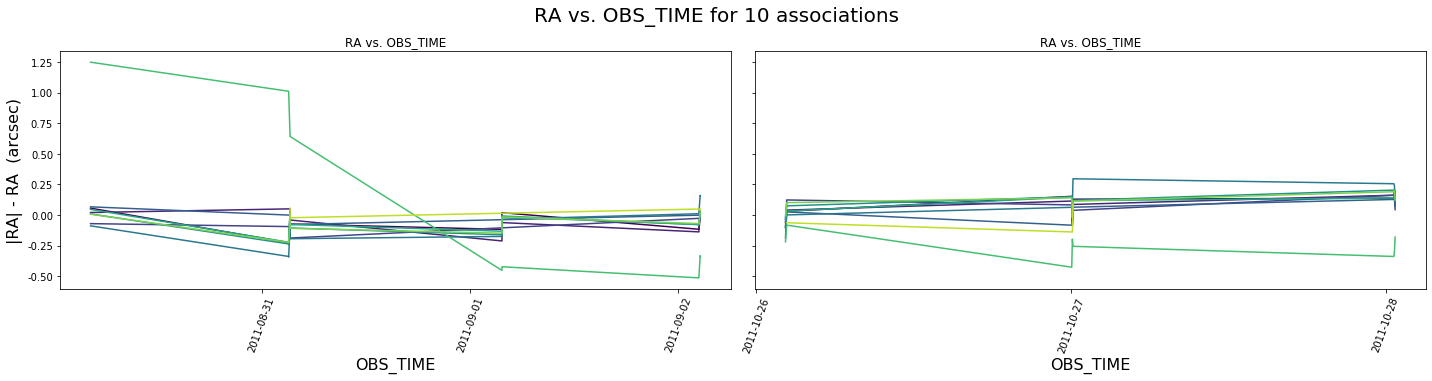

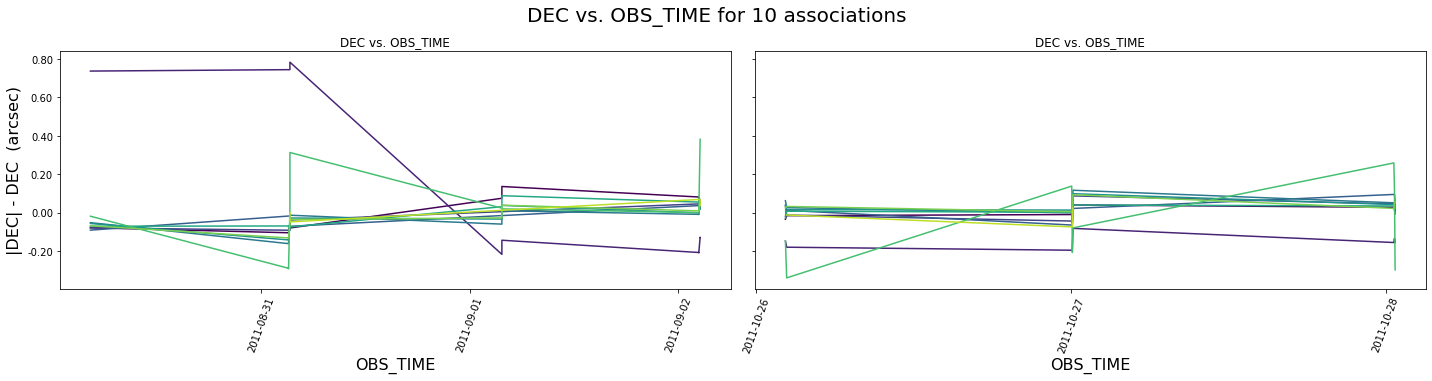

In [6]:
# Data is stored in array because we had problems with plotting in the AstroWISE environment. Data is obtained with get_AssociateList_data()

data = [[[3111081, 0, 325.184732702952, 0.76121785151179], [2396271, 29, 325.184735690209, 0.761230675224558], [2396631, 3, 325.184763055121, 0.761246159396117], [2397011, 2, 325.184766787459, 0.761237426026295], [2397271, 20, 325.184717964789, 0.761225475313984], [2397441, 2, 325.1847696065, 0.76123226573744], [2397801, 0, 325.184765393224, 0.761242735094116], [2399201, 3, 325.184719729521, 0.761220131749015], [2399551, 2, 325.184783679694, 0.76124782736816], [2932341, 0, 325.18474276116, 0.761213165599048], [2932411, 0, 325.184663960727, 0.761205925346778], [2933431, 4, 325.184734284067, 0.761240711430146], [2933631, 2, 325.184694746997, 0.761257644070116], [2931811, 0, 325.184706650509, 0.761212842077225], [2933041, 2, 325.184694534087, 0.761255812494023], [3244161, 2, 325.184732459425, 0.761272844599402], [3243821, 0, 325.184663087464, 0.761206472776571], [3244761, 2, 325.184694535838, 0.761256500018732], [3244531, 3, 325.184734370429, 0.761240624337259]], [[3111081, 1, 325.16520607085, 0.760565393635807], [2396271, 30, 325.165203210675, 0.760308566841393], [2396631, 4, 325.165216057149, 0.76033582177783], [2397011, 3, 325.165217141066, 0.760315944020652], [2397271, 21, 325.16517526253, 0.760317419559224], [2397441, 3, 325.16522382881, 0.760304224506116], [2397801, 2, 325.165237118222, 0.760315352552357], [2399201, 4, 325.165176153157, 0.760306258777806], [2399551, 3, 325.165240333779, 0.760321218883061], [2932341, 2, 325.165197716268, 0.760563341530932], [2933431, 3, 325.165186934761, 0.760322980211844], [2933631, 1, 325.165153730626, 0.760300922779814], [2931811, 1, 325.165180691533, 0.760576196959321], [2933041, 3, 325.165133084867, 0.760298215985706], [3244161, 3, 325.165174889177, 0.760318663739998], [3244761, 1, 325.165156188816, 0.760300379439311], [3244531, 4, 325.165186955538, 0.760322766884235]], [[3111081, 2, 325.158507426467, 0.761622743824074], [2396271, 33, 325.158568056684, 0.761644559944494], [2396631, 7, 325.158544468752, 0.761672454855488], [2397011, 5, 325.158546077328, 0.761646650723062], [2397271, 24, 325.158504719773, 0.761657780413832], [2397441, 6, 325.158556766741, 0.761636047838665], [2397801, 4, 325.158578755456, 0.76166087297927], [2399201, 7, 325.158510683223, 0.761646156320998], [2399551, 5, 325.158574591825, 0.761652262889516], [2932341, 1, 325.15851418439, 0.761626160240065], [2933431, 7, 325.15852631022, 0.76166089545747], [2931811, 2, 325.158481401423, 0.761637557765207], [3244531, 7, 325.158525945769, 0.761660906993752]], [[3111081, 3, 325.204806199986, 0.762128679800458], [2396271, 34, 325.204813497642, 0.762136803489798], [2396631, 8, 325.204824212424, 0.762139541319805], [2397011, 6, 325.204825670591, 0.762148577633923], [2397271, 25, 325.204754065731, 0.762128199724956], [2399201, 8, 325.204783219569, 0.762115494614187], [2399551, 6, 325.20484190354, 0.7621598333516], [2932341, 3, 325.204825056352, 0.762108160383473], [2933431, 8, 325.20480616822, 0.762143727465255], [2931811, 3, 325.204784699122, 0.762113703029418], [3244531, 8, 325.204806468023, 0.762144076563111]], [[3111081, 4, 325.160892299701, 0.767720702838426], [2396271, 35, 325.160920933745, 0.767742546250696], [2396631, 9, 325.161003166648, 0.767767661903734], [2397011, 7, 325.160948903235, 0.767745973760545], [2397271, 26, 325.16089386324, 0.767752548445886], [2397441, 7, 325.16093827169, 0.767734930681226], [2397801, 5, 325.160991892831, 0.767749494695418], [2399201, 9, 325.160942831024, 0.767740140928644], [2399551, 7, 325.16098670589, 0.767748957368744], [2932341, 4, 325.160896123149, 0.767720798402087], [2932411, 2, 325.160826521521, 0.767690447833827], [2933431, 9, 325.160965344786, 0.767754190951317], [2933631, 5, 325.160923624055, 0.767732805078699], [2931811, 4, 325.1608668093, 0.767731562829802], [2933041, 6, 325.160872072212, 0.767718661444356], [3244161, 6, 325.16091111893, 0.767738001118104], [3243821, 2, 325.160825140707, 0.767691590397866], [3244761, 5, 325.160923708364, 0.767732625164037], [3244531, 9, 325.160964932266, 0.767754292246058]], [[3111081, 5, 325.165306887808, 0.767110926827637], [2396271, 37, 325.165331063671, 0.767130629273141], [2396631, 11, 325.165343596457, 0.767153507622376], [2397011, 9, 325.165347697488, 0.767136028631225], [2397271, 28, 325.165305212837, 0.767137094977452], [2397441, 9, 325.165351565881, 0.767129817030618], [2397801, 6, 325.165366940944, 0.767137837425053], [2399201, 11, 325.165306761422, 0.767127064198055], [2399551, 9, 325.165367800937, 0.767141551766346], [2932341, 5, 325.165312629946, 0.767110428286611], [2932411, 1, 325.165244461011, 0.767086671318603], [2933431, 11, 325.16531900964, 0.767140943392434], [2933631, 6, 325.165288608145, 0.767125835133802], [2931811, 5, 325.165280719038, 0.767118367044155], [2933041, 7, 325.165265305795, 0.767116852667034], [3244161, 7, 325.165306060274, 0.767136624780055], [3243821, 1, 325.165242673136, 0.767087832709238], [3244761, 6, 325.165288520187, 0.767125285627446], [3244531, 11, 325.165319159343, 0.767140950817871]], [[3111081, 6, 325.182531248231, 0.766739151151619], [2396271, 36, 325.18253606311, 0.766757619846217], [2396631, 10, 325.182559887009, 0.766766582677222], [2397011, 8, 325.182564767035, 0.766761621193665], [2397271, 27, 325.18251299926, 0.766747706236242], [2397441, 8, 325.182567692911, 0.766756107279217], [2397801, 7, 325.182565705348, 0.766765172247863], [2399201, 10, 325.182520255526, 0.766742960538211], [2399551, 8, 325.182582439107, 0.766768921335929], [2932341, 6, 325.182539798338, 0.766735850382585], [2932411, 3, 325.182465099435, 0.766736267432628], [2933431, 10, 325.182535378802, 0.766760597891536], [2933631, 7, 325.182505239117, 0.76677082818864], [2931811, 6, 325.182505525238, 0.766734811755524], [2933041, 8, 325.182490180002, 0.766764127933439], [3244161, 8, 325.182524843636, 0.766780023460265], [3243821, 3, 325.182466351236, 0.766733953033264], [3244761, 7, 325.1825046612, 0.76677024458258], [3244531, 10, 325.182535577894, 0.766760309899939]], [[3111081, 7, 325.101405634611, 0.774580919482009], [2396271, 41, 325.101200355195, 0.774478215481035], [2396631, 15, 325.101152215345, 0.774550558447893], [2397011, 10, 325.101173270144, 0.774489830971753], [2397271, 34, 325.101162426352, 0.774531879434202], [2397441, 10, 325.101104713683, 0.774610958214194], [2397801, 8, 325.101129126173, 0.774644496555063], [2399201, 16, 325.101168544063, 0.774515090227704], [2399551, 10, 325.101141394906, 0.774604889113325], [2932341, 7, 325.101570984724, 0.774567439668715], [2932411, 5, 325.101504861989, 0.774492108242351], [2933431, 12, 325.101130906576, 0.774678535474968], [2933631, 9, 325.101080392568, 0.774572737050712], [2931811, 7, 325.101402099459, 0.774659585309462], [2933041, 10, 325.101097392904, 0.774579067922121], [3244161, 10, 325.101105729098, 0.774578000625519], [3243821, 4, 325.101503946518, 0.774491445224936], [3244761, 9, 325.101081576492, 0.774572511672185], [3244531, 12, 325.101129283578, 0.774678785567318]], [[3111081, 8, 325.166887210672, 0.769511153422873], [2396271, 40, 325.166919991574, 0.769535636598447], [2396631, 14, 325.166923378193, 0.769552583697464], [2397011, 11, 325.166925873151, 0.769542339062965], [2397271, 30, 325.166889491548, 0.769533298632868], [2397441, 11, 325.166930970856, 0.769527895743066], [2397801, 9, 325.166944788318, 0.769532786430154], [2399201, 13, 325.166886443782, 0.769526967966845], [2399551, 11, 325.166947758096, 0.7695423421961], [2932341, 8, 325.166893771364, 0.769507630345452], [2932411, 4, 325.166829682255, 0.769490078321778], [2933431, 14, 325.166896743382, 0.769539371198693], [2933631, 8, 325.166872434419, 0.76952921829593], [2931811, 8, 325.166861583297, 0.769516650914338], [2933041, 9, 325.166850454319, 0.769519089333713], [3244161, 9, 325.166887355764, 0.76953739485438], [3243821, 5, 325.166828827194, 0.769490944467616], [3244761, 8, 325.16687212238, 0.769528935267034], [3244531, 14, 325.166896578967, 0.769539340429374]], [[3111081, 9, 325.213021877569, 0.768047628302559], [2396271, 39, 325.212988871853, 0.768044068026563], [2396631, 13, 325.213029651927, 0.768054183529546], [2399201, 12, 325.212967903883, 0.768026814790561], [2933431, 13, 325.213020076473, 0.76806659484636], [2931811, 9, 325.213000241052, 0.768034073169695], [3244531, 13, 325.213016700956, 0.768057947656505]], [[3111081, 10, 325.103785994144, 0.772252308620847], [2396271, 42, 325.103782579144, 0.772265840219223], [2396631, 16, 325.103778606756, 0.772367218532855], [2397011, 12, 325.103787069634, 0.772292825805487], [2397271, 31, 325.1037703017, 0.77233768861858], [2397441, 12, 325.103762601117, 0.772279165572132], [2397801, 10, 325.103796594282, 0.772310323725346], [2399201, 14, 325.103790911485, 0.772343179758473], [2399551, 12, 325.103803028425, 0.772272871878958], [2932341, 9, 325.103760707725, 0.772234006559543], [2932411, 6, 325.103685656847, 0.772183492181973], [2933431, 15, 325.103785892568, 0.77235070904222], [2933631, 10, 325.103742751198, 0.772229687743956], [2931811, 10, 325.103781208784, 0.772328650130683], [2933041, 11, 325.103746200013, 0.772234665275541], [3244161, 11, 325.103758262875, 0.772234502131578], [3243821, 6, 325.103685410275, 0.772185343668343], [3244761, 10, 325.103743581566, 0.7722293052779], [3244531, 15, 325.103784487376, 0.772350822818792]], [[3111081, 11, 325.103999485433, 0.773289279431625], [2396271, 43, 325.103996104763, 0.773300324284], [2396631, 17, 325.103990001033, 0.773397712219162], [2397011, 13, 325.103997717642, 0.773319386166038], [2397271, 32, 325.103984982374, 0.773375201920822], [2397441, 13, 325.103978269222, 0.773310212289712], [2397801, 11, 325.104006980703, 0.77332539859588], [2399201, 15, 325.104000629744, 0.773375299146128], [2399551, 13, 325.104014606324, 0.773297790283686], [2932341, 10, 325.103974158719, 0.773270836280006], [2932411, 7, 325.103896091359, 0.773228286880014], [2933431, 16, 325.104000610927, 0.773387256679261], [2933631, 11, 325.103959618664, 0.773264063227251], [2931811, 11, 325.103994635732, 0.773364671990073], [2933041, 12, 325.103956208733, 0.773269037541622], [3244161, 12, 325.103967698618, 0.773270340135552], [3243821, 7, 325.103899320599, 0.773228343676033], [3244761, 11, 325.103956581057, 0.773264682542387], [3244531, 16, 325.10399926658, 0.773387377057114]], [[3111081, 12, 325.12036362555, 0.772357563501911], [2396271, 45, 325.120407850465, 0.772377332685281], [2396631, 19, 325.120374516572, 0.772442571567507], [2397011, 15, 325.120369044336, 0.772391640546341], [2399201, 19, 325.120361598462, 0.772407997564485], [2399551, 14, 325.12040573708, 0.772385298142738], [2933431, 18, 325.120369680195, 0.772434637148939], [2931811, 12, 325.120349822853, 0.772410551479197], [3244531, 18, 325.120368867908, 0.772434668064036]], [[3111081, 13, 325.175897046476, 0.771585473347806], [2396271, 44, 325.175948266116, 0.771618622477291], [2396631, 18, 325.175929684376, 0.7716244790042], [2397011, 14, 325.175932671109, 0.771632267181943], [2399201, 17, 325.175899985991, 0.771589187932722], [2933431, 17, 325.175916728075, 0.771608287143898], [2931811, 13, 325.175871832621, 0.771584050046124], [3244531, 17, 325.17591657748, 0.771608520657999]], [[3111081, 14, 325.157937697893, 0.774541521756531], [2397271, 35, 325.15792931917, 0.774573272822511], [2399201, 21, 325.157949891013, 0.774564001017051], [2932341, 11, 325.157947901605, 0.774544543893779], [2933431, 20, 325.1579621854, 0.774579133136552], [2931811, 14, 325.157913410388, 0.774552937047322], [3244531, 20, 325.157961793013, 0.77457903770058]], [[3111081, 15, 325.21304785909, 0.774043752025243], [2396271, 47, 325.213028034047, 0.774037283550339], [2396631, 21, 325.213045301284, 0.774051902703386], [2397271, 33, 325.212988022952, 0.774011079075563], [2399201, 20, 325.213008383321, 0.774019190367893], [2932341, 12, 325.213064007544, 0.774013349024103], [2933431, 19, 325.213036417255, 0.774045733422123], [2931811, 15, 325.213031161203, 0.774026358652511], [3244531, 19, 325.213036544353, 0.77404608051906]], [[3111081, 16, 325.178906104264, 0.774881491836042], [2396271, 48, 325.178941850184, 0.774907796511291], [2396631, 22, 325.178926277975, 0.774913520743018], [2397271, 36, 325.178891444394, 0.774897866464635], [2397441, 14, 325.178946627292, 0.774890916073225], [2399201, 22, 325.178907712312, 0.774891218664737], [2932341, 13, 325.178910400288, 0.774878696712121], [2933431, 21, 325.178925872011, 0.774900694458164], [2931811, 16, 325.178881446322, 0.7748776325492], [3244531, 21, 325.17892561446, 0.774900762977916]], [[3111081, 17, 325.183199555153, 0.778566705899162], [2396271, 49, 325.183201516796, 0.778581509452273], [2396631, 23, 325.183222613276, 0.778586639416268], [2397011, 17, 325.183229214019, 0.778582759193119], [2397271, 37, 325.183185807441, 0.778568496796125], [2397441, 15, 325.183231382896, 0.778576792489812], [2397801, 12, 325.183232689757, 0.778583614816905], [2399201, 23, 325.183188412528, 0.7785649317092], [2399551, 15, 325.183243893728, 0.778589297078429], [2932341, 14, 325.183204798845, 0.778562403601396], [2932411, 8, 325.183149030415, 0.778556639617921], [2933431, 22, 325.1832006591, 0.778580763464645], [2933631, 12, 325.183177398675, 0.778597098294927], [2931811, 17, 325.183175962401, 0.77855979380276], [2933041, 13, 325.183176271591, 0.77859744727452], [3244161, 13, 325.183204703689, 0.778609269618996], [3243821, 8, 325.183148432502, 0.778557313321523], [3244761, 12, 325.183177686633, 0.778595129026998], [3244531, 22, 325.183200673935, 0.778580819607311]], [[3111081, 20, 325.21894479821, 0.777460699412601], [2396271, 50, 325.218905786794, 0.777459037993826], [2396631, 24, 325.218935478942, 0.777455252425841], [2397011, 18, 325.218937871968, 0.777475122891464], [2397271, 39, 325.218876483826, 0.777426920252721], [2399201, 24, 325.218901016343, 0.777439662524071], [2399551, 16, 325.218917810824, 0.777476984748283], [2932341, 16, 325.21894510411, 0.777430305613512], [2933431, 23, 325.218921643721, 0.777464226947535], [2931811, 19, 325.218931337981, 0.77744248601399], [3244531, 23, 325.218921981563, 0.777464724507347]], [[3111081, 21, 325.191500431549, 0.78250629201724], [2396271, 51, 325.191480371223, 0.782522174485055], [2396631, 25, 325.191514547604, 0.78252347105318], [2397011, 19, 325.191513582492, 0.782534596422385], [2397271, 40, 325.191467260281, 0.782517371374779], [2397441, 16, 325.191515005014, 0.782532884673856], [2397801, 13, 325.191507208621, 0.782538047485871], [2399201, 25, 325.191476100458, 0.782513810182639], [2399551, 17, 325.191526060654, 0.782542799435069], [2932341, 18, 325.191494484415, 0.782516365800196], [2932411, 10, 325.191445007286, 0.782521738420379], [2933431, 24, 325.191486222282, 0.782531826220009], [2933631, 13, 325.191466263316, 0.782562872395592], [2931811, 20, 325.191478865207, 0.782495338649513], [2933041, 14, 325.191476951253, 0.782569324578017], [3244161, 14, 325.191500243364, 0.782577360206087], [3243821, 10, 325.191444248565, 0.782521248624649], [3244761, 13, 325.191465797809, 0.782562455155762], [3244531, 24, 325.191486257672, 0.78253202356135]], [[3111081, 22, 325.134975050208, 0.779187126031739], [2396271, 52, 325.135032532794, 0.779218338146306], [2396631, 26, 325.1349926102, 0.779261435227467], [2397011, 20, 325.13499197316, 0.779229605560922], [2397271, 41, 325.134956935611, 0.779237395871611], [2397441, 17, 325.13501335705, 0.779220035360726], [2399201, 26, 325.134981390064, 0.779233739197761], [2399551, 18, 325.135027328835, 0.779219708453108], [2932341, 17, 325.134959930037, 0.779191765940086], [2933431, 25, 325.134993740413, 0.779238695083067], [2931811, 21, 325.134956412101, 0.779219237790325], [3244531, 25, 325.134993111238, 0.779238655449058]], [[3111081, 23, 325.17738027014, 0.779519473913624], [2396271, 54, 325.177421149964, 0.779543590344257], [2396631, 28, 325.177402665067, 0.779540769028157], [2397011, 21, 325.177416333184, 0.779523040003951], [2397271, 42, 325.17736725518, 0.779524674834247], [2397441, 18, 325.177418188153, 0.779528504503265], [2397801, 14, 325.177430264468, 0.779529887568675], [2399201, 27, 325.177375818896, 0.779514245127572], [2399551, 19, 325.17743400913, 0.779544266430238], [2932341, 19, 325.177390752988, 0.779516240109733], [2933431, 27, 325.177395331678, 0.779533454589305], [2931811, 22, 325.177356235955, 0.779515679084885], [3244531, 27, 325.177395310962, 0.779533419409194]], [[3111081, 24, 325.195793074546, 0.779355251790004], [2396271, 53, 325.195806545391, 0.779369066476381], [2396631, 27, 325.195806141054, 0.779355108134754], [2399201, 28, 325.195777682017, 0.779342916723814], [2933431, 26, 325.195808983474, 0.779361863860673], [2931811, 23, 325.195772004286, 0.779342671206542], [3244531, 26, 325.195809050498, 0.779362050968955]], [[3111081, 25, 325.182382411221, 0.781364532146651], [2396271, 55, 325.182388984438, 0.781384635369407], [2396631, 29, 325.182405276117, 0.78138309120082], [2397011, 22, 325.182407917982, 0.781380963170052], [2397271, 43, 325.182356959948, 0.781374605202069], [2397441, 19, 325.182415742129, 0.781382024419788], [2397801, 15, 325.182416606206, 0.78139555814394], [2399201, 29, 325.182373184722, 0.781361312068776], [2399551, 20, 325.182423070204, 0.781386197772323], [2932341, 20, 325.182383181707, 0.781366591240383], [2933431, 28, 325.182384452345, 0.781374947733357], [2931811, 24, 325.182358776806, 0.781358195060751], [3244531, 28, 325.182384724687, 0.781375697303094]], [[3111081, 28, 325.187482892061, 0.782587990582293], [2396271, 56, 325.187474723914, 0.782603473022049], [2396631, 30, 325.187500278192, 0.782604676293152], [2397011, 23, 325.187504582942, 0.782603608817962], [2397271, 44, 325.187450622704, 0.782590136652373], [2397441, 20, 325.187513885182, 0.782606378943079], [2397801, 16, 325.187505954356, 0.78261801090302], [2399201, 30, 325.187467470527, 0.782582132768005], [2399551, 21, 325.187515969818, 0.782614491818483], [2932341, 21, 325.18748200061, 0.782590734833923], [2933431, 29, 325.187482500102, 0.782600018467096], [2931811, 27, 325.187460593332, 0.782578498211], [3244531, 29, 325.187482572576, 0.782600125781479]], [[3111081, 30, 325.183391307213, 0.78324515890611], [2396271, 57, 325.183405829435, 0.78326945000523], [2396631, 31, 325.183400495531, 0.783262812271912], [2397011, 24, 325.183402365094, 0.783263574765755], [2399201, 31, 325.183367223729, 0.783238699907073], [2933431, 30, 325.183392666268, 0.783255267157723], [2931811, 29, 325.183368459355, 0.783237587966899], [3244531, 30, 325.183392813234, 0.78325506953135]], [[3111081, 31, 325.184840474848, 0.784955681017806], [2396271, 58, 325.18486745023, 0.784976003405587], [2396631, 32, 325.184865336601, 0.784969568885329], [2397011, 25, 325.184862551858, 0.7849693960526], [2397271, 45, 325.184821742288, 0.784959431416606], [2397441, 21, 325.184872204548, 0.784966865229203], [2397801, 17, 325.184881136063, 0.784963745362836], [2399201, 32, 325.184828211626, 0.78494961251875], [2399551, 22, 325.184874122151, 0.784980180410915], [2932341, 22, 325.184844898399, 0.784958207009804], [2933431, 31, 325.184842236237, 0.784963560057728], [2931811, 30, 325.184818142722, 0.784947080835805], [3244531, 31, 325.18484278669, 0.784962379800137]], [[3111081, 32, 325.186287605937, 0.784611185102346], [2396271, 59, 325.18631058758, 0.784633174077405], [2396631, 33, 325.186303445935, 0.784625664911896], [2399201, 33, 325.186280059164, 0.784605491146477], [2933431, 32, 325.186307566812, 0.784628787076148], [2931811, 31, 325.186265448581, 0.784601964111094], [3244531, 32, 325.186307654565, 0.784628906866334]], [[3111081, 33, 325.179523763794, 0.784925034168668], [2397271, 46, 325.179512089517, 0.784939043613229], [2399201, 34, 325.179532580908, 0.784923934299728], [2932341, 23, 325.179527006506, 0.784922884593004], [2933431, 33, 325.179536069506, 0.784937766363637], [2931811, 32, 325.179500588889, 0.784919205634685], [3244531, 33, 325.179536144026, 0.784937679538645]], [[3111081, 34, 325.104040981658, 0.787331056277175], [2933431, 34, 325.10403050518, 0.787404321256528], [2931811, 33, 325.104037449946, 0.787398279451453], [3244531, 34, 325.104029198792, 0.78740446222347]], [[3111081, 35, 325.140014196855, 0.788797207608355], [2396271, 61, 325.140034650639, 0.788819723075566], [2396631, 34, 325.140032794319, 0.788846440479406], [2397011, 26, 325.140037823483, 0.788821316657469], [2397271, 48, 325.140001212118, 0.788842117840825], [2397441, 22, 325.140041200036, 0.788814306209822], [2397801, 18, 325.14006433459, 0.788827740491658], [2399201, 35, 325.140013070624, 0.788823513612809], [2399551, 23, 325.140053785196, 0.788818083158388], [2932341, 24, 325.140004057942, 0.788801019955854], [2933431, 36, 325.14002083831, 0.788827612763277], [2931811, 34, 325.139995037735, 0.788820345784629], [3244531, 36, 325.140020343139, 0.788827497918573]], [[3111081, 36, 325.219772933839, 0.788552999562116], [2396271, 60, 325.219701915835, 0.788543659106943], [2397271, 47, 325.219712251387, 0.788515120303335], [2932341, 25, 325.219776301996, 0.788529005651828], [2932411, 11, 325.219717933346, 0.78857367794916], [2933431, 35, 325.219423840357, 0.788543321314188], [2931811, 35, 325.219761937797, 0.788535555083426], [3243821, 11, 325.219722446548, 0.788568007241383], [3244531, 35, 325.219424063011, 0.788543770655481]], [[3111081, 37, 325.188954967094, 0.789005465668064], [2396271, 62, 325.18894926363, 0.789011243834915], [2396631, 35, 325.188964370326, 0.789003044431909], [2397011, 27, 325.188968950941, 0.78901024826083], [2397271, 49, 325.188918751626, 0.789010855253469], [2397441, 23, 325.188979473049, 0.789025272538398], [2397801, 19, 325.188964859309, 0.78901221794863], [2399201, 36, 325.188935008589, 0.788996448684651], [2399551, 24, 325.188981435181, 0.789029511900527], [2932341, 26, 325.188945875051, 0.789019020851301], [2933431, 37, 325.188950781192, 0.789011466242236], [2931811, 36, 325.188933939212, 0.788994584262805], [3244531, 37, 325.188950777843, 0.789011407899096]], [[3111081, 38, 325.214869280664, 0.790474664147731], [2396271, 63, 325.214811237653, 0.790467205588417], [2396631, 36, 325.214855676536, 0.790464217710148], [2397011, 28, 325.214864763903, 0.790473460499904], [2397271, 50, 325.214816343283, 0.79044190494168], [2397441, 24, 325.214852625188, 0.790476492738541], [2397801, 20, 325.214824869301, 0.790485151577752], [2399201, 37, 325.214828320254, 0.790454192728973], [2399551, 25, 325.214860540514, 0.790479474655631], [2932341, 27, 325.214867175502, 0.790455811129025], [2932411, 12, 325.214814733059, 0.790495788170539], [2933431, 38, 325.21484312737, 0.790474160834519], [2933631, 15, 325.214838419559, 0.790544675713464], [2931811, 37, 325.214856459331, 0.79045762933779], [2933041, 15, 325.214883087495, 0.790559393138544], [3244161, 15, 325.214886904287, 0.790551760710437], [3243821, 12, 325.214820911341, 0.790494681501013], [3244761, 15, 325.214838782701, 0.790551646419738], [3244531, 38, 325.214843276008, 0.790474498243698]], [[3111081, 39, 325.131372952614, 0.793815652433042], [2396271, 64, 325.131385931411, 0.793836885101696], [2396631, 37, 325.131382070123, 0.793871290678594], [2397011, 29, 325.1313906876, 0.79384085635254], [2397271, 51, 325.131368221581, 0.793864861247699], [2397441, 25, 325.131384534727, 0.79383288666637], [2397801, 21, 325.131411082468, 0.793843205772219], [2399201, 38, 325.131372848737, 0.793853617230801], [2399551, 26, 325.131408558455, 0.793834414467137], [2932341, 28, 325.131354655159, 0.793819442898179], [2932411, 13, 325.131319488092, 0.79377472690658], [2933431, 39, 325.131371453934, 0.793855907496127], [2933631, 16, 325.131360270307, 0.793799467541084], [2931811, 38, 325.131356971704, 0.793845676889206], [2933041, 16, 325.131343139769, 0.793797106332545], [3244161, 16, 325.131362391209, 0.793804780690376], [3243821, 13, 325.131319091149, 0.793775735946273], [3244761, 16, 325.13135948597, 0.793797857038642], [3244531, 39, 325.131370826267, 0.793855793065086]], [[3111081, 40, 325.113325133196, 0.792543198959966], [2397271, 52, 325.113291879016, 0.792603538746178], [2932341, 29, 325.113271757914, 0.792547068662807], [2933431, 40, 325.113323464549, 0.792599711666439], [2931811, 39, 325.113316695386, 0.792594935907245], [3244531, 40, 325.113322532796, 0.792599685553239]], [[3111081, 42, 325.171248365445, 0.793093171151094], [2399201, 39, 325.171237350647, 0.793090430161508], [2933431, 41, 325.17126533935, 0.793118448155126], [2931811, 41, 325.171226144109, 0.793090630946586], [3244531, 41, 325.171265190438, 0.793118387360176]], [[3111081, 43, 325.195246899092, 0.796598592473812], [2396271, 65, 325.195228337225, 0.796609305786518], [2396631, 38, 325.195251870595, 0.796602593679935], [2397011, 30, 325.195259974157, 0.796610366813111], [2397271, 53, 325.19521830447, 0.796587156593619], [2397441, 26, 325.195261396975, 0.796609343459404], [2397801, 22, 325.195257380774, 0.796608216781055], [2399201, 40, 325.195227565602, 0.796589766743941], [2399551, 27, 325.195267761181, 0.796614354962803], [2932341, 30, 325.195247532677, 0.796597328546386], [2932411, 14, 325.195214090979, 0.7965965812604], [2933431, 42, 325.195237482887, 0.796600414390058], [2933631, 17, 325.195229792111, 0.796640443999565], [2931811, 42, 325.195228785678, 0.796585303684257], [2933041, 17, 325.195246463468, 0.796644394865375], [3244161, 17, 325.19526109463, 0.796646522193492], [3243821, 14, 325.19521731729, 0.796596646042455], [3244761, 17, 325.195231084622, 0.796644030606904], [3244531, 42, 325.19523780715, 0.796600794995858]], [[3111081, 44, 325.158848626601, 0.797699028364052], [2396271, 66, 325.158895142667, 0.797723999090692], [2396631, 39, 325.158867964969, 0.797726290685759], [2397011, 31, 325.158875845663, 0.797719384779124], [2397271, 54, 325.158839532344, 0.797714591084078], [2397441, 27, 325.158875917271, 0.797702634465574], [2397801, 23, 325.158900421939, 0.797710581829737], [2399201, 41, 325.158846434828, 0.797701922945492], [2399551, 28, 325.158890584844, 0.797719601276817], [2932341, 31, 325.158841452117, 0.797703557087012], [2932411, 15, 325.158803075556, 0.797669902510129], [2933431, 43, 325.158854538261, 0.797712426923151], [2933631, 18, 325.158851838318, 0.797701693223928], [2931811, 43, 325.15882720531, 0.797703485362081], [2933041, 18, 325.158826104761, 0.797689873078767], [3244161, 18, 325.158850056097, 0.797701473875241], [3243821, 15, 325.158802683423, 0.797670421627445], [3244761, 18, 325.158852143914, 0.797702195248264], [3244531, 43, 325.158854330386, 0.797712362173576]], [[3111081, 45, 325.137638131195, 0.797571713361546], [2396271, 68, 325.137678889233, 0.797602786272369], [2396631, 41, 325.137642893888, 0.797619184862995], [2397011, 34, 325.137650185142, 0.79760535806394], [2399201, 42, 325.1376370918, 0.7975966913126], [2933431, 44, 325.137643305144, 0.797600747869655], [2931811, 44, 325.137620835414, 0.797593985355901], [3244531, 44, 325.13763928453, 0.797596416411597]], [[3111081, 46, 325.149412408257, 0.797926022794935], [2396271, 69, 325.149458363213, 0.797943480264161], [2396631, 42, 325.149429501043, 0.797961531140411], [2397011, 32, 325.149439051519, 0.797941720608677], [2397271, 55, 325.149402381003, 0.797939542410359], [2399201, 43, 325.149404110482, 0.797943535225929], [2399551, 29, 325.149449226579, 0.797961883623797], [2932341, 32, 325.149392846196, 0.797928570254547], [2933431, 45, 325.149421645089, 0.797943882422626], [2931811, 45, 325.149392290891, 0.797937579506532], [3244531, 45, 325.149421296088, 0.79794385524352]], [[3111081, 48, 325.140745006789, 0.799132378430003], [2396271, 70, 325.140797764913, 0.799160598922531], [2396631, 43, 325.140758420598, 0.79917192637702], [2397011, 35, 325.140758455186, 0.799160425502195], [2397271, 56, 325.140742283159, 0.799166989960742], [2397441, 28, 325.140771936136, 0.799139630793928], [2397801, 24, 325.140782097295, 0.799164999190604], [2399201, 44, 325.140747681361, 0.799161406689509], [2399551, 30, 325.140775225719, 0.799164616020401], [2932341, 33, 325.140729624381, 0.799140511589041], [2932411, 16, 325.140703426891, 0.799106737306398], [2933431, 46, 325.140754911917, 0.799163698867151], [2933631, 19, 325.1407592426, 0.799127229577283], [2931811, 47, 325.140726741603, 0.79915123040651], [2933041, 19, 325.140718153132, 0.799125358299347], [3244161, 19, 325.140738675829, 0.79913486892535], [3243821, 16, 325.140702670273, 0.799107670999107], [3244761, 19, 325.140760113581, 0.799127399744892], [3244531, 46, 325.14075450228, 0.79916351846795]], [[3111081, 49, 325.108836797065, 0.80120369743827], [2932341, 34, 325.108798495738, 0.801186940835064], [2933431, 48, 325.108838999054, 0.801260299321699], [2931811, 48, 325.108831414498, 0.801256893998501], [3244531, 48, 325.108837833548, 0.801260210385036]], [[3111081, 50, 325.189720942272, 0.801003222593913], [2396271, 71, 325.189739627868, 0.801021719905086], [2396631, 44, 325.189734734258, 0.801013150675441], [2397011, 36, 325.189729156642, 0.801013515765063], [2397271, 57, 325.189692796306, 0.800992763611554], [2397441, 29, 325.189750544775, 0.801010941773716], [2397801, 25, 325.189740902179, 0.801012291559107], [2399201, 45, 325.189704095577, 0.800987151145298], [2399551, 31, 325.18974638241, 0.801014274048819], [2932341, 35, 325.189722127083, 0.801007982063011], [2933431, 47, 325.189718492531, 0.801004152938551], [2931811, 49, 325.189701892167, 0.800991290744575], [3244531, 47, 325.189718624592, 0.801004146671813]], [[3111081, 52, 325.203261638802, 0.802866799878853], [2396271, 72, 325.203243251503, 0.802867468364673], [2396631, 45, 325.20325870092, 0.802860863488873], [2397011, 37, 325.203262193012, 0.802866911662539], [2397271, 58, 325.20321981168, 0.80284713377053], [2397441, 30, 325.20326346454, 0.80287547040435], [2397801, 26, 325.203245229624, 0.802885197247378], [2399201, 46, 325.203235076529, 0.802849974877545], [2399551, 32, 325.203264176258, 0.802875158477312], [2932341, 36, 325.20325839851, 0.802859023269758], [2933431, 49, 325.203247744367, 0.802862751316659], [2931811, 51, 325.203246512007, 0.80285165301747], [3244531, 49, 325.203246731397, 0.802863082932167]], [[3111081, 53, 325.128295595266, 0.803554419468343], [2399201, 47, 325.12828689264, 0.803584791215421], [2932341, 37, 325.128272164355, 0.80355528765701], [2933431, 50, 325.128302360632, 0.803581179100246], [2931811, 52, 325.128281601267, 0.803583727305462], [3244531, 50, 325.128304401164, 0.803576142302704]], [[3111081, 55, 325.110431300613, 0.805244917988842], [2396271, 74, 325.110425737308, 0.805255861276949], [2396631, 47, 325.110397303614, 0.805311628444998], [2397011, 38, 325.110408163296, 0.805278019066481], [2399201, 48, 325.110415858433, 0.805295363867281], [2933431, 51, 325.110414173731, 0.805297981845946], [2931811, 54, 325.110425476292, 0.805294000852909], [3244531, 51, 325.110413161671, 0.805297832093929]], [[3111081, 56, 325.10566612982, 0.808523829483111], [2396271, 76, 325.105634621547, 0.808531339211918], [2396631, 49, 325.105634072179, 0.808597459506014], [2397011, 39, 325.105650368485, 0.808547736068498], [2397271, 60, 325.105632766935, 0.808580671908874], [2397441, 31, 325.105624527428, 0.808535468566344], [2397801, 27, 325.105646817778, 0.808554284905091], [2399201, 49, 325.105650946104, 0.808581391997148], [2399551, 33, 325.105660435985, 0.808530857382722], [2932341, 38, 325.105628581064, 0.808514475888626], [2932411, 17, 325.105598881334, 0.808481390387593], [2933431, 52, 325.105641513371, 0.808582802748549], [2933631, 21, 325.105623754661, 0.808509351568172], [2931811, 55, 325.105663120248, 0.80857722704581], [2933041, 21, 325.105648598646, 0.808513402979977], [3244161, 21, 325.105647092411, 0.808507765029272], [3243821, 17, 325.10559846196, 0.80848153152741], [3244761, 21, 325.105625282161, 0.80850895079348], [3244531, 52, 325.105664058474, 0.808584377770365]], [[3111081, 57, 325.164972324922, 0.806978966230563], [2396271, 75, 325.164971125918, 0.807000063031761], [2396631, 48, 325.164970339271, 0.806995802648728], [2397011, 40, 325.164979152889, 0.806994260388643], [2397271, 59, 325.164948404491, 0.806991608757678], [2397441, 32, 325.164983002443, 0.806988543605321], [2397801, 28, 325.164995310157, 0.806990561980502], [2399201, 50, 325.164951065681, 0.806980795273365], [2399551, 34, 325.164994652022, 0.806998824961333], [2932341, 39, 325.164959334642, 0.806985930192055], [2932411, 18, 325.164925487055, 0.80695092448602], [2933431, 53, 325.164956982798, 0.806987347326861], [2933631, 20, 325.164951706071, 0.806973665609437], [2931811, 56, 325.164951817318, 0.806977488004926], [2933041, 20, 325.164937624333, 0.806980368591182], [3244161, 20, 325.164958801617, 0.806986263261982], [3243821, 18, 325.164924911715, 0.806951235094572], [3244761, 20, 325.164951908082, 0.806973928605865], [3244531, 53, 325.164956881939, 0.806987254603801]], [[3111081, 58, 325.122241315847, 0.807395683177551], [2396271, 80, 325.122263599558, 0.807406222882641], [2396631, 53, 325.122241557078, 0.8074464126746], [2397011, 43, 325.122232340594, 0.807443190363733], [2399201, 54, 325.122243251064, 0.807432845081605], [2399551, 37, 325.122256817703, 0.807422593499205], [2933431, 57, 325.122241787134, 0.807441947014325], [2931811, 57, 325.122229978805, 0.807430029129766], [3244531, 57, 325.122241043044, 0.80744184339762]], [[3111081, 59, 325.172020847648, 0.807111416370835], [2396271, 77, 325.172061603404, 0.807132698912672], [2396631, 51, 325.172034913658, 0.807122872347162], [2397011, 42, 325.172047587986, 0.807136887461282], [2397271, 61, 325.172000159424, 0.807125499574095], [2397441, 33, 325.172035876244, 0.807124070560337], [2399201, 51, 325.172012739839, 0.807101669935101], [2399551, 36, 325.172056926432, 0.807125061044119], [2932341, 41, 325.172017611537, 0.807118411922469], [2933431, 54, 325.172024876614, 0.807110961640788], [2931811, 58, 325.172000495199, 0.807106181145273], [3244531, 54, 325.17202480757, 0.807110812637994]], [[3111081, 60, 325.155551608079, 0.807222989747564], [2396271, 78, 325.155620585147, 0.807251347184029], [2396631, 52, 325.15556893552, 0.807228073828393], [2397271, 62, 325.155539903883, 0.807254328225253], [2399201, 53, 325.155555356909, 0.807221378949172], [2932341, 40, 325.155527944275, 0.807227862490556], [2933431, 56, 325.155554049223, 0.807227884383513], [2931811, 59, 325.155531610997, 0.807227474873313], [3244531, 56, 325.155553841354, 0.807227673581075]], [[3111081, 62, 325.205206669095, 0.808420704695087], [2396271, 79, 325.205169666126, 0.808419679118035], [2396631, 50, 325.205199273481, 0.808412861293515], [2397011, 41, 325.20520591502, 0.808422106698173], [2397271, 63, 325.205168639599, 0.808395658806991], [2397441, 34, 325.205206278787, 0.808427387447307], [2397801, 29, 325.205185982234, 0.808421264998083], [2399201, 52, 325.205177292351, 0.808402173124953], [2399551, 35, 325.205206010309, 0.808425193022206], [2932341, 42, 325.205202643097, 0.808413847097319], [2932411, 19, 325.205168904637, 0.808436690993972], [2933431, 55, 325.205187738351, 0.808417649501269], [2931811, 61, 325.205193370924, 0.808405265326772], [3243821, 19, 325.205168302149, 0.808436129134276], [3244531, 55, 325.205187830328, 0.808417796148375]], [[3111081, 64, 325.180198428693, 0.813233410670042], [2396271, 81, 325.180226976048, 0.813249980663371], [2396631, 54, 325.180200343264, 0.813234997110364], [2397011, 44, 325.18021541731, 0.813241749035009], [2397271, 64, 325.18018653669, 0.813225881581672], [2397441, 35, 325.180221723677, 0.813242077656382], [2397801, 30, 325.180222941446, 0.813239613251549], [2399201, 55, 325.180191891763, 0.81322179458699], [2399551, 38, 325.180222403309, 0.813255439337558], [2932341, 44, 325.180192858071, 0.813237834675404], [2932411, 20, 325.180174036697, 0.813228355200481], [2933431, 58, 325.180198041343, 0.813230115535623], [2933631, 22, 325.180196501535, 0.813240377642959], [2931811, 63, 325.180179514357, 0.813223865033322], [2933041, 22, 325.180210020783, 0.813234591377349], [3244161, 22, 325.180218083769, 0.813241705123174], [3243821, 20, 325.18017432002, 0.813228212753015], [3244761, 22, 325.180196600184, 0.813240291619645], [3244531, 58, 325.180200738609, 0.813231983917401]], [[3111081, 65, 325.109418681309, 0.816125612237894], [2396271, 82, 325.109389273843, 0.816135508624533], [2396631, 55, 325.109389282871, 0.816187857685583], [2397011, 45, 325.109406419999, 0.816146872264297], [2397271, 65, 325.109385123595, 0.816176905182524], [2397441, 36, 325.109382122653, 0.816136573579191], [2397801, 31, 325.109401341045, 0.81615333398641], [2399201, 56, 325.109402786564, 0.816173297513856], [2399551, 39, 325.109413711161, 0.816133524145854], [2932341, 45, 325.109381029125, 0.816121303962136], [2932411, 21, 325.109361804935, 0.816088983311469], [2933431, 59, 325.109394679049, 0.816174689701465], [2933631, 23, 325.109381676501, 0.816110861838029], [2931811, 64, 325.109414107821, 0.816170531809002], [2933041, 23, 325.109403468208, 0.816115073024486], [3244161, 23, 325.109402716685, 0.816109890806387], [3243821, 21, 325.109361830675, 0.816088895102666], [3244761, 23, 325.109382458849, 0.816110561671359], [3244531, 59, 325.109393727446, 0.816174637831368]], [[3111081, 66, 325.104156599243, 0.815464934665513], [2396271, 84, 325.104151874612, 0.815471981597868], [2396631, 58, 325.10412213572, 0.815536329718359], [2397011, 49, 325.104116652375, 0.815524433402919], [2933431, 62, 325.104154346667, 0.815522078547074], [2931811, 65, 325.104155013135, 0.815516617988626], [3244531, 62, 325.104153299595, 0.815522090803308]], [[3111081, 67, 325.17749468073, 0.815274322232723], [2396271, 83, 325.177521997176, 0.815303004405057], [2396631, 56, 325.177513237426, 0.815284103942428], [2397011, 48, 325.177500995567, 0.815303619136169], [2399201, 58, 325.177477313698, 0.81526562641699], [2399551, 41, 325.177516044235, 0.815314236326594], [2932341, 46, 325.17747456037, 0.815293950942711], [2933431, 61, 325.177495533263, 0.81527065584527], [2931811, 66, 325.177475822125, 0.815265790826729], [3244531, 61, 325.177495515236, 0.815270604515607]], [[3111081, 68, 325.207061708671, 0.816826346897099], [2396271, 85, 325.207023867943, 0.816823336884963], [2396631, 57, 325.207046070684, 0.816813150183422], [2397011, 47, 325.207056194744, 0.816823695966384], [2397271, 66, 325.207028974027, 0.816795005846793], [2397441, 37, 325.207051459056, 0.816826960575126], [2397801, 32, 325.207036894233, 0.816825863918826], [2399201, 57, 325.207029879415, 0.816806280320373], [2399551, 40, 325.207055365723, 0.816825887330298], [2932341, 47, 325.207057070257, 0.816817551327658], [2932411, 22, 325.20703571069, 0.816836524139662], [2933431, 60, 325.207038532087, 0.816821235241838], [2933631, 24, 325.207034931093, 0.816867801194199], [2931811, 67, 325.207050189978, 0.816811542848576], [2933041, 24, 325.207074615252, 0.816884341335983], [3244161, 24, 325.207073956145, 0.816875713908874], [3243821, 22, 325.207035402512, 0.816835699444417], [3244761, 24, 325.207034789459, 0.816866173994776], [3244531, 60, 325.207038479902, 0.816821070834986]], [[3111081, 69, 325.112692142072, 0.818842022860978], [2396271, 88, 325.112666745508, 0.818851885532178], [2396631, 61, 325.112664643421, 0.818897225663841], [2397011, 51, 325.112682407021, 0.818860887045511], [2397271, 68, 325.112661020148, 0.818889211554933], [2397441, 38, 325.112658702104, 0.818852066120613], [2397801, 33, 325.112681686751, 0.818865064396465], [2399201, 60, 325.112677123771, 0.81888119053408], [2399551, 42, 325.112689909353, 0.818847239410722], [2932341, 48, 325.112652779941, 0.818839245377853], [2932411, 23, 325.112641746913, 0.818807510028848], [2933431, 64, 325.112670530393, 0.81888174831667], [2933631, 25, 325.112657752944, 0.818827720756916], [2931811, 68, 325.112686090619, 0.818882115892119], [2933041, 25, 325.112673785395, 0.818828895119536], [3244161, 25, 325.112674306593, 0.818824463816707], [3243821, 23, 325.11264205642, 0.818808091410037], [3244761, 25, 325.112660255132, 0.81882718498429], [3244531, 64, 325.112669358244, 0.818881591032248]], [[3111081, 70, 325.116653444362, 0.81776888986317], [2396271, 87, 325.116648750975, 0.817786137528712], [2396631, 60, 325.116636801106, 0.817821090434613], [2397011, 52, 325.116655610773, 0.817795847492674], [2397271, 69, 325.116620067497, 0.817814319775711], [2399201, 61, 325.116639539629, 0.817800356050144], [2399551, 44, 325.116658421418, 0.817784769708728], [2932341, 49, 325.116614930539, 0.817773068679616], [2933431, 65, 325.116647433632, 0.817807148271712], [2931811, 69, 325.116645672859, 0.817804829596921], [3244531, 65, 325.116646453217, 0.81780500293257]], [[3111081, 71, 325.183400647791, 0.817158779344342], [2396271, 86, 325.18342360317, 0.817170880234876], [2396631, 59, 325.183404370469, 0.817154202795373], [2397011, 50, 325.183414501293, 0.81716878258351], [2397271, 67, 325.183371039219, 0.817154852188277], [2399201, 59, 325.183391024097, 0.817141784843311], [2399551, 43, 325.183418331799, 0.817164888432227], [2932341, 50, 325.183387228176, 0.817167950462264], [2933431, 63, 325.183399900951, 0.817154135452699], [2931811, 70, 325.183382885125, 0.81714777617092], [3244531, 63, 325.183399905929, 0.817154087861605]], [[3111081, 72, 325.128863864673, 0.818020849677165], [2396271, 89, 325.128864975026, 0.818030036039583], [2399201, 62, 325.128855998423, 0.818030130592552], [2933431, 66, 325.128855893992, 0.818048200352922], [2931811, 71, 325.128851206666, 0.818043958154557], [3244531, 66, 325.128855388465, 0.81804795601128]], [[3111081, 73, 325.173569596553, 0.820048439816982], [2396271, 91, 325.173580499764, 0.820067515506653], [2396631, 63, 325.173576276132, 0.820054630441433], [2397011, 54, 325.173582774649, 0.820055033630261], [2397271, 70, 325.173553531465, 0.820051055936501], [2397441, 39, 325.173587035773, 0.820056954787322], [2397801, 35, 325.173596829142, 0.820063840947447], [2399201, 64, 325.173556302181, 0.820038028533199], [2399551, 46, 325.173594069544, 0.820062850059111], [2932341, 51, 325.173557965978, 0.820060732945081], [2932411, 24, 325.173547686566, 0.820050296862361], [2933431, 68, 325.173565089884, 0.820046690853871], [2933631, 26, 325.17358798844, 0.820051186626181], [2931811, 72, 325.173550973891, 0.820040855797334], [2933041, 26, 325.173570027447, 0.820047654146677], [3244161, 26, 325.173582358922, 0.820044460114218], [3243821, 24, 325.173547103114, 0.820050328688688], [3244761, 26, 325.173587746018, 0.820051280637263], [3244531, 68, 325.173565071059, 0.820046597335796]], [[3111081, 74, 325.21764793317, 0.820548172131218], [2396271, 90, 325.217587499688, 0.82053744777193], [2396631, 62, 325.217620778419, 0.820531312810084], [2397011, 53, 325.217627880651, 0.820536375294702], [2397271, 71, 325.217595895983, 0.820511141039896], [2397441, 40, 325.217618977809, 0.820551689280687], [2397801, 34, 325.217592247086, 0.820547316799714], [2399201, 63, 325.217608083131, 0.820525460024121], [2399551, 45, 325.217622479606, 0.820539646026702], [2932341, 52, 325.217640246519, 0.820531146598841], [2932411, 25, 325.217621635476, 0.820559548173668], [2933431, 67, 325.217616465418, 0.820542083618022], [2933631, 27, 325.217612622967, 0.820592841589352], [2931811, 73, 325.217641538353, 0.820534304066329], [2933041, 27, 325.217665481351, 0.820633520996258], [3244161, 27, 325.217654771821, 0.820617266198583], [3243821, 25, 325.217621113328, 0.82055834235425], [3244761, 27, 325.217611825153, 0.820591782559635], [3244531, 67, 325.21761690166, 0.820541972833285]], [[3111081, 75, 325.187969052701, 0.820003529624489], [2932341, 53, 325.187981607749, 0.820014182034038], [2933431, 69, 325.187962391084, 0.819997208374204], [2931811, 74, 325.187952438761, 0.819991304217894], [3244531, 69, 325.187962416422, 0.81999716129219]], [[3111081, 76, 325.17134273456, 0.820511047114672], [2933431, 70, 325.171354051875, 0.820496390288012], [2931811, 75, 325.171324213233, 0.820504274045889], [3244531, 70, 325.171354080432, 0.820496269114218]], [[3111081, 77, 325.107872935016, 0.823260403629183], [2396271, 92, 325.107835519841, 0.823270727297599], [2396631, 64, 325.107838496781, 0.823318207606413], [2397011, 55, 325.107856529097, 0.823278100740334], [2397271, 72, 325.107833587714, 0.823310912661599], [2397441, 41, 325.107830265007, 0.823272781610696], [2397801, 36, 325.107848504612, 0.823286797891379], [2399201, 65, 325.107854501963, 0.823306390286635], [2399551, 47, 325.107862835628, 0.823264623740001], [2932341, 54, 325.107832450049, 0.82325967374476], [2932411, 26, 325.107817850949, 0.823226747965066], [2933431, 72, 325.107845694112, 0.823307295322178], [2933631, 28, 325.107836377677, 0.823243354060313], [2931811, 76, 325.107869864838, 0.823303826765317], [2933041, 28, 325.107862696525, 0.823252039387549], [3244161, 28, 325.107858721805, 0.823244332528676], [3243821, 26, 325.107817544642, 0.823227336874258], [3244761, 28, 325.107837628713, 0.823243063591368], [3244531, 72, 325.107847923558, 0.823310584923225]], [[3111081, 78, 325.206622657772, 0.82091320801172], [2933431, 71, 325.206624215078, 0.820907926237234], [2931811, 77, 325.206611639848, 0.820898776253809], [3244531, 71, 325.206624424585, 0.820908162698569]], [[3111081, 80, 325.140398605638, 0.82226780901876], [2397271, 73, 325.140398787671, 0.822304274065824], [2399201, 66, 325.140409403257, 0.822278221156136], [2932341, 55, 325.140387622606, 0.822284655089116], [2933431, 73, 325.140418971035, 0.822286609884104], [2931811, 79, 325.140382868535, 0.82227969694281], [3244531, 73, 325.140418628108, 0.822286265718086]], [[3111081, 81, 325.210289314308, 0.82305175617006], [2396271, 93, 325.210275757642, 0.823052517109521], [2396631, 65, 325.210268321201, 0.823037612836355], [2397011, 56, 325.210282253635, 0.823049821354309], [2397271, 74, 325.210248219198, 0.823017329147254], [2397441, 42, 325.210275312768, 0.823055065503354], [2397801, 37, 325.210269965568, 0.823067643611947], [2399201, 67, 325.210255567807, 0.823024959716092], [2399551, 48, 325.210265361394, 0.823051503300328], [2932341, 56, 325.21028072654, 0.823037378646513], [2932411, 27, 325.210272743417, 0.823057856841768], [2933431, 74, 325.210268667671, 0.823041544356061], [2931811, 80, 325.21028019157, 0.823037482874245], [3243821, 27, 325.210272237222, 0.82305714049136], [3244531, 74, 325.210268799693, 0.823041632893308]], [[3111081, 82, 325.113404564724, 0.826234450604296], [2396271, 94, 325.113375337503, 0.826249512772722], [2396631, 66, 325.113375870698, 0.826287514599861], [2397011, 57, 325.113390717133, 0.826250100289185], [2397271, 75, 325.11335636354, 0.826290816783336], [2397441, 43, 325.113371016744, 0.826250249674679], [2397801, 39, 325.113397003428, 0.826263964616876], [2399201, 68, 325.113386747729, 0.826274092333238], [2399551, 50, 325.113397048839, 0.826248800487073], [2932341, 57, 325.113362427604, 0.826250158910857], [2933431, 75, 325.113383859263, 0.826275205657689], [2931811, 81, 325.113398038657, 0.8262702764148], [3244531, 75, 325.113382967331, 0.826275158209001]], [[3111081, 84, 325.201848436696, 0.827570371388195], [2396271, 95, 325.201814397535, 0.827568252338224], [2396631, 67, 325.201834918146, 0.827556624933705], [2397011, 58, 325.201842451358, 0.82756298533084], [2397271, 76, 325.201817216527, 0.827550594226501], [2397441, 44, 325.201841425203, 0.827577057183363], [2397801, 38, 325.201837251459, 0.827574868841639], [2399201, 69, 325.20182212799, 0.827549708748765], [2399551, 49, 325.201844220924, 0.827568890376745], [2932341, 59, 325.201838854732, 0.827569982700757], [2932411, 28, 325.201832042334, 0.827574313190611], [2933431, 76, 325.201829722702, 0.827560275563288], [2933631, 29, 325.201863340485, 0.827606888861282], [2931811, 83, 325.201836764067, 0.827556455578783], [2933041, 29, 325.201863955576, 0.827606770242092], [3244161, 29, 325.201857331941, 0.827601331785228], [3243821, 28, 325.201829889679, 0.827579314368233], [3244761, 29, 325.201862905402, 0.827606527907097], [3244531, 76, 325.201829833246, 0.827560345999937]], [[3111081, 85, 325.118244046275, 0.827358882166562], [2397271, 77, 325.118198368239, 0.827415997786602], [2399201, 70, 325.118232241391, 0.827397096570379], [2932341, 58, 325.118206460233, 0.827386073160048], [2933431, 77, 325.118221975522, 0.827391054829733], [2931811, 84, 325.11823626013, 0.827389097636776], [3244531, 77, 325.118221277764, 0.827390964778101]], [[3111081, 86, 325.160949378479, 0.829721425089395], [2396271, 96, 325.160987886406, 0.82973326915005], [2396631, 69, 325.160992933185, 0.829722201702448], [2397011, 60, 325.161014654887, 0.82973897767164], [2399201, 72, 325.160956424559, 0.829693739201062], [2933431, 79, 325.160949383431, 0.829726374675303], [2931811, 85, 325.160926788199, 0.829718197159045], [3244531, 79, 325.160949167754, 0.829726291366676]], [[3111081, 87, 325.189447083636, 0.832157634427136], [2396271, 97, 325.189448584973, 0.832168757498807], [2396631, 70, 325.189442971921, 0.832150867398925], [2397011, 61, 325.189450800917, 0.832159205323909], [2397271, 78, 325.189429147189, 0.832142845520054], [2397441, 45, 325.189451890968, 0.832163651905043], [2397801, 40, 325.189454862919, 0.832155232910273], [2399201, 73, 325.189431624386, 0.832143910722688], [2399551, 51, 325.189457115514, 0.832166061121005], [2932341, 60, 325.189434712472, 0.832163666819663], [2932411, 29, 325.189433012759, 0.832167121390235], [2933431, 80, 325.189436460183, 0.832147780029247], [2933631, 30, 325.189449040317, 0.832177025038962], [2931811, 86, 325.189432531795, 0.83214501673215], [2933041, 30, 325.1894537044, 0.832175674939793], [3244161, 30, 325.189458982383, 0.832173955686832], [3243821, 29, 325.189432846004, 0.832166736222512], [3244761, 30, 325.189446510794, 0.832176338874043], [3244531, 80, 325.1894365394, 0.832147740800151]], [[3111081, 88, 325.184375466714, 0.833007774870999], [2396271, 98, 325.18429424951, 0.833028703274154], [2396631, 71, 325.184301934402, 0.833010059895724], [2397011, 62, 325.184309990008, 0.833018389529037], [2397271, 79, 325.184282197936, 0.833011792132131], [2397441, 46, 325.184310543903, 0.833022271970802], [2397801, 41, 325.184322382325, 0.83301772478793], [2399201, 74, 325.184286163257, 0.83300136037228], [2399551, 52, 325.184314499374, 0.833020758222659], [2932341, 61, 325.18428779672, 0.833027144113973], [2932411, 31, 325.184291987995, 0.833014463065222], [2933431, 81, 325.184291775761, 0.833006307495415], [2933631, 31, 325.184325442556, 0.83303532348449], [2931811, 87, 325.184331855834, 0.833005591447363], [2933041, 31, 325.184298812483, 0.83302895595636], [3244161, 31, 325.184306093733, 0.83302919469306], [3243821, 31, 325.18428662338, 0.833016784928574], [3244761, 31, 325.184325180819, 0.833035053505073], [3244531, 81, 325.184291851223, 0.833006206877683]], [[3111081, 89, 325.125820174473, 0.832823241005706], [2933431, 82, 325.125803296385, 0.832856577675467], [2931811, 88, 325.125809942522, 0.832844046672205], [3244531, 82, 325.125802557005, 0.832856432389746]], [[3111081, 90, 325.117612901711, 0.833427782682039], [2396271, 99, 325.117609218292, 0.833444062348935], [2396631, 72, 325.117570623215, 0.833472923784771], [2397271, 80, 325.117568627728, 0.833462234572096], [2399201, 75, 325.117590644193, 0.833454932584527], [2932341, 62, 325.11756987207, 0.833430452805488], [2933431, 83, 325.117602121815, 0.833459763964396], [2931811, 89, 325.117605957342, 0.833456187729152], [3244531, 83, 325.117601340473, 0.833459505697163]], [[3111081, 91, 325.198723684488, 0.833532238021518], [2396271, 100, 325.198736428255, 0.833535631305609], [2396631, 73, 325.198704453075, 0.833515804511324], [2397011, 63, 325.198715028717, 0.833538868147302], [2399201, 76, 325.198691682074, 0.833507757830734], [2399551, 53, 325.198721328179, 0.833523379859889], [2932341, 63, 325.198696900108, 0.833546550792175], [2933431, 84, 325.198711829701, 0.8335192049022], [2931811, 90, 325.198711948767, 0.833518731154419], [3244531, 84, 325.198711794429, 0.833519223396452]], [[3111081, 92, 325.127336697496, 0.835260636089502], [2933431, 86, 325.127349264949, 0.835274802407224], [2931811, 91, 325.127326086874, 0.835279215357028], [3244531, 86, 325.127348810848, 0.835274560136627]], [[3111081, 93, 325.211327810902, 0.83587926497523], [2396271, 101, 325.21128872643, 0.835873922572229], [2396631, 74, 325.211306578397, 0.835861834849399], [2397011, 64, 325.211311587629, 0.835872485003255], [2397271, 81, 325.21129383923, 0.835847247958844], [2397441, 47, 325.211307083204, 0.835881801871141], [2397801, 42, 325.211293979874, 0.835875872246461], [2399201, 77, 325.21129478642, 0.835858725307905], [2399551, 54, 325.211307046194, 0.83586900558249], [2932341, 64, 325.211319300849, 0.83586603447206], [2932411, 32, 325.211310396464, 0.835891132634285], [2933431, 85, 325.211300293395, 0.835866003166761], [2933631, 32, 325.211318729879, 0.835913359928346], [2931811, 92, 325.211321095736, 0.83586677797707], [2933041, 32, 325.211353650911, 0.835935148456123], [3244161, 32, 325.211343895388, 0.835920881895636], [3243821, 32, 325.21130953137, 0.835890203707938], [3244761, 32, 325.211319685204, 0.835913411479012], [3244531, 85, 325.211299809176, 0.835866140807064]], [[3111081, 94, 325.126697871366, 0.838291195399402], [2933431, 87, 325.126699995563, 0.838313268968398], [2931811, 93, 325.126687665924, 0.838309320534808], [3244531, 87, 325.126699276016, 0.838313036042549]], [[3111081, 95, 325.140185125375, 0.838632742053218], [2396271, 102, 325.14020464973, 0.838653802933707], [2396631, 75, 325.140177747868, 0.838653127251248], [2397011, 65, 325.14018102366, 0.838653869722796], [2399201, 78, 325.140167969035, 0.8386401635109], [2933431, 88, 325.140180632324, 0.838636966273026], [2931811, 94, 325.14017128077, 0.838640157684494], [3244531, 88, 325.140180482857, 0.838636913671002]], [[3111081, 96, 325.123223295168, 0.841806492144801], [2399201, 79, 325.123217759521, 0.841837941340878], [2933431, 89, 325.12321068482, 0.841834701776471], [2931811, 95, 325.123221214831, 0.841824931321188], [3244531, 89, 325.123210389961, 0.841834387409152]], [[3111081, 97, 325.135050758105, 0.843104267647941], [2396271, 104, 325.13506975173, 0.843129011429393], [2396631, 77, 325.135038687165, 0.843133894412984], [2397011, 67, 325.135053387792, 0.843124770241146], [2397271, 82, 325.135022327898, 0.843130932295718], [2397441, 48, 325.135047715418, 0.84310993751139], [2397801, 43, 325.135059167204, 0.84311818065282], [2399201, 81, 325.135039649614, 0.843117764321365], [2399551, 55, 325.135057829847, 0.843122840096262], [2932341, 65, 325.135025525967, 0.843126565383695], [2932411, 33, 325.135024196001, 0.843093384269871], [2933431, 91, 325.135037437001, 0.843116480299458], [2933631, 33, 325.135049195629, 0.843099183951115], [2931811, 96, 325.135038559596, 0.843114174408714], [2933041, 33, 325.135037883565, 0.843083481601181], [3244161, 33, 325.135044194922, 0.843085408516132], [3243821, 33, 325.135027545237, 0.84309166355383], [3244761, 33, 325.135043588473, 0.843092577637463], [3244531, 91, 325.135038990985, 0.843116258202484]], [[3111081, 98, 325.192288365799, 0.843211818926242], [2396271, 103, 325.192300824864, 0.843221992297189], [2396631, 76, 325.19227910837, 0.843202842912701], [2397011, 66, 325.192299867524, 0.843212524836687], [2397271, 83, 325.192251005842, 0.843195393269104], [2397441, 49, 325.192287980633, 0.843227094720264], [2399201, 80, 325.192272196546, 0.843189813824832], [2399551, 56, 325.19229225153, 0.843213302438316], [2932341, 66, 325.192266536086, 0.843215971637977], [2933431, 90, 325.192276996965, 0.843194763993877], [2931811, 97, 325.192276144316, 0.843199153003094], [3244531, 90, 325.192277127529, 0.843194813958276]], [[3111081, 99, 325.102241484907, 0.848161112281876], [2396271, 106, 325.102019882625, 0.848167597758328], [2396631, 80, 325.102032800162, 0.84821074825785], [2397011, 69, 325.102056438552, 0.848176694790852], [2397271, 86, 325.102025880455, 0.848205207281138], [2397441, 52, 325.102024842394, 0.848177720720792], [2397801, 46, 325.102031393523, 0.848191317214264], [2399201, 84, 325.102055935682, 0.848202859917979], [2399551, 59, 325.102054794768, 0.848162451239509], [2932341, 70, 325.102378282781, 0.848207550162365], [2933431, 94, 325.10204719091, 0.848202417242321], [2933631, 35, 325.102041560083, 0.848155760860996], [2931811, 98, 325.102243017159, 0.848200217874131], [2933041, 35, 325.102084640814, 0.848175580961154], [3244161, 35, 325.102072299543, 0.848158309993784], [3244761, 35, 325.102042453255, 0.848155169217283], [3244531, 94, 325.102046211826, 0.848202328005776]], [[3111081, 100, 325.126799800161, 0.847374665136361], [2396271, 107, 325.126781877482, 0.84739257952379], [2396631, 79, 325.126777860239, 0.847401639957657], [2397011, 70, 325.126795531936, 0.847388318708896], [2397271, 85, 325.126766292305, 0.847407634283937], [2397441, 51, 325.126784369734, 0.84738775488975], [2397801, 44, 325.12679943045, 0.847392696531375], [2399201, 83, 325.126782523455, 0.847392613211516], [2399551, 58, 325.126801804485, 0.847390047617133], [2932341, 67, 325.126770212975, 0.847394882777526], [2932411, 36, 325.126775071798, 0.847364179741315], [2933431, 93, 325.126780504957, 0.847392473834036], [2933631, 34, 325.12679942671, 0.847368164632556], [2931811, 99, 325.126790425258, 0.847389797638705], [2933041, 34, 325.126784239205, 0.847361579093002], [3244161, 34, 325.126786327772, 0.847361131346192], [3243821, 36, 325.126774652395, 0.847364442041187], [3244761, 34, 325.126798156239, 0.847371946634373], [3244531, 93, 325.126779904619, 0.847392752961227]], [[3111081, 101, 325.187452060728, 0.846205239319729], [2396271, 105, 325.187473957746, 0.84621940943768], [2396631, 78, 325.187447296956, 0.846195370814887], [2397011, 68, 325.187456206394, 0.846215870329597], [2397271, 84, 325.18743287028, 0.84619890986662], [2397441, 50, 325.187466031369, 0.846218907037289], [2397801, 45, 325.187475550115, 0.846230107316596], [2399201, 82, 325.18744193468, 0.846184803338536], [2399551, 57, 325.187461094157, 0.846204651703807], [2932341, 68, 325.187443124848, 0.846217148553676], [2933431, 92, 325.187447584478, 0.846188838124814], [2931811, 100, 325.187439149353, 0.846193119085234], [3244531, 92, 325.187447779869, 0.846188770924153]], [[3111081, 102, 325.112353852527, 0.847426490274444], [2396271, 108, 325.112338870935, 0.847445420084759], [2396631, 81, 325.112314406485, 0.847474633784344], [2397011, 71, 325.112336188239, 0.84744691569119], [2397271, 87, 325.11228450002, 0.847466472474904], [2397441, 53, 325.112318494291, 0.847451943178168], [2399201, 85, 325.11232700822, 0.847460532942733], [2399551, 60, 325.112337891756, 0.847440059659786], [2932341, 69, 325.112309069482, 0.84744418571178], [2933431, 95, 325.1123258881, 0.847457414473869], [2931811, 101, 325.112350344535, 0.847454540310009], [3244531, 95, 325.112325137932, 0.847457281817942]], [[3111081, 103, 325.148516099852, 0.849900617679592], [2396271, 110, 325.148509291248, 0.849920317791034], [2396631, 82, 325.14850949425, 0.849911308240514], [2397011, 72, 325.148523680161, 0.849911435058691], [2397271, 89, 325.148477131603, 0.849923831903815], [2397441, 55, 325.148520693957, 0.849915015226077], [2397801, 48, 325.148541295887, 0.849919708394848], [2399201, 87, 325.148503855562, 0.849904337367284], [2399551, 62, 325.148527031951, 0.849921242903229], [2932341, 72, 325.148484689861, 0.849933820089924], [2933431, 97, 325.148505989046, 0.849903220851483], [2931811, 102, 325.148501862741, 0.849900431418272], [3244531, 97, 325.148505784258, 0.849903000519418]], [[3111081, 104, 325.194747740552, 0.849329460402591], [2396271, 111, 325.194763436718, 0.849343197452887], [2396631, 83, 325.194742960674, 0.849313983158323], [2397011, 73, 325.194748108677, 0.849324683706172], [2397271, 88, 325.194727068136, 0.849317353323544], [2397441, 54, 325.194748024884, 0.849335878676202], [2397801, 47, 325.194752070065, 0.84933194690341], [2399201, 86, 325.194728539552, 0.849309746110636], [2399551, 61, 325.194746749955, 0.849331535025471], [2932341, 71, 325.194732495777, 0.849331124253998], [2932411, 37, 325.194747957578, 0.849336861210522], [2933431, 96, 325.194733607504, 0.849316664045317], [2931811, 103, 325.194738108083, 0.849316892325497], [3243821, 37, 325.194747822762, 0.849336497912415], [3244531, 96, 325.194733666233, 0.849316509460379]], [[3111081, 105, 325.119101385233, 0.851779692949031], [2396271, 112, 325.119083923561, 0.851801770336104], [2396631, 84, 325.119072667112, 0.851814770289803], [2397271, 90, 325.119061924459, 0.851805644034351], [2397441, 56, 325.119075768565, 0.851784959698609], [2397801, 51, 325.119091937439, 0.851789845101539], [2399201, 88, 325.119075673554, 0.851799761179076], [2399551, 64, 325.119098310906, 0.851795867489746], [2932341, 73, 325.119071952131, 0.851798354557006], [2933431, 98, 325.119086088207, 0.851799913319732], [2931811, 104, 325.119095277415, 0.851799909117942], [3244531, 98, 325.119085479977, 0.851799768261809]], [[3111081, 107, 325.139542757737, 0.852931636470867], [2396271, 116, 325.13955454107, 0.852967983958607], [2396631, 88, 325.139521356803, 0.85296114502993], [2399201, 91, 325.139525507849, 0.852940251758558], [2933431, 101, 325.139532448076, 0.852938327275815], [2931811, 106, 325.139530275002, 0.852936217285843], [3244531, 101, 325.139532194605, 0.852938061353193]], [[3111081, 108, 325.17284059975, 0.852940303793797], [2396271, 115, 325.172871018112, 0.85296436376165], [2396631, 87, 325.172843993807, 0.852937031175044], [2397011, 75, 325.172853016541, 0.852947284311648], [2397271, 92, 325.172819328382, 0.852955932884338], [2397441, 58, 325.172869516309, 0.852966135079783], [2397801, 52, 325.172890332844, 0.852956924607056], [2399201, 90, 325.172829851776, 0.852932773152383], [2399551, 65, 325.1728558886, 0.852956997310829], [2932341, 75, 325.172825879236, 0.852963630203743], [2933431, 100, 325.172840698708, 0.852929236595351], [2931811, 107, 325.172826181199, 0.852930515963202], [3244531, 100, 325.172840762264, 0.852929077252147]], [[3111081, 109, 325.198337421948, 0.853189124126088], [2396271, 114, 325.198324803792, 0.853196151197819], [2396631, 86, 325.198321137579, 0.853174389520857], [2397011, 74, 325.198329497793, 0.853186323800351], [2397271, 91, 325.198319333583, 0.853170720534116], [2397441, 57, 325.198331113427, 0.853191871728471], [2397801, 50, 325.198331715068, 0.853181288134995], [2399201, 89, 325.198319076555, 0.853171224879112], [2399551, 63, 325.198326032678, 0.853187076557404], [2932341, 74, 325.198319942313, 0.85318645029596], [2932411, 38, 325.198328089808, 0.853193799856183], [2933431, 99, 325.198321594538, 0.853176232011408], [2933631, 36, 325.198343622565, 0.853207513930637], [2931811, 108, 325.198328825413, 0.853176843053396], [2933041, 36, 325.198353280291, 0.853221454847949], [3244161, 36, 325.198349115848, 0.853213822259828], [3243821, 38, 325.198326568884, 0.853192403438913], [3244761, 36, 325.198340737089, 0.85320549968614], [3244531, 99, 325.198321628009, 0.853176137277253]], [[3111081, 110, 325.121344306241, 0.855457293840945], [2396271, 117, 325.121319061634, 0.855471156312469], [2396631, 89, 325.12131296477, 0.855481593231697], [2397011, 76, 325.12133369744, 0.85546965144832], [2397271, 93, 325.121299667076, 0.855495765751514], [2397441, 60, 325.121320719753, 0.855473082522649], [2399201, 92, 325.121325032077, 0.855475199535036], [2399551, 67, 325.121332709384, 0.855471844642191], [2932341, 76, 325.121311880826, 0.855480520752515], [2933431, 103, 325.121321778404, 0.8554734967168], [2931811, 109, 325.121338505576, 0.855475087567104], [3244531, 103, 325.121321245496, 0.855473252721479]], [[3111081, 111, 325.119330301316, 0.857198116753702], [2396271, 118, 325.119289131182, 0.857207327512197], [2396631, 90, 325.11929851, 0.857225127561483], [2397011, 77, 325.11931791695, 0.85720824770176], [2397271, 94, 325.119289564745, 0.857229501559227], [2397441, 59, 325.119299651726, 0.857210111298642], [2397801, 49, 325.119309702705, 0.857217969101277], [2399201, 93, 325.119307972788, 0.857217442633496], [2399551, 66, 325.119320710255, 0.857206068390017], [2932341, 77, 325.11929429935, 0.857217662165816], [2932411, 39, 325.119301695867, 0.857183094363055], [2933431, 102, 325.119302124365, 0.857215685516415], [2933631, 37, 325.119310112296, 0.857192897360303], [2931811, 110, 325.119324270241, 0.857216124910643], [2933041, 37, 325.119322607592, 0.857188127621009], [3244161, 37, 325.11931935178, 0.857184715844491], [3243821, 39, 325.119301432943, 0.857183406839301], [3244761, 37, 325.119311943665, 0.857190784591878], [3244531, 102, 325.119301388735, 0.857215521940193]], [[3111081, 112, 325.146598446758, 0.859185628931074], [2396271, 119, 325.14658959124, 0.85920151941141], [2396631, 91, 325.14658966799, 0.859193070149623], [2397011, 78, 325.146602361274, 0.859194423295583], [2397271, 95, 325.146573538159, 0.859205085977269], [2397441, 61, 325.146600970255, 0.859197544386707], [2397801, 53, 325.146617498386, 0.859192864028694], [2399201, 94, 325.146585179527, 0.859185805948841], [2399551, 68, 325.146611758246, 0.859198805726455], [2932341, 78, 325.1465729501, 0.859210210053883], [2932411, 40, 325.146589736389, 0.859178701756094], [2933431, 104, 325.146585320157, 0.859183362883607], [2933631, 38, 325.146599006794, 0.859178632550329], [2931811, 111, 325.146585363401, 0.859184358291338], [2933041, 38, 325.146588018243, 0.859167779924789], [3244161, 38, 325.146594824552, 0.859171172011414], [3243821, 40, 325.146592119593, 0.859178720564595], [3244761, 38, 325.146599606772, 0.85917979007748], [3244531, 104, 325.146585097334, 0.859182799115434]], [[3111081, 114, 325.192063894621, 0.859267279717182], [2396271, 120, 325.192076182779, 0.859269985811876], [2396631, 92, 325.192053896208, 0.859249685246857], [2397011, 80, 325.192058791514, 0.859272284340448], [2397271, 96, 325.192037591487, 0.859248793415102], [2397441, 62, 325.192049951, 0.859274889646445], [2397801, 55, 325.192073844114, 0.859273007494221], [2399201, 95, 325.192043827296, 0.859251275582435], [2399551, 70, 325.192053831373, 0.859278855639207], [2932341, 79, 325.19204646613, 0.85926905211823], [2933431, 105, 325.192047547023, 0.859249605229607], [2931811, 113, 325.192053873023, 0.859255684865954], [3244531, 105, 325.192047611234, 0.859249555808231]], [[3111081, 115, 325.105444285139, 0.860815336746485], [2396271, 122, 325.105404031785, 0.860822296644564], [2396631, 94, 325.105391613094, 0.860848588805709], [2397011, 82, 325.105408853654, 0.860830129865856], [2397271, 98, 325.105382789446, 0.860845395538966], [2397441, 64, 325.105383805725, 0.860826644437292], [2397801, 56, 325.105385027689, 0.860839421809751], [2399201, 97, 325.105412387296, 0.860846105526708], [2399551, 71, 325.105411131524, 0.860818226260229], [2932341, 80, 325.105394219899, 0.860823241642639], [2932411, 41, 325.105406995417, 0.860809500953551], [2933431, 107, 325.105405989561, 0.860842921363112], [2933631, 39, 325.1054039527, 0.860833837381339], [2931811, 114, 325.105444665608, 0.860845674844628], [2933041, 40, 325.105442239314, 0.86082729632542], [3244161, 40, 325.105428823617, 0.860816699531133], [3243821, 41, 325.105406711935, 0.860809489788479], [3244761, 39, 325.105405142356, 0.860833199461825], [3244531, 107, 325.105405150163, 0.86084271692582]], [[3111081, 116, 325.205132770919, 0.860096354807676], [2396271, 121, 325.205132089406, 0.860101289753464], [2396631, 93, 325.205117528634, 0.860072472222712], [2397011, 81, 325.205124209589, 0.86008731092032], [2397271, 97, 325.205098937074, 0.860073467991282], [2399201, 96, 325.205114860635, 0.860072634101458], [2399551, 72, 325.205131855919, 0.860086496169783], [2932341, 81, 325.205135238051, 0.860091831793852], [2933431, 106, 325.205120340409, 0.860081509515084], [2931811, 115, 325.205127235271, 0.860086398614505], [3244531, 106, 325.205120238712, 0.860081468326969]], [[3111081, 117, 325.108373663277, 0.861919309911344], [2396271, 123, 325.108340220895, 0.861931094185986], [2396631, 95, 325.108325742462, 0.861956502398202], [2397011, 83, 325.108345583063, 0.861935372429691], [2397271, 101, 325.108310002913, 0.861955081758636], [2399201, 98, 325.108344024557, 0.861947070622029], [2399551, 73, 325.108349494211, 0.861919034158648], [2933431, 108, 325.108341983439, 0.861946195188681], [2931811, 116, 325.108373058382, 0.861945583226814], [3244531, 108, 325.108341212618, 0.861946164410462]], [[3111081, 118, 325.12448944279, 0.86342887542253], [2396271, 125, 325.12447181736, 0.863444176725842], [2396631, 96, 325.124456855937, 0.863454052677189], [2397011, 84, 325.124467007109, 0.863448258222332], [2397271, 102, 325.124445034131, 0.863457487454534], [2397441, 65, 325.124464617828, 0.863447425452573], [2397801, 57, 325.124474943151, 0.863461583674723], [2399201, 99, 325.124467303198, 0.86344570799949], [2399551, 74, 325.12446286482, 0.863462345013837], [2932341, 82, 325.124455186185, 0.863449993549169], [2933431, 109, 325.124461818904, 0.863440705756192], [2931811, 117, 325.124482213313, 0.863440996365806], [3244531, 109, 325.124461339164, 0.863440525970035]], [[3111081, 119, 325.124105577352, 0.863817172422748], [2399201, 100, 325.12408607354, 0.86382753276733], [2933431, 111, 325.124093582019, 0.863820202527509], [2931811, 118, 325.124098377633, 0.863829410840908], [3244531, 111, 325.124093039784, 0.863819979305095]], [[3111081, 120, 325.160468168308, 0.866409661691129], [2396271, 126, 325.160465445631, 0.866423095825157], [2396631, 97, 325.160465696081, 0.866407838856484], [2397011, 85, 325.160478289128, 0.86641443338115], [2397271, 103, 325.160453938271, 0.8664206684565], [2397441, 66, 325.160477135238, 0.866416900570428], [2397801, 59, 325.1604929874, 0.866411214898167], [2399201, 101, 325.160458161374, 0.866401627590224], [2399551, 76, 325.160483952022, 0.866416598713383], [2932341, 83, 325.160447151855, 0.866433163048394], [2932411, 42, 325.160467275622, 0.866406832714776], [2933431, 112, 325.160456996805, 0.866397746001657], [2933631, 40, 325.160478150505, 0.866401258531659], [2931811, 119, 325.160454578217, 0.866402452301433], [2933041, 41, 325.160471769334, 0.866397495886699], [3244161, 41, 325.16047722416, 0.866401695247843], [3243821, 42, 325.160467233538, 0.866406627502568], [3244761, 40, 325.160481427269, 0.866402756400211], [3244531, 112, 325.16045691449, 0.866397498399623]], [[3111081, 124, 325.12328903427, 0.868945114636709], [2396271, 129, 325.12328569106, 0.868949299538915], [2396631, 101, 325.123263919058, 0.868948360197929], [2399201, 104, 325.123255322587, 0.868960823855077], [2399551, 78, 325.123270565697, 0.868959064193033], [2933431, 114, 325.123262672786, 0.868949131413633], [2931811, 123, 325.123282598644, 0.86895651402443], [3244531, 114, 325.123262095131, 0.868948774254411]], [[3111081, 125, 325.144125094998, 0.86888914392371], [2396271, 128, 325.144165338475, 0.868921303028405], [2396631, 100, 325.144136671809, 0.868906011242568], [2397011, 87, 325.144139800426, 0.868909060868355], [2399201, 103, 325.144114647832, 0.868892705509828], [2399551, 77, 325.144140782566, 0.868911434520706], [2932341, 85, 325.144131233391, 0.868945909820778], [2933431, 113, 325.144118223498, 0.868888758372106], [2931811, 124, 325.144113160187, 0.868887773113899], [3244531, 113, 325.144118102943, 0.86888851314679]], [[3111081, 127, 325.153301981189, 0.869559488264242], [2396271, 131, 325.153341586508, 0.869584497735141], [2396631, 103, 325.153304809299, 0.86956797922497], [2397011, 89, 325.15328728092, 0.869563742038434], [2397271, 104, 325.153288712795, 0.869580694915523], [2397441, 68, 325.153310238165, 0.869573232422031], [2397801, 60, 325.153354405002, 0.869588858077714], [2399201, 105, 325.153294557941, 0.869564350157263], [2399551, 79, 325.153308181815, 0.869588713938359], [2932341, 86, 325.153280974487, 0.869591053306869], [2932411, 44, 325.153300125598, 0.869551641583223], [2933431, 116, 325.153295920152, 0.869558132111242], [2931811, 126, 325.153289253732, 0.869554314247967], [2933041, 43, 325.153300319013, 0.869540798248588], [3244161, 43, 325.153306849199, 0.869544447364851], [3243821, 44, 325.153300009967, 0.869551731900174], [3244531, 116, 325.153297110304, 0.869555289393912]], [[3111081, 128, 325.172292440074, 0.869387372725425], [2396271, 130, 325.172307637403, 0.869401707734776], [2396631, 102, 325.172290318542, 0.869376637819386], [2397011, 88, 325.172283520647, 0.869398590591914], [2933431, 115, 325.172296216648, 0.869381133186246], [2931811, 127, 325.172279928614, 0.86937725750858], [3244531, 115, 325.172296235722, 0.869380791601001]], [[3111081, 129, 325.202954180547, 0.870532502736715], [2396271, 133, 325.202956276426, 0.870537193262549], [2396631, 105, 325.202943686292, 0.870507274011782], [2397011, 91, 325.202942081625, 0.870534684815596], [2397271, 105, 325.202940388153, 0.870510757967724], [2397441, 69, 325.202952973137, 0.870533715738845], [2397801, 61, 325.202953186306, 0.870536045150136], [2399201, 107, 325.202934608728, 0.870521572688689], [2399551, 80, 325.202951363325, 0.870526549989419], [2932341, 87, 325.202948651099, 0.870530108369538], [2932411, 45, 325.202941775271, 0.870561297156707], [2933431, 118, 325.20294935223, 0.870520531839332], [2931811, 128, 325.202949482415, 0.870523759813081], [3244161, 44, 325.202988437871, 0.870562990694262], [3243821, 45, 325.202941642257, 0.87056109039311], [3244531, 118, 325.202949347624, 0.870520388357343]], [[3111081, 130, 325.21699242186, 0.870386452690255], [2396271, 132, 325.216970391604, 0.870385552368751], [2396631, 104, 325.216958033864, 0.870381166602426], [2397011, 90, 325.216963239036, 0.870388400169313], [2399201, 106, 325.216960052815, 0.870389248158795], [2933431, 117, 325.216978125824, 0.870395423491572], [2931811, 129, 325.216994046889, 0.870382112773258], [3244531, 117, 325.216978026709, 0.870395483305911]], [[3111081, 131, 325.204159716516, 0.877782581989085], [2396271, 124, 325.204074653111, 0.877555555084194], [2396631, 99, 325.204083171554, 0.877557337663435], [2397011, 86, 325.204094362991, 0.877542049929784], [2397271, 99, 325.204109190004, 0.87753043932014], [2397441, 67, 325.204106065329, 0.877601224825556], [2397801, 58, 325.204103133933, 0.877537183429189], [2399201, 102, 325.204095984814, 0.877550871686434], [2399551, 75, 325.204100121758, 0.877540268454486], [2932341, 84, 325.204107036352, 0.877543930740241], [2932411, 43, 325.204132992869, 0.877629536168925], [2933431, 110, 325.204095024091, 0.877564874386788], [2933631, 42, 325.204144081379, 0.877677768574603], [2931811, 130, 325.204156459372, 0.877775490065489], [2933041, 42, 325.204174005535, 0.877614163581798], [3244161, 42, 325.204163326105, 0.877602907052744], [3243821, 43, 325.204132967422, 0.87762917049038], [3244761, 42, 325.204144010019, 0.877678002067832], [3244531, 110, 325.204095782757, 0.877564828439909]], [[3111081, 132, 325.188069756748, 0.872596885071102], [2396271, 134, 325.188089489125, 0.872597015450055], [2396631, 106, 325.188051765592, 0.872580059669729], [2397011, 92, 325.188054113339, 0.872596572229275], [2399201, 108, 325.188045236939, 0.872576139244438], [2933431, 119, 325.188065688784, 0.872572540312577], [2931811, 131, 325.188060399589, 0.872586135997591], [3244531, 119, 325.188059671471, 0.872564715154026]], [[3111081, 133, 325.135143686659, 0.873265891427155], [2396271, 135, 325.135147157301, 0.873276834339309], [2396631, 107, 325.135128744719, 0.873267374393262], [2397011, 93, 325.135142689965, 0.873286960553533], [2397271, 106, 325.135113116158, 0.873275188761539], [2397441, 70, 325.135138111109, 0.873267779724673], [2399201, 109, 325.135125140315, 0.87326816929913], [2399551, 81, 325.135140492256, 0.873275895213205], [2932341, 88, 325.135112080683, 0.873282469974143], [2933431, 120, 325.135132290069, 0.87326236204455], [2931811, 132, 325.135134172662, 0.873268516623959], [3244531, 120, 325.135131959323, 0.873261969778848]], [[3111081, 136, 325.16890547824, 0.874692673650896], [2396271, 137, 325.168936352721, 0.874709301968921], [2396631, 109, 325.168901238662, 0.874709096283525], [2399201, 111, 325.168898319211, 0.874679248889772], [2933431, 123, 325.168896722532, 0.874683602185823], [2931811, 135, 325.16889343146, 0.874683107636266], [3244531, 123, 325.1688967402, 0.874683344805455]], [[3111081, 140, 325.216318445171, 0.883212833327972], [2396271, 138, 325.21625200962, 0.883175978115879], [2396631, 117, 325.216277968641, 0.883292736509055], [2397011, 95, 325.216289610793, 0.883178330275632], [2397271, 112, 325.216318864221, 0.883273245867388], [2397441, 79, 325.216302404558, 0.883302141509323], [2397801, 63, 325.216288618813, 0.883189879069617], [2399201, 112, 325.216302329783, 0.883188585092746], [2399551, 83, 325.216294954058, 0.88328337520066], [2932341, 95, 325.216323364061, 0.883264614235494], [2932411, 48, 325.216333130015, 0.883202362469655], [2933431, 121, 325.216296958776, 0.883198422757113], [2933631, 45, 325.216334346446, 0.883216723605354], [2931811, 139, 325.216321657984, 0.883211530785281], [2933041, 47, 325.216388383234, 0.883247155698465], [3244161, 48, 325.216367561275, 0.883227916499005], [3243821, 48, 325.216333267192, 0.883201949435464], [3244761, 45, 325.216334061873, 0.883216758124592], [3244531, 121, 325.216299274201, 0.883198530849787]], [[3111081, 141, 325.195335915511, 0.877014144135384], [2396271, 139, 325.195353792432, 0.877016044465358], [2396631, 111, 325.19533108566, 0.877002012055143], [2397011, 96, 325.195331545723, 0.877025011940014], [2397271, 109, 325.195325925885, 0.876999850919893], [2397441, 74, 325.195336752361, 0.877014777213807], [2397801, 64, 325.195343694747, 0.877013796150738], [2399201, 113, 325.195319684422, 0.877000702689479], [2399551, 84, 325.19532244514, 0.877004440537364], [2932341, 91, 325.195325519076, 0.877016010844838], [2932411, 46, 325.195345917434, 0.877017027848951], [2933431, 124, 325.195327586759, 0.876996725608606], [2933631, 44, 325.19535572008, 0.87702992181992], [2931811, 140, 325.195329392906, 0.877004872773501], [2933041, 45, 325.195355901075, 0.877017172201214], [3244161, 46, 325.195343711451, 0.877013008403314], [3243821, 46, 325.195345820012, 0.877016918420444], [3244761, 44, 325.195358443718, 0.877022764204791], [3244531, 124, 325.195327670922, 0.876996600468691]], [[3111081, 142, 325.173607808874, 0.877584202058509], [2396271, 140, 325.173624072519, 0.877598148452841], [2396631, 112, 325.173601053371, 0.877583161973671], [2397011, 97, 325.173599669552, 0.877600068179115], [2933431, 125, 325.17359994833, 0.877572308682663], [2931811, 141, 325.173596452535, 0.877573948812116], [3244531, 125, 325.17359979485, 0.877572114859079]], [[3111081, 143, 325.156323985217, 0.880377644179748], [2396271, 141, 325.156321154275, 0.88038444741778], [2396631, 113, 325.156319110433, 0.880375447211092], [2397011, 98, 325.156334654741, 0.880380496724191], [2397271, 110, 325.156312189398, 0.880383471293654], [2397441, 75, 325.156329484861, 0.880385334963563], [2397801, 65, 325.156343940537, 0.880377900560281], [2399201, 114, 325.156312307343, 0.880370575876063], [2399551, 85, 325.156339063885, 0.880387310033826], [2932341, 92, 325.156300496293, 0.880396337982525], [2932411, 49, 325.156323917439, 0.880373067514753], [2933431, 126, 325.156310156661, 0.880365322142709], [2933631, 46, 325.156331214843, 0.880371023069871], [2931811, 142, 325.156312343053, 0.880370403555944], [2933041, 48, 325.156324224901, 0.880364967197204], [3244161, 49, 325.156330355272, 0.880369148714771], [3243821, 49, 325.15632407322, 0.880373434345781], [3244761, 46, 325.156331916077, 0.880371826706349], [3244531, 126, 325.156310111762, 0.880364999048696]], [[3111081, 144, 325.158074110786, 0.879844882941371], [2396271, 142, 325.158069855997, 0.879851797399214], [2396631, 114, 325.158069357229, 0.879841472150102], [2397011, 99, 325.158080528327, 0.879850869498088], [2397271, 111, 325.158063275823, 0.879850758640594], [2397441, 76, 325.158081150332, 0.879853387063157], [2397801, 66, 325.158090619622, 0.879845711293603], [2399201, 115, 325.158060024461, 0.879836792755002], [2399551, 86, 325.158084752416, 0.879858254178987], [2932341, 93, 325.158050724302, 0.879864825132335], [2932411, 50, 325.158074309826, 0.879839328697358], [2933431, 127, 325.158062516107, 0.879832875912911], [2933631, 47, 325.15808219724, 0.879835795626678], [2931811, 143, 325.158061850833, 0.879836351694078], [2933041, 49, 325.158075552556, 0.879832288076189], [3244161, 50, 325.158081837926, 0.879836439471732], [3243821, 50, 325.158074123407, 0.879839417686059], [3244761, 47, 325.158083649289, 0.879837033184157], [3244531, 127, 325.158062424638, 0.879832606080404]], [[3111081, 145, 325.137184051154, 0.878867492161149], [2396271, 143, 325.137190441641, 0.878877045252219], [2396631, 115, 325.137166845291, 0.878879577060536], [2397011, 100, 325.137169765602, 0.878880391764558], [2933431, 128, 325.137187892812, 0.878871082826093], [2931811, 144, 325.137174473415, 0.878867870969596], [3244531, 128, 325.137186776774, 0.878880465353356]], [[3111081, 146, 325.134287798965, 0.88007183359564], [2396271, 144, 325.134281078753, 0.880083766063349], [2396631, 118, 325.134264722754, 0.880079262918731], [2397011, 101, 325.134271479449, 0.880082629619548], [2933431, 129, 325.134270543459, 0.880071066073925], [2931811, 145, 325.134279093065, 0.880073379239744], [3244531, 129, 325.1342702401, 0.880070827305278]], [[3111081, 147, 325.137042327461, 0.881513349432362], [2933431, 130, 325.13702972794, 0.881508132951246], [2931811, 146, 325.137033043595, 0.881513503217252], [3244531, 130, 325.137029540146, 0.881507824225846]], [[3111081, 148, 325.124707950647, 0.884674057391479], [2396271, 146, 325.124667184019, 0.884676324764057], [2396631, 119, 325.124677101603, 0.884685307959823], [2397011, 102, 325.12469750064, 0.88468006926466], [2397271, 113, 325.12467127207, 0.884688765472792], [2397441, 77, 325.124678203534, 0.884683213111964], [2397801, 67, 325.124683867916, 0.884685464409714], [2399201, 116, 325.124682991576, 0.884679823694019], [2399551, 88, 325.124697783769, 0.884682648403545], [2932341, 94, 325.124672876397, 0.884694091409809], [2932411, 51, 325.12469088337, 0.884672071612776], [2933431, 131, 325.124675554269, 0.884677415303269], [2933631, 48, 325.124684602751, 0.884671669038501], [2931811, 147, 325.124702260096, 0.884680238902075], [2933041, 50, 325.124701883814, 0.884671589676428], [3244161, 51, 325.12470048858, 0.884671149835703], [3243821, 51, 325.124690540264, 0.884672133003458], [3244761, 48, 325.124685079769, 0.884671867759203], [3244531, 131, 325.124675059545, 0.884677192060007]], [[3111081, 149, 325.183805394116, 0.88237638025388], [2396271, 145, 325.183828987664, 0.882384231132809], [2396631, 120, 325.183796057271, 0.882363565268036], [2397011, 103, 325.183802028747, 0.882373621353032], [2399201, 117, 325.183790717932, 0.882360492168623], [2399551, 90, 325.183797073577, 0.88238515566031], [2933431, 132, 325.183805510463, 0.882361553993638], [2931811, 148, 325.183796462077, 0.882366345607917], [3244531, 132, 325.183805685581, 0.882361137682939]], [[3111081, 150, 325.194064383138, 0.882585490422348], [2933431, 133, 325.194048722026, 0.882572145022553], [2931811, 149, 325.194058063048, 0.88257666732012], [3244531, 133, 325.194048767752, 0.882571893040048]], [[3111081, 151, 325.193315457484, 0.88619243328321], [2396271, 149, 325.193308606823, 0.886189088669844], [2396631, 122, 325.193303781425, 0.886179382016449], [2397011, 104, 325.19331114584, 0.886184471797647], [2397271, 114, 325.193313541417, 0.886178668436606], [2397441, 78, 325.193310766063, 0.886196606565497], [2397801, 68, 325.193314221303, 0.886183867288729], [2399201, 118, 325.193301832743, 0.886179511387947], [2399551, 89, 325.193309830829, 0.886186657751132], [2932341, 96, 325.193301017812, 0.886196927749289], [2932411, 52, 325.193316631177, 0.88619591740723], [2933431, 134, 325.193301212901, 0.886181010528658], [2933631, 49, 325.193327066956, 0.886197440468662], [2931811, 150, 325.193309493197, 0.886184131019277], [2933041, 51, 325.193330362737, 0.88620769498756], [3244161, 52, 325.193326236924, 0.886202984893607], [3243821, 52, 325.193316738539, 0.886195781751846], [3244761, 49, 325.193327051264, 0.886197823729822], [3244531, 134, 325.193304715481, 0.88618241485123]], [[3111081, 152, 325.143634062081, 0.887791884152303], [2396271, 150, 325.143602723624, 0.887792339377536], [2396631, 123, 325.143614147278, 0.887794304551403], [2397011, 105, 325.143622079575, 0.887810244748868], [2397271, 115, 325.143593672803, 0.887822812947801], [2397441, 80, 325.143615474137, 0.887817702352862], [2397801, 69, 325.143625571181, 0.887813643016705], [2399201, 120, 325.143605204553, 0.887803036390127], [2399551, 91, 325.143625690592, 0.887817249771074], [2932341, 97, 325.143594343482, 0.887837755312757], [2932411, 53, 325.143619910882, 0.887811884123474], [2933431, 136, 325.143608717739, 0.887789784440678], [2933631, 50, 325.143619711165, 0.887806728222814], [2931811, 152, 325.143624294164, 0.887788091321476], [2933041, 52, 325.143619763947, 0.887800564308024], [3244161, 53, 325.143624876187, 0.887805067177596], [3243821, 53, 325.143619715025, 0.88781189539992], [3244761, 50, 325.143620684883, 0.887806799795673], [3244531, 136, 325.143608442846, 0.887789427007876]], [[3111081, 153, 325.185224774417, 0.882960361548892], [2396271, 147, 325.185243049763, 0.882975773656405], [2396631, 121, 325.185226023926, 0.882958969298865], [2399201, 119, 325.185219007139, 0.882953421505067], [2933431, 135, 325.18523175783, 0.882954323499755], [2931811, 151, 325.185216125696, 0.882950526484908], [3244531, 135, 325.185231679576, 0.882954036653599]], [[3111081, 156, 325.106590927359, 0.885275446270244], [2396271, 153, 325.106541383969, 0.885275817332494], [2396631, 126, 325.106525145948, 0.885301155283984], [2933431, 138, 325.106536118607, 0.885295252361517], [2931811, 155, 325.106597097426, 0.885288927803553], [3244531, 138, 325.106535533074, 0.885294991758875]], [[3111081, 157, 325.182424129786, 0.884255553459146], [2396271, 151, 325.182453811224, 0.88427631501218], [2396631, 124, 325.182427252795, 0.88424774056649], [2397011, 106, 325.182425674321, 0.884272359514561], [2399201, 121, 325.182411996598, 0.884248819891514], [2933431, 137, 325.182422595025, 0.884252654119883], [2931811, 156, 325.182414927771, 0.884245584070576], [3244531, 137, 325.182429653921, 0.884254163538292]], [[3111081, 158, 325.133125512016, 0.887723311185824], [2396271, 154, 325.133095103385, 0.887728951817614], [2396631, 127, 325.133106057051, 0.887730376104465], [2397011, 108, 325.133124267719, 0.887730209400754], [2397271, 116, 325.133088286647, 0.88774777948603], [2397441, 81, 325.133111929757, 0.887741621020293], [2397801, 70, 325.133122982547, 0.887736995723615], [2399201, 122, 325.133108180428, 0.887727360635115], [2399551, 92, 325.133126418362, 0.887736461698858], [2932341, 98, 325.133091404237, 0.887753696656683], [2933431, 139, 325.133104476186, 0.887720956329771], [2931811, 157, 325.133117586471, 0.88772416218502], [3244531, 139, 325.133104233115, 0.887720596539836]], [[3111081, 159, 325.102760920825, 0.889210752792556], [2396271, 155, 325.102500597948, 0.889201351577474], [2396631, 128, 325.102503664583, 0.889227236702943], [2397011, 109, 325.102526897923, 0.889212503097409], [2397271, 117, 325.102479116368, 0.889233316828398], [2397441, 82, 325.102502098113, 0.889212923254728], [2397801, 71, 325.102483070797, 0.889217470392304], [2399201, 123, 325.102524517632, 0.889223026191688], [2399551, 93, 325.102519211526, 0.889207584218586], [2933431, 140, 325.102519295924, 0.889220803357364], [2931811, 158, 325.102764644768, 0.889231855214672], [3244531, 140, 325.10251862641, 0.889220708527677]], [[3111081, 161, 325.169184847094, 0.89100302636179], [2933431, 141, 325.169216494888, 0.890986732896636], [2931811, 160, 325.16917346015, 0.89098603844301], [3244531, 141, 325.169216295479, 0.890986464397212]], [[3111081, 162, 325.132782148469, 0.894145843911846], [2396271, 157, 325.132782747981, 0.894159925316923], [2396631, 130, 325.132761619728, 0.894152490764747], [2397011, 111, 325.132777720967, 0.894155861325108], [2397271, 119, 325.13274642598, 0.894162178230183], [2397441, 84, 325.132759844051, 0.89416008724616], [2397801, 73, 325.132770816874, 0.894158975770778], [2399201, 125, 325.132759588956, 0.894154865132572], [2399551, 95, 325.132776932068, 0.894158897454698], [2932341, 99, 325.132749366508, 0.894174862869002], [2932411, 54, 325.132768423701, 0.894148453111256], [2933431, 143, 325.132758623165, 0.894145199337368], [2933631, 52, 325.132780844385, 0.894138604349058], [2931811, 161, 325.132774791215, 0.894145667149045], [2933041, 54, 325.132784852544, 0.894143568314296], [3244161, 55, 325.132786785068, 0.894146209036281], [3243821, 54, 325.132769065332, 0.894145274402761], [3244761, 52, 325.132778243949, 0.894143429061727], [3244531, 143, 325.132758401958, 0.894144889957727]], [[3111081, 163, 325.205115255344, 0.894486992562011], [2396271, 156, 325.205099931497, 0.894472400278312], [2396631, 129, 325.205096603025, 0.894471495229182], [2397011, 110, 325.205101983872, 0.894473429069798], [2397271, 118, 325.205109436283, 0.894468931366705], [2397441, 83, 325.205098663021, 0.89449127428971], [2397801, 72, 325.205095589891, 0.894475467252371], [2399201, 124, 325.205101075275, 0.894475439136184], [2399551, 94, 325.205096697695, 0.894472382821815], [2932341, 100, 325.205104558557, 0.894483982552014], [2932411, 55, 325.205118104184, 0.894489352176596], [2933431, 142, 325.205099058923, 0.894477472678161], [2933631, 51, 325.205128311285, 0.89449763944863], [2931811, 162, 325.205114557024, 0.894483804758416], [2933041, 53, 325.205140104832, 0.894510078485695], [3244161, 54, 325.205128459448, 0.894499153718035], [3243821, 55, 325.205118077321, 0.894489216195392], [3244761, 51, 325.205128300664, 0.894498162107754], [3244531, 142, 325.205098956821, 0.894477253793936]], [[3111081, 164, 325.160187217976, 0.894197092373155], [2396271, 158, 325.160215463362, 0.894204339179214], [2396631, 131, 325.160182180537, 0.894191815417086], [2397011, 112, 325.160192139092, 0.89420288054947], [2397271, 120, 325.160157939844, 0.894212410790392], [2397441, 85, 325.160192890497, 0.894200517525553], [2399201, 126, 325.160177900305, 0.894179869026631], [2399551, 96, 325.160197702471, 0.894204486742962], [2932341, 101, 325.160166014017, 0.894222842131293], [2933431, 144, 325.160177959763, 0.894178708526831], [2931811, 163, 325.160176709497, 0.894188310905956], [3244531, 144, 325.160177810697, 0.894178319365698]], [[3111081, 165, 325.153542176374, 0.897528353991628], [2397271, 121, 325.153516010806, 0.897543463006234], [2399201, 128, 325.153535297628, 0.897531277255184], [2932341, 102, 325.153516198165, 0.897552844990007], [2933431, 145, 325.153530058569, 0.897507528925745], [2931811, 164, 325.153532322513, 0.897520912284882], [3244531, 145, 325.153529938017, 0.89750732927236]], [[3111081, 166, 325.195934486535, 0.897496586789991], [2399201, 127, 325.195938568563, 0.897486126912318], [2932341, 103, 325.195931344981, 0.897512847431046], [2933431, 146, 325.195934408255, 0.897485209164227], [2931811, 165, 325.195931036826, 0.897490775316358], [3244531, 146, 325.195938484078, 0.89749220174851]], [[3111081, 167, 325.186525572845, 0.901096934579625], [2396271, 159, 325.186525649303, 0.901091434543047], [2396631, 132, 325.186518476847, 0.901083989548443], [2397011, 113, 325.186525806536, 0.901089432180012], [2397271, 122, 325.186523612377, 0.901090840301801], [2397441, 86, 325.186524656928, 0.901107003483695], [2397801, 74, 325.186531921493, 0.901091418066582], [2399201, 129, 325.186515642693, 0.901086902355375], [2399551, 97, 325.186525102549, 0.90109534365301], [2932341, 104, 325.186509546467, 0.901110715174213], [2932411, 57, 325.186528665289, 0.901098493410972], [2933431, 147, 325.186511850423, 0.901085663817725], [2933631, 53, 325.18653732628, 0.901094755471563], [2931811, 166, 325.186519615763, 0.901089389939589], [2933041, 55, 325.186533702795, 0.901101603624262], [3244161, 56, 325.186533429979, 0.901100469025464], [3243821, 57, 325.186528898328, 0.901098593578679], [3244761, 53, 325.186537585392, 0.901095725753528], [3244531, 147, 325.186511988447, 0.901085599687445]], [[3111081, 169, 325.178967257498, 0.898778674290078], [2396271, 160, 325.178996692433, 0.898790519601122], [2396631, 133, 325.178961482602, 0.898772986345304], [2397011, 114, 325.178969944679, 0.898781694019041], [2397271, 123, 325.17896695, 0.898776765984892], [2397441, 87, 325.178970720082, 0.898790819783123], [2397801, 75, 325.17897917867, 0.898781713433448], [2399201, 130, 325.178961655466, 0.898771375072798], [2399551, 98, 325.178968284664, 0.898782292170434], [2932341, 105, 325.178951450551, 0.898800162741178], [2932411, 56, 325.178953136998, 0.89879462468019], [2933431, 148, 325.178958811752, 0.898765998845252], [2931811, 168, 325.178959226728, 0.89876966400875], [3243821, 56, 325.178953069653, 0.898794814534308], [3244531, 148, 325.178958856581, 0.898765797197888]], [[3111081, 170, 325.114248364668, 0.904394639270765], [2396271, 161, 325.114193494125, 0.904405027998195], [2396631, 134, 325.114197706627, 0.904407939692901], [2397011, 115, 325.114221165931, 0.904422714675141], [2399201, 131, 325.11421673109, 0.904404418019835], [2933431, 149, 325.114201754632, 0.90440560143615], [2931811, 169, 325.114247580424, 0.904402630185485], [3244531, 149, 325.114202022434, 0.904400378285172]], [[3111081, 171, 325.135897642435, 0.908275447654493], [2396271, 162, 325.135866961137, 0.908278391424637], [2396631, 135, 325.135877945227, 0.908276530101589], [2397011, 116, 325.135896308144, 0.908282956320704], [2397271, 124, 325.135869604555, 0.908286945482158], [2397441, 88, 325.135881460375, 0.908291067312463], [2397801, 76, 325.135884049354, 0.908284528993693], [2399201, 132, 325.135878546639, 0.908274725002016], [2399551, 99, 325.135896155046, 0.908290802704331], [2932341, 106, 325.135868898796, 0.908304686265507], [2932411, 58, 325.135892928901, 0.908284420335138], [2933431, 150, 325.135873814338, 0.90827094660894], [2933631, 54, 325.135882522044, 0.908276419225829], [2931811, 170, 325.135890528369, 0.908271740598919], [2933041, 56, 325.135891611244, 0.908272131642771], [3244161, 57, 325.135895864443, 0.908278017399967], [3243821, 58, 325.135892579853, 0.908284502299625], [3244761, 54, 325.135883250315, 0.908276719226223], [3244531, 150, 325.135873670636, 0.908270621561542]], [[3111081, 173, 325.125091438779, 0.908998474726812], [2396271, 163, 325.125087751071, 0.90900821333514], [2396631, 136, 325.125067645074, 0.909009436512907], [2397271, 125, 325.1250506057, 0.909014358226752], [2397441, 89, 325.125023473167, 0.90898911435102], [2399201, 133, 325.12507935029, 0.909007925232565], [2932341, 107, 325.125055947561, 0.909023081824292], [2933431, 151, 325.12506584423, 0.909000216386684], [2931811, 172, 325.125087309631, 0.908999123866691], [3244531, 151, 325.125065578655, 0.909000044732069]], [[3111081, 174, 325.126520260434, 0.910485137266641], [2396271, 165, 325.126485419517, 0.910484126012067], [2396631, 138, 325.126492258987, 0.910490448072515], [2397011, 117, 325.126509662948, 0.910495341659454], [2397271, 127, 325.126484752077, 0.910494646898847], [2397441, 91, 325.126489602585, 0.910502415464891], [2397801, 77, 325.126488260583, 0.910499167848803], [2399201, 135, 325.126494520852, 0.910488442693401], [2399551, 100, 325.126509210575, 0.910500609330717], [2932341, 108, 325.12648645846, 0.910508785253535], [2932411, 59, 325.126505135493, 0.910494537043192], [2933431, 153, 325.126487877415, 0.910486438202822], [2933631, 55, 325.126499099412, 0.910492936581101], [2931811, 173, 325.126515041989, 0.910484908265884], [2933041, 57, 325.126505107403, 0.910488631302015], [3244161, 58, 325.126506193529, 0.910492385983141], [3243821, 59, 325.126504813604, 0.910494520762008], [3244761, 55, 325.126499870763, 0.910493198205405], [3244531, 153, 325.126487720762, 0.910485384237247]], [[3111081, 175, 325.131803812367, 0.910112333154029], [2933431, 154, 325.131787209625, 0.910102483621432], [2931811, 174, 325.131797981282, 0.910109992686984], [3244531, 154, 325.13178688628, 0.910102196759582]], [[3111081, 176, 325.169405126437, 0.911364275168635], [2396271, 166, 325.169444578231, 0.911367220712897], [2396631, 139, 325.169406022066, 0.911351862213258], [2397011, 119, 325.169414207315, 0.911366348394197], [2397271, 128, 325.169405505686, 0.911364660896584], [2397441, 92, 325.169408087508, 0.91137801002726], [2397801, 79, 325.169420077403, 0.911363876491248], [2399201, 136, 325.169400934844, 0.911350744719647], [2399551, 102, 325.169422055342, 0.911365796074064], [2932341, 109, 325.169389493805, 0.911382097053059], [2932411, 60, 325.169418284493, 0.911371316223623], [2933431, 155, 325.16940391909, 0.911350449579003], [2931811, 175, 325.169398096979, 0.911355047996467], [2933041, 58, 325.169391459126, 0.911338621511993], [3244161, 59, 325.169397849389, 0.911344468411707], [3243821, 60, 325.169417938832, 0.91137159512581], [3244531, 155, 325.169403953542, 0.911350069323714]], [[3111081, 178, 325.171642958736, 0.912763099434184], [2396271, 167, 325.171667091951, 0.912765612963791], [2396631, 140, 325.171650515678, 0.912754057388138], [2397271, 129, 325.171641965748, 0.912758082422962], [2397441, 93, 325.171647580931, 0.912783635097429], [2399201, 137, 325.171641047579, 0.912753682053311], [2399551, 103, 325.171661176312, 0.91277693600254], [2932341, 110, 325.171633225953, 0.912783121643602], [2933431, 156, 325.171642564197, 0.912749940172234], [2931811, 177, 325.171635197144, 0.912754606934379], [3244531, 156, 325.171642674639, 0.912749675147578]], [[3111081, 179, 325.154360680379, 0.913079914072052], [2397271, 130, 325.154342198251, 0.913078973119421], [2399201, 138, 325.154339488356, 0.913082757463591], [2932341, 111, 325.154345533221, 0.913109199700517], [2933431, 157, 325.154350779482, 0.91306969050933], [2931811, 178, 325.154350316243, 0.913076207863146], [3244531, 157, 325.15435249625, 0.913076264227548]], [[3111081, 180, 325.106493046089, 0.914007147557794], [2396271, 168, 325.106419474925, 0.913999262934993], [2396631, 141, 325.106427230718, 0.914027407008596], [2933431, 158, 325.106464879011, 0.914028567349353], [2931811, 179, 325.10649626155, 0.914017589915757], [3244531, 158, 325.106456261871, 0.914021923732958]], [[3111081, 181, 325.184220008518, 0.914363250782145], [2396271, 169, 325.184261532438, 0.914356524393991], [2396631, 142, 325.184229039769, 0.91434469643188], [2397011, 120, 325.184233885367, 0.914359584679436], [2399201, 139, 325.184223007243, 0.914356695218658], [2933431, 159, 325.184233467989, 0.914357202958587], [2931811, 180, 325.184215136515, 0.914357082935858], [3244531, 159, 325.184228222401, 0.914356017556391]], [[3111081, 182, 325.145441608511, 0.915357979402035], [2397271, 131, 325.145429383271, 0.915356810784981], [2399201, 140, 325.145428234341, 0.91534887107215], [2932341, 112, 325.145429193169, 0.915385032794231], [2933431, 160, 325.145432105964, 0.915328919851951], [2931811, 181, 325.145433705403, 0.915351025688181], [3244531, 160, 325.145437945997, 0.915334584898673]], [[3111081, 183, 325.161206045473, 0.916275667070528], [2396271, 170, 325.161243480018, 0.916275901213936], [2396631, 143, 325.161210765862, 0.916267577024472], [2397011, 121, 325.161213553108, 0.916273967565993], [2397271, 132, 325.161191123446, 0.91628171182599], [2399201, 141, 325.161203062664, 0.916259802873301], [2399551, 104, 325.161222013216, 0.916283411879611], [2932341, 113, 325.161196880502, 0.916303325433451], [2933431, 161, 325.161204738152, 0.916258156352973], [2931811, 182, 325.161197850444, 0.916267018594279], [3244531, 161, 325.16120475552, 0.916255635737268]], [[3111081, 184, 325.140495633575, 0.917593690599255], [2396271, 171, 325.14047226284, 0.917595661733982], [2396631, 144, 325.140478298036, 0.917589106851177], [2397011, 123, 325.140494841956, 0.917598130455129], [2397271, 133, 325.140459455255, 0.917607452727027], [2397441, 94, 325.140484089871, 0.917619578142759], [2397801, 81, 325.140497369039, 0.917613616286638], [2399201, 142, 325.140475609968, 0.917591415214199], [2399551, 105, 325.140499275775, 0.917612501488074], [2932341, 114, 325.140468629776, 0.917632501949977], [2933431, 162, 325.140477964484, 0.917585830342531], [2931811, 183, 325.14048865373, 0.917587655330235], [3244531, 162, 325.140477877811, 0.917585565612322]], [[3111081, 185, 325.123107976671, 0.9218917106499], [2396271, 173, 325.123047870066, 0.921904861642274], [2396631, 146, 325.123070121127, 0.921913842621018], [2397011, 122, 325.123092742952, 0.921914535090996], [2397271, 134, 325.12307088319, 0.921935086939818], [2397441, 95, 325.123072082614, 0.921942928448216], [2397801, 80, 325.123059855878, 0.921943490159853], [2399201, 143, 325.123076270625, 0.921918899384061], [2399551, 106, 325.123091496476, 0.921930610612447], [2932341, 115, 325.123071144814, 0.921949549995975], [2932411, 61, 325.123087905185, 0.921953602965366], [2933431, 163, 325.123067835804, 0.921917571005688], [2933631, 56, 325.12306703461, 0.921950760757349], [2931811, 184, 325.123105342662, 0.921891041419119], [2933041, 59, 325.123096124876, 0.921952594760246], [3244161, 60, 325.123097710143, 0.921957404333174], [3243821, 61, 325.123087663408, 0.921954015504764], [3244761, 56, 325.123067324082, 0.921950696640718], [3244531, 163, 325.123067581568, 0.921917400477964]], [[3111081, 186, 325.183065335956, 0.918690549579732], [2396271, 172, 325.183085255856, 0.918689068314455], [2396631, 145, 325.183065262944, 0.918677545557729], [2397011, 124, 325.18307271352, 0.918680646471225], [2397271, 135, 325.183120884062, 0.918699465926874], [2397441, 96, 325.183071918873, 0.918718423896855], [2399201, 144, 325.183066968684, 0.918683271462532], [2399551, 107, 325.18307774423, 0.918695411195301], [2932341, 116, 325.183060548533, 0.918707729706697], [2933431, 164, 325.183070235321, 0.918683749757705], [2931811, 185, 325.183060521663, 0.918684867845275], [3244531, 164, 325.183069662994, 0.918682431208829]], [[3111081, 188, 325.197347552025, 0.920799261649479], [2933431, 166, 325.19736179607, 0.920773591447613], [2931811, 187, 325.19734756056, 0.920799104418704], [3244531, 165, 325.197361984365, 0.92077340871333]], [[3111081, 189, 325.173088787119, 0.92277976953538], [2933431, 167, 325.173101008249, 0.922749163284856], [2931811, 188, 325.173082425963, 0.922772487918083], [3244531, 166, 325.173101186928, 0.922748852643516]], [[3111081, 191, 325.133825396741, 0.926558767451238], [2396271, 182, 325.133824892763, 0.926560693118554], [2396631, 149, 325.133810497305, 0.926556231162917], [2397011, 126, 325.133822758088, 0.926561070072004], [2397271, 140, 325.133802516079, 0.926561459960185], [2397441, 97, 325.133810786076, 0.926572169078433], [2397801, 82, 325.133807721119, 0.926564590919397], [2399201, 145, 325.133805201818, 0.926554265819131], [2399551, 109, 325.133822815956, 0.926572873211744], [2932341, 117, 325.133799292327, 0.926580015061028], [2932411, 62, 325.133810135264, 0.926566678370698], [2933431, 169, 325.133806811703, 0.926552339204565], [2933631, 57, 325.133808123629, 0.926570969091046], [2931811, 190, 325.133820222198, 0.926553640521724], [2933041, 60, 325.133813515723, 0.926552715791547], [3244161, 61, 325.133816580422, 0.926565019936259], [3243821, 62, 325.133809722769, 0.926567113651168], [3244761, 57, 325.133808920663, 0.926571251658604], [3244531, 168, 325.133806731824, 0.926552176879757]], [[3111081, 192, 325.165234645591, 0.929194187550734], [2396271, 187, 325.165242835477, 0.929192896129426], [2396631, 150, 325.16523609814, 0.929189186253432], [2397011, 127, 325.165244463813, 0.929194347472468], [2397271, 138, 325.165239694816, 0.929195825111924], [2397441, 99, 325.165243863614, 0.929208103807579], [2397801, 84, 325.165253412094, 0.929192795092604], [2399201, 147, 325.165232203877, 0.929190317249023], [2399551, 110, 325.165245917925, 0.929205872982445], [2932341, 118, 325.165225147123, 0.929214785481613], [2932411, 63, 325.165233017521, 0.929194460405653], [2933431, 171, 325.165229592631, 0.929184663042576], [2933631, 58, 325.165245802044, 0.929189322141466], [2931811, 191, 325.165227906253, 0.929186402680605], [2933041, 61, 325.16523258382, 0.929184341735593], [3244161, 62, 325.16524058118, 0.929195766569054], [3243821, 63, 325.165232768779, 0.92919494536562], [3244761, 58, 325.165248067439, 0.929189641601784], [3244531, 169, 325.165229602854, 0.929184354939961]], [[3111081, 193, 325.151248530706, 0.930382275524446], [2396271, 177, 325.151240289821, 0.930380777216338], [2396631, 152, 325.151241736831, 0.93037585607708], [2397011, 128, 325.15125406063, 0.930387637087828], [2397271, 143, 325.151240119463, 0.930390174083741], [2397441, 100, 325.151249997729, 0.930399788968782], [2397801, 85, 325.151255113853, 0.930389462887588], [2399201, 149, 325.151239162081, 0.930379264162461], [2399551, 111, 325.151255750924, 0.93039747731719], [2932341, 119, 325.151229173374, 0.930409398063678], [2932411, 64, 325.151237791672, 0.9303992763442], [2933431, 172, 325.151236789233, 0.930374475697714], [2933631, 59, 325.151261612824, 0.930381612439957], [2931811, 192, 325.151241915123, 0.930373843985096], [2933041, 62, 325.151233896633, 0.930384720386312], [3244161, 63, 325.151241495167, 0.930392863359052], [3243821, 64, 325.151237645972, 0.930400156176668], [3244761, 59, 325.151262346623, 0.930382527019849], [3244531, 170, 325.151237333096, 0.93037436086671]], [[3111081, 194, 325.179878757724, 0.929581395233643], [2399201, 150, 325.179887530128, 0.929566371099643], [2933431, 174, 325.179886340567, 0.929564690669041], [2931811, 193, 325.179869492788, 0.929573299378194], [3244531, 172, 325.179886389497, 0.929564460599498]], [[3111081, 195, 325.199531250428, 0.929474637642917], [2396271, 181, 325.199563225345, 0.929459348130925], [2396631, 151, 325.199517166606, 0.929465154772237], [2397011, 129, 325.199522193802, 0.929471045128738], [2397271, 148, 325.199531589813, 0.929472479551212], [2399201, 148, 325.199531850768, 0.929471888669258], [2399551, 112, 325.199511488107, 0.929473194122058], [2932341, 120, 325.199527833264, 0.92946069910018], [2933431, 173, 325.199536229648, 0.929470842056545], [2931811, 194, 325.199533129254, 0.929477846637953], [3244531, 171, 325.199536137705, 0.929470825643349]], [[3111081, 196, 325.147121218644, 0.93089793267409], [2396271, 178, 325.147132197275, 0.930898504800772], [2396631, 153, 325.147113010015, 0.930895822815144], [2397011, 130, 325.147126842006, 0.930901558803424], [2397271, 165, 325.147112141012, 0.93090154304211], [2397441, 101, 325.147117815524, 0.930914348699453], [2397801, 86, 325.147113792856, 0.930904331318682], [2399201, 151, 325.147108477509, 0.930892061201529], [2399551, 113, 325.14712899063, 0.930915268123207], [2932341, 121, 325.147101381361, 0.930922960186931], [2932411, 65, 325.147113758284, 0.930904555048717], [2933431, 175, 325.147108704359, 0.930889086419093], [2933631, 60, 325.14712255369, 0.930899207781877], [2931811, 195, 325.147114547919, 0.930890062869516], [2933041, 63, 325.147109931129, 0.930896517609788], [3244161, 64, 325.147121846168, 0.930906180815344], [3243821, 65, 325.147113655786, 0.930905086253327], [3244761, 60, 325.147118514782, 0.930900294209919], [3244531, 173, 325.147108521836, 0.930889758733123]], [[3111081, 197, 325.125707984527, 0.93242467602304], [2396271, 188, 325.125684777506, 0.932418300174902], [2396631, 155, 325.125679838441, 0.932426824930405], [2397011, 132, 325.12570149228, 0.93242941061442], [2397271, 147, 325.125671950406, 0.932424804443825], [2397441, 103, 325.125676921579, 0.932437247768472], [2397801, 88, 325.125671518874, 0.932447197515275], [2399201, 153, 325.12568734011, 0.932421621024576], [2399551, 115, 325.125705603921, 0.932435128556834], [2932341, 122, 325.125678881819, 0.932448066848109], [2932411, 66, 325.125684506813, 0.932431941345338], [2933431, 177, 325.125683015522, 0.932419872267917], [2933631, 62, 325.125680748015, 0.932437210618873], [2931811, 196, 325.125705200713, 0.932421390127995], [2933041, 66, 325.125709182173, 0.932419142940277], [3244161, 67, 325.125715944653, 0.932435948435996], [3243821, 66, 325.125683797253, 0.932432518079504], [3244761, 62, 325.12568113689, 0.932437313554065], [3244531, 175, 325.125682874169, 0.93241958863661]], [[3111081, 198, 325.210547266605, 0.932079277685451], [2396271, 191, 325.210553235185, 0.932055580737846], [2396631, 154, 325.210531052216, 0.93207431326616], [2397011, 131, 325.210534174475, 0.932060955397026], [2397271, 145, 325.210565619261, 0.932063147905721], [2397441, 102, 325.210529383755, 0.932086893074462], [2397801, 87, 325.210527273977, 0.932068746050118], [2399201, 152, 325.210544344285, 0.932082156530827], [2399551, 114, 325.210522609627, 0.932059829313141], [2932341, 123, 325.210544045703, 0.932058298737573], [2932411, 67, 325.210544918046, 0.932071598916727], [2933431, 176, 325.210541031218, 0.932079727466058], [2933631, 61, 325.210563368205, 0.9320780311056], [2931811, 197, 325.21055453876, 0.932089769739978], [2933041, 65, 325.21057102153, 0.932096852295387], [3244161, 66, 325.21056025957, 0.932087578610146], [3243821, 67, 325.210544638983, 0.932072377771889], [3244761, 61, 325.210563878328, 0.93207726093275], [3244531, 174, 325.210540974077, 0.93207978454608]], [[3111081, 199, 325.157350975571, 0.933363123161592], [2396271, 190, 325.157377258304, 0.9333785006174], [2396631, 156, 325.157352501854, 0.933362836814519], [2397011, 133, 325.157356250174, 0.933379729758573], [2933431, 178, 325.157353817119, 0.933364416964735], [2931811, 198, 325.1573442043, 0.933355008365324], [3244531, 176, 325.15735394475, 0.933364211680101]], [[3111081, 200, 325.13868811013, 0.935242395974977], [2396271, 183, 325.138688475264, 0.935240087882493], [2396631, 157, 325.138683581203, 0.935239790347611], [2397011, 134, 325.138686100375, 0.93525947527604], [2399201, 154, 325.138670831726, 0.935239806694069], [2399551, 116, 325.138689138097, 0.935266571474559], [2932341, 124, 325.1386733575, 0.93525306380797], [2933431, 179, 325.138679151581, 0.935238015597954], [2931811, 199, 325.138682658392, 0.935235491039784], [3244531, 177, 325.138679195505, 0.93523760764199]], [[3111081, 201, 325.116581579525, 0.936503156695274], [2396271, 186, 325.116524273205, 0.936498379876965], [2396631, 158, 325.116542159126, 0.936501228416743], [2397011, 135, 325.116566637902, 0.936522689223074], [2933431, 180, 325.116550574781, 0.936518515039511], [2931811, 200, 325.116581803023, 0.936502834427781], [3244531, 178, 325.116550391036, 0.936518546694978]], [[3111081, 202, 325.108508992142, 0.937515637581448], [2396271, 207, 325.108433001201, 0.937516013247068], [2396631, 160, 325.108453626299, 0.937522952948226], [2399201, 156, 325.108452234272, 0.937516164653405], [2933431, 182, 325.108457354553, 0.93752306233332], [2931811, 201, 325.108512295328, 0.93751891273918], [3244531, 180, 325.108457091287, 0.937522962370612]], [[3111081, 203, 325.216428148632, 0.941309503039261], [2396271, 196, 325.216422631418, 0.941278249930046], [2396631, 159, 325.216405339741, 0.941325432259665], [2397011, 136, 325.21640037609, 0.941302217207883], [2397271, 144, 325.216442493796, 0.94131475084862], [2397441, 104, 325.216393556667, 0.941336280859144], [2397801, 89, 325.216388903391, 0.9413163147522], [2399201, 155, 325.216420015379, 0.941336709449584], [2399551, 117, 325.216389672284, 0.941299364986884], [2932341, 125, 325.21641814492, 0.941299202388985], [2932411, 69, 325.21641470089, 0.941315672761705], [2933431, 181, 325.216411767135, 0.941339268273125], [2933631, 63, 325.216429757044, 0.94132370080872], [2931811, 202, 325.216439969511, 0.941327730682654], [2933041, 67, 325.21644546135, 0.94135293204096], [3244161, 68, 325.216430192612, 0.941341838135956], [3243821, 69, 325.216414983205, 0.941316318830826], [3244761, 63, 325.21643016324, 0.941324454084483], [3244531, 179, 325.216411518053, 0.94133948343875]], [[3111081, 204, 325.1770702904, 0.939463937857852], [2396271, 199, 325.177098898005, 0.939456085553052], [2396631, 161, 325.17707560478, 0.939455842566947], [2397011, 137, 325.177087209384, 0.939458491329787], [2397271, 154, 325.177070061881, 0.939476214982482], [2397441, 105, 325.177101437956, 0.939475035073152], [2399201, 157, 325.17707805653, 0.939457853430024], [2399551, 119, 325.177085113008, 0.93946963217014], [2932341, 126, 325.177075994622, 0.939479942209485], [2933431, 184, 325.177080661872, 0.939458349144117], [2931811, 204, 325.177066513936, 0.939461710935306], [3244531, 182, 325.177079528852, 0.93945980774762]], [[3111081, 205, 325.119531733223, 0.939932299931614], [2396271, 184, 325.119493014085, 0.939925292763877], [2396631, 165, 325.119494625179, 0.939932881715865], [2397011, 142, 325.11951913852, 0.939934560283503], [2399201, 192, 325.119501769486, 0.939926173148603], [2933431, 221, 325.119501007598, 0.939936232067737], [2931811, 203, 325.119531176841, 0.939930103097514], [3244531, 219, 325.119500792227, 0.939936075795763]], [[3111081, 206, 325.151981008762, 0.94135703041571], [2396271, 179, 325.151972871414, 0.941347642549892], [2396631, 163, 325.15197905696, 0.941352302569061], [2397011, 140, 325.151991880637, 0.941358248023644], [2397271, 141, 325.151974586761, 0.941363383808355], [2397441, 125, 325.151986583402, 0.941377150298878], [2397801, 93, 325.151981963181, 0.941368124958026], [2399201, 160, 325.151971942325, 0.941351791029644], [2399551, 120, 325.15199330698, 0.941370554642032], [2932341, 127, 325.151968575113, 0.941382388349003], [2932411, 71, 325.151952836169, 0.941366495419343], [2933431, 201, 325.151972632869, 0.941349828398488], [2931811, 205, 325.151974930662, 0.941349064872573], [2933041, 80, 325.15196121206, 0.941355858115552], [3244161, 81, 325.151987637979, 0.941371820696208], [3243821, 71, 325.151961212302, 0.941360961307875], [3244531, 201, 325.151972268745, 0.941349420394648]], [[3111081, 207, 325.202546173062, 0.941284449906285], [2396271, 176, 325.202558002756, 0.941257356869794], [2396631, 164, 325.202541199032, 0.94128138147777], [2397011, 139, 325.202541620742, 0.941270897605203], [2397271, 160, 325.202567402251, 0.941279906979836], [2397441, 106, 325.202538486864, 0.941298805978082], [2397801, 90, 325.202541382949, 0.941279397210367], [2399201, 159, 325.202548850407, 0.941290461445759], [2399551, 118, 325.202536172851, 0.941273240140217], [2932341, 129, 325.202542580219, 0.941274472400427], [2932411, 68, 325.202549682853, 0.941275399171713], [2933431, 185, 325.202544245028, 0.941286916915663], [2933631, 78, 325.202561207188, 0.94127790587718], [2931811, 206, 325.20255087859, 0.941293094999442], [2933041, 82, 325.202559496199, 0.941296181898345], [3244161, 83, 325.202556010859, 0.941295006408101], [3243821, 68, 325.202549763052, 0.941276177759307], [3244761, 78, 325.202561142977, 0.941279000651782], [3244531, 183, 325.202544251146, 0.941287421708493]], [[3111081, 208, 325.20379705557, 0.939901982321766], [2396271, 213, 325.203839233565, 0.939883201818877], [2396631, 176, 325.203793203681, 0.939889370673613], [2397011, 143, 325.203792967338, 0.939907910763543], [2397271, 149, 325.20381935185, 0.939894910375164], [2397441, 107, 325.203790707055, 0.939916377099497], [2397801, 92, 325.203802726389, 0.939892862960706], [2399201, 161, 325.203802295427, 0.9399065778759], [2399551, 122, 325.203784619063, 0.939905834324237], [2932341, 128, 325.203796541474, 0.939885092207763], [2933431, 218, 325.203799479653, 0.93990619168645], [2931811, 207, 325.203802178908, 0.939910712743474], [3244531, 216, 325.203799385271, 0.939906164980626]], [[3111081, 209, 325.207772045475, 0.940180746122086], [2396271, 198, 325.20780981112, 0.940158327221335], [2396631, 166, 325.207763783052, 0.940174010527856], [2397011, 141, 325.207757436042, 0.940170530459155], [2397271, 142, 325.207790694499, 0.9401735761661], [2397441, 108, 325.207757647172, 0.940195885551352], [2397801, 91, 325.207765285591, 0.940171574392715], [2399201, 162, 325.20777677722, 0.940189625394451], [2399551, 121, 325.20775437331, 0.940167231668685], [2932341, 130, 325.207769143168, 0.940166748863658], [2932411, 70, 325.207769837193, 0.940167924049438], [2933431, 229, 325.20777271458, 0.940188992021488], [2933631, 76, 325.207793496879, 0.940167364241695], [2931811, 208, 325.207779037023, 0.94019225762933], [2933041, 86, 325.207790579341, 0.940190229017832], [3244161, 87, 325.207782487483, 0.94018520070174], [3243821, 70, 325.20777001142, 0.94016857874741], [3244761, 76, 325.207793464836, 0.940168424970155], [3244531, 227, 325.207772488091, 0.940189026227633]], [[3111081, 211, 325.161550741737, 0.943343947623631], [2396271, 212, 325.161594368346, 0.943329227547741], [2396631, 208, 325.16155917963, 0.943333430579123], [2397011, 168, 325.161574932878, 0.9433481429671], [2933431, 220, 325.161547111833, 0.943325837318187], [2931811, 210, 325.161545029544, 0.943337047070508], [3244531, 218, 325.161547132646, 0.943325614525036]], [[3111081, 212, 325.183451165548, 0.960961450618825], [2396271, 208, 325.183484067549, 0.960947104387147], [2396631, 193, 325.183453882644, 0.960963066581148], [2397011, 160, 325.183467041138, 0.960963550020234], [2397271, 162, 325.183466217296, 0.960970519630574], [2399201, 196, 325.183468704029, 0.960974734201072], [2399551, 135, 325.183467616048, 0.96098357418956], [2932341, 170, 325.183454138332, 0.960971337919634], [2933431, 193, 325.183467332371, 0.960962621128076], [2931811, 211, 325.183451084899, 0.960964577727358], [3244531, 191, 325.183467510862, 0.960962534412132]], [[3111081, 220, 325.130240783876, 0.997207061331221], [2396631, 194, 325.130247145038, 0.997215732407054], [2397011, 169, 325.130260462038, 0.997218109170229], [2397441, 115, 325.130239674895, 0.997244629160523], [2397801, 110, 325.130194257891, 0.997243876400115], [2399201, 189, 325.130230780575, 0.997214963313139], [2399551, 143, 325.130258731667, 0.99724277309097], [2932341, 164, 325.130244478487, 0.997228601259284], [2932411, 89, 325.130199898252, 0.997248999132102], [2933431, 188, 325.130231891235, 0.997218936888198], [2933631, 67, 325.130194067371, 0.997251460594242], [2931811, 219, 325.130240407431, 0.997199747083346], [2933041, 70, 325.130191830092, 0.997245049927395], [3244161, 71, 325.130223791357, 0.997277661325473], [3243821, 89, 325.130198920659, 0.997250740500966], [3244761, 67, 325.130192834036, 0.997248248436694], [3244531, 186, 325.130232143472, 0.997219572938145]], [[3111081, 221, 325.116653702489, 0.997095809004979], [2396631, 170, 325.116640151407, 0.997116890232286], [2397011, 165, 325.116657098977, 0.997101445459448], [2399201, 166, 325.116632437229, 0.997098035173282], [2399551, 125, 325.116656540496, 0.99714207524774], [2933431, 192, 325.116637700428, 0.997117685414552], [2931811, 220, 325.116656655499, 0.997085085528057], [3244531, 190, 325.116637641154, 0.997117433650887]], [[3111081, 222, 325.107098457611, 0.997127840781133], [2396631, 191, 325.107066716688, 0.997132737078801], [2397011, 167, 325.107089041101, 0.997145349713912], [2397441, 114, 325.107056888061, 0.997171638591579], [2399201, 195, 325.107059522688, 0.997131705587847], [2399551, 131, 325.107081958695, 0.997161606468762], [2932341, 137, 325.10708169297, 0.997141438552436], [2933431, 190, 325.107058187977, 0.997150176165445], [2931811, 221, 325.107104658322, 0.997121996641296], [3244531, 188, 325.107058108975, 0.997150153068273]], [[3111081, 223, 325.108026941317, 0.992710790756494], [2396631, 210, 325.107992650631, 0.992717626879036], [2397011, 181, 325.10801498174, 0.992733552810219], [2397441, 112, 325.107975769477, 0.992736961503017], [2397801, 96, 325.107913832364, 0.992752878695434], [2399201, 204, 325.107989744113, 0.992714048605323], [2399551, 134, 325.108002270574, 0.992736775709978], [2932341, 140, 325.108012490262, 0.992723551357358], [2932411, 78, 325.107982185486, 0.992765410549877], [2933431, 226, 325.107989083591, 0.992720354022655], [2933631, 70, 325.107930970055, 0.992787660811533], [2931811, 222, 325.108032680403, 0.992705164148087], [2933041, 73, 325.107996772297, 0.992781875754659], [3244161, 74, 325.108009215982, 0.992807830862512], [3243821, 78, 325.107980595545, 0.992766603869306], [3244761, 69, 325.107930513335, 0.992786331927598], [3244531, 224, 325.107988923977, 0.992720312104476]], [[3111081, 224, 325.15651503901, 0.991867653159782], [2396631, 199, 325.156527014547, 0.991885969735351], [2397011, 146, 325.156544659797, 0.991890477563197], [2399201, 168, 325.156527424105, 0.991877047383228], [2933431, 227, 325.156533224582, 0.991899079442006], [2931811, 223, 325.156513040326, 0.991865657630229], [3244531, 225, 325.156538913711, 0.991897164515519]], [[3111081, 225, 325.132859970699, 0.985994894612291], [2396631, 172, 325.132866262635, 0.985995696279114], [2397011, 166, 325.132873791615, 0.986007531726014], [2399201, 205, 325.132851366362, 0.985998531923086], [2932341, 141, 325.132844300234, 0.985995650989276], [2933431, 186, 325.132861875334, 0.985993619753746], [2931811, 224, 325.132858562085, 0.985987456551672], [3244531, 205, 325.132861998865, 0.985993552692697]], [[3111081, 227, 325.12620823079, 0.965951538881475], [2396271, 206, 325.126182527626, 0.965951365719655], [2396631, 182, 325.126192116052, 0.965970460938002], [2397011, 150, 325.126204075307, 0.96598079568727], [2399201, 182, 325.126186588295, 0.965946673281069], [2933431, 224, 325.126190601983, 0.965951618335271], [2931811, 227, 325.126207150883, 0.965944813759881], [3244531, 232, 325.126190630088, 0.965951429672304]], [[3111081, 229, 325.19090747153, 0.965064391330757], [2396271, 195, 325.190935400558, 0.965042728504126], [2396631, 174, 325.190920304605, 0.965070457397456], [2397011, 172, 325.190919923448, 0.965061940500871], [2397271, 153, 325.190947887501, 0.965065925705875], [2397441, 137, 325.190914300348, 0.965090345565549], [2397801, 99, 325.190919447165, 0.965066127474375], [2399201, 201, 325.190919414194, 0.965081243545574], [2399551, 142, 325.190915077305, 0.965069093747517], [2932341, 131, 325.190910596866, 0.965064875823453], [2932411, 79, 325.190901587773, 0.965061600669879], [2933431, 200, 325.190916888186, 0.965074876435426], [2933631, 82, 325.190925556412, 0.965052082536585], [2931811, 229, 325.190910622821, 0.965073197975506], [2933041, 79, 325.190898843075, 0.965067589838472], [3244161, 80, 325.190909758633, 0.965079601132338], [3243821, 79, 325.190901552494, 0.965063282041728], [3244761, 82, 325.190924807159, 0.965052391122002], [3244531, 198, 325.190916928022, 0.965074832728257]], [[3111081, 230, 325.166071999791, 0.962323698373847], [2396271, 210, 325.166112699188, 0.962302398009307], [2396631, 185, 325.16608795912, 0.962318794296559], [2397011, 161, 325.166089054519, 0.962327580652146], [2397271, 159, 325.16608787632, 0.96232593831385], [2397441, 136, 325.16608844895, 0.96234484659871], [2397801, 117, 325.166107693471, 0.962292664606216], [2399201, 198, 325.166076942656, 0.962323312225336], [2399551, 133, 325.166085950922, 0.96233628239725], [2932341, 161, 325.166071303686, 0.96234642574216], [2933431, 230, 325.166078812128, 0.962321209846803], [2931811, 230, 325.16606852011, 0.962320067175368], [3244531, 202, 325.16607888682, 0.962321062211051]], [[3111081, 232, 325.139138810387, 0.966010653415676], [2396271, 205, 325.139120576629, 0.965995313056826], [2396631, 173, 325.139138465056, 0.966012358977546], [2397011, 149, 325.139152489227, 0.966018714290259], [2397271, 139, 325.139139857509, 0.966008916788056], [2397441, 119, 325.139134669791, 0.966039301119072], [2397801, 105, 325.139115249451, 0.966033521441475], [2399201, 179, 325.139131241215, 0.966011420241973], [2399551, 154, 325.139150381191, 0.966034736658381], [2932341, 144, 325.139127321197, 0.966040773193322], [2932411, 82, 325.139124944128, 0.966037980657326], [2933431, 198, 325.139127621714, 0.966011545378585], [2933631, 77, 325.139121130688, 0.966022281781612], [2931811, 232, 325.139134908836, 0.966002775032936], [2933041, 87, 325.139116909017, 0.96601816642484], [3244161, 90, 325.139136535661, 0.966038920594406], [3243821, 82, 325.139124085225, 0.966038929476381], [3244761, 77, 325.139121447679, 0.966022594118574], [3244531, 196, 325.139127693817, 0.966011410661832]], [[3111081, 233, 325.16043206289, 0.96428099686145], [2396271, 192, 325.160443733102, 0.964262146971182], [2396631, 196, 325.160444108322, 0.964279298891956], [2397011, 153, 325.160451441607, 0.964281606785028], [2397271, 158, 325.160439235615, 0.964292624856959], [2397441, 133, 325.160447205859, 0.964307377905044], [2397801, 116, 325.160451959453, 0.964298792648961], [2399201, 193, 325.16043552771, 0.964282895508518], [2399551, 151, 325.16045059708, 0.964295057512587], [2932341, 143, 325.160429619063, 0.964305070276701], [2933431, 196, 325.160436627943, 0.964276835445655], [2931811, 233, 325.160428611671, 0.964276155416249], [3244531, 194, 325.160436626002, 0.964276070939847]], [[3111081, 234, 325.141558823805, 0.971680927127557], [2396271, 203, 325.141554870004, 0.971663546891198], [2396631, 183, 325.141563607071, 0.971680590786166], [2397011, 162, 325.141571837792, 0.971692645090254], [2397271, 161, 325.141558014897, 0.971683750961688], [2397441, 120, 325.141562878363, 0.971707285379986], [2397801, 119, 325.141548214136, 0.971706809210115], [2399201, 175, 325.141550563903, 0.971686158715095], [2399551, 150, 325.141575211286, 0.971708291710207], [2932341, 151, 325.141552064345, 0.971712834022712], [2933431, 212, 325.141551854166, 0.971679219570096], [2931811, 234, 325.141555570088, 0.971673615953711], [3244531, 228, 325.141551925536, 0.97167908600465]], [[3111081, 236, 325.146715409394, 0.997240888743198], [2396631, 197, 325.146735496532, 0.99725549739429], [2397011, 170, 325.146745568044, 0.997253037553374], [2397441, 124, 325.146733961019, 0.997282036366702], [2397801, 112, 325.146704493027, 0.997271684406117], [2399201, 191, 325.146720315879, 0.997256203570734], [2399551, 129, 325.146745068331, 0.997279273213653], [2932341, 158, 325.146719952657, 0.997262926003], [2932411, 85, 325.146678677668, 0.99726531825878], [2933431, 189, 325.14672261476, 0.99725346127439], [2933631, 66, 325.146690096126, 0.997277331740132], [2931811, 218, 325.146712028344, 0.997236765523793], [2933041, 71, 325.146676409161, 0.997267031343287], [3244161, 72, 325.146711768731, 0.997301957447956], [3243821, 85, 325.1466780274, 0.99726149433735], [3244761, 66, 325.146694671996, 0.99728347861914], [3244531, 187, 325.14672421628, 0.997252960432619]], [[3111081, 237, 325.157980181644, 0.962790075329101], [2396271, 214, 325.158019677034, 0.962774773912042], [2396631, 178, 325.158001368121, 0.96278742641979], [2397011, 157, 325.157999058631, 0.962801991988054], [2399201, 177, 325.157995042529, 0.962781011503223], [2933431, 205, 325.157998720278, 0.962786204226372], [2931811, 237, 325.157975863086, 0.962784324749329], [3244531, 203, 325.157999105225, 0.962785777533038]], [[3111081, 239, 325.194724914523, 0.950901740577868], [2396271, 185, 325.194754195319, 0.950875150444594], [2396631, 187, 325.194729739004, 0.950900209443952], [2397011, 152, 325.194727595763, 0.950892856916472], [2397271, 151, 325.19475309739, 0.950895193919684], [2397441, 131, 325.194731675815, 0.950919430471298], [2397801, 103, 325.194733614879, 0.950897603771243], [2399201, 171, 325.194734200396, 0.950904611372041], [2399551, 137, 325.194727228887, 0.950893589000342], [2932341, 146, 325.194725604409, 0.950897908966478], [2932411, 81, 325.194723235415, 0.950898411919967], [2933431, 208, 325.194731345434, 0.950902158142933], [2933631, 74, 325.194753201782, 0.950902406547358], [2931811, 239, 325.194728095456, 0.950908450862583], [2933041, 78, 325.19473109292, 0.950911037807956], [3244161, 79, 325.194730295912, 0.950916485721521], [3243821, 81, 325.19472326827, 0.950899488816895], [3244761, 74, 325.194753700981, 0.950897343667882], [3244531, 206, 325.194731355192, 0.950902091277735]], [[3111081, 240, 325.147214006506, 0.986114913434216], [2396631, 205, 325.147231625137, 0.986121945256398], [2397011, 171, 325.14724084505, 0.986121727930935], [2397441, 121, 325.147227878375, 0.986148863214232], [2397801, 118, 325.147206642559, 0.986142509864892], [2399201, 202, 325.147218202468, 0.986121507258911], [2399551, 145, 325.147242054248, 0.986144652098662], [2932341, 169, 325.147218429787, 0.986138767066663], [2932411, 87, 325.147187501128, 0.986143001084064], [2933431, 211, 325.147216023959, 0.986121863466444], [2933631, 80, 325.147201843335, 0.986130319942766], [2931811, 226, 325.147211312328, 0.986109334426066], [2933041, 83, 325.147180746178, 0.986139231891992], [3244161, 84, 325.147210512785, 0.986166077231576], [3243821, 90, 325.147194156177, 0.986141761313734], [3244761, 80, 325.147198375479, 0.986130890471409], [3244531, 209, 325.147216147371, 0.986121916482609]], [[3111081, 243, 325.189366698743, 0.987232110674398], [2396631, 206, 325.189392362975, 0.987245959528543], [2397011, 176, 325.189388212373, 0.987228361432528], [2397441, 132, 325.189390388515, 0.987260259700342], [2397801, 114, 325.189387217734, 0.987241178783018], [2399201, 187, 325.189392931433, 0.987253439185864], [2399551, 148, 325.18938596146, 0.987236279204525], [2932341, 152, 325.189377929893, 0.987226329770859], [2932411, 92, 325.18935148181, 0.987223406126811], [2933431, 225, 325.189391423172, 0.98725090658498], [2933631, 75, 325.189388882435, 0.987223265015971], [2931811, 242, 325.189371268492, 0.987246870057668], [2933041, 84, 325.189346616518, 0.987242536397605], [3244161, 89, 325.189367793094, 0.987263425772016], [3243821, 92, 325.18934770562, 0.987224814551699], [3244761, 75, 325.189389096584, 0.987224746890039], [3244531, 223, 325.189392053998, 0.987250651013432]], [[3111081, 244, 325.155787334122, 0.95597891824045], [2397271, 157, 325.155805073322, 0.955973249757424], [2399201, 183, 325.155787187912, 0.955969383741576], [2932341, 156, 325.155787962843, 0.95599998337029], [2933431, 215, 325.155794131608, 0.955975252450551], [2931811, 244, 325.155782521066, 0.955972108782166], [3244531, 213, 325.155794237454, 0.955974919968869]], [[3111081, 245, 325.18686734643, 0.955421732177458], [2396271, 202, 325.186914933538, 0.955396772631313], [2933431, 206, 325.186891357463, 0.955409519415497], [2931811, 245, 325.186867808854, 0.955425188307183], [3244531, 204, 325.186891303884, 0.955409439630938]], [[3111081, 246, 325.158554737221, 0.977618648839031], [2396271, 189, 325.15857478141, 0.97759721994253], [2396631, 186, 325.158569566055, 0.977622019031584], [2397011, 148, 325.158576868189, 0.97762403806222], [2397271, 152, 325.158575569328, 0.977631140372304], [2397441, 126, 325.158576450836, 0.977652555292382], [2397801, 94, 325.158565262178, 0.977642773734433], [2399201, 170, 325.158561973016, 0.977627952237615], [2399551, 147, 325.158579272068, 0.977641820461429], [2932341, 142, 325.158551456814, 0.977642432608743], [2933431, 207, 325.158565022473, 0.977619602172647], [2931811, 272, 325.158551719115, 0.977616029812423], [3244531, 229, 325.158565136282, 0.977619457758366]], [[3111081, 247, 325.104671626476, 0.986381204103449], [2396631, 167, 325.104628690335, 0.986389247586904], [2397011, 144, 325.104652936873, 0.98638918077428], [2397441, 129, 325.104617798935, 0.986397226202754], [2399201, 207, 325.104624996384, 0.986385075261864], [2399551, 153, 325.104646662875, 0.986404130531876], [2932341, 163, 325.104653514636, 0.986393898323139], [2933431, 236, 325.104628014436, 0.986396493462385], [2931811, 243, 325.104678440017, 0.9863771042209], [3244531, 234, 325.104627801691, 0.986396432768618]], [[3111081, 248, 325.203455560187, 0.985329278123017], [2396631, 201, 325.203471694743, 0.985354151112251], [2397011, 164, 325.203459356573, 0.985329773350543], [2397441, 130, 325.203455750067, 0.985367848513928], [2397801, 115, 325.203454197323, 0.985344105205085], [2399201, 194, 325.203474591231, 0.985369992455272], [2399551, 146, 325.203454633126, 0.985334654704461], [2932341, 165, 325.203459031075, 0.985319525440728], [2932411, 83, 325.203427473477, 0.985326438145377], [2933431, 231, 325.203473452635, 0.985361262515938], [2933631, 79, 325.203456631004, 0.985330576819046], [2931811, 250, 325.203465858858, 0.985354495152036], [2933041, 88, 325.203439857339, 0.985348089479513], [3244161, 69, 325.203450902606, 0.985360659156756], [3243821, 83, 325.203427509837, 0.985328788490352], [3244761, 79, 325.203456773186, 0.985332189137394], [3244531, 184, 325.203473353508, 0.985361416422856]], [[3111081, 249, 325.145498488075, 0.995905846785849], [2396631, 204, 325.145524078575, 0.995914601633513], [2397011, 177, 325.145527231478, 0.995927401356223], [2397441, 111, 325.145517347266, 0.995939780269513], [2397801, 108, 325.14550116141, 0.995939564836117], [2399201, 197, 325.145502497899, 0.99591447942138], [2399551, 126, 325.145523051938, 0.99593780082916], [2932341, 138, 325.145506824318, 0.995923404013289], [2932411, 76, 325.145449390977, 0.995933775092021], [2933431, 235, 325.145503515421, 0.995920950564971], [2933631, 68, 325.145469704021, 0.995919791733096], [2931811, 247, 325.145496542066, 0.99590104838418], [2933041, 72, 325.145463810219, 0.995928030914627], [3244161, 73, 325.145498334268, 0.995961867096161], [3243821, 76, 325.145448865495, 0.995935996386035], [3244761, 68, 325.145469472527, 0.995920051246833], [3244531, 230, 325.145503739324, 0.995920780763611]], [[3111081, 250, 325.108026647917, 0.990567220505411], [2396631, 209, 325.107982849851, 0.990574411645867], [2399201, 206, 325.10797900014, 0.990576994805841], [2933431, 238, 325.107984769959, 0.990578964909349], [2931811, 249, 325.108032296397, 0.990561810792162], [3244531, 236, 325.107978433777, 0.990577506383166]], [[3111081, 251, 325.188792415347, 0.952143943465363], [2396271, 180, 325.188801259039, 0.952123240975848], [2396631, 177, 325.188786921184, 0.952144483557986], [2397011, 155, 325.188790173277, 0.952137696509872], [2397271, 136, 325.188801708037, 0.952147281639662], [2397441, 116, 325.188786812777, 0.952166722107396], [2397801, 101, 325.18879356069, 0.952148884253704], [2399201, 185, 325.188788006155, 0.952150453886649], [2399551, 130, 325.188787522883, 0.952146528486839], [2932341, 147, 325.188821774474, 0.952151970316715], [2933431, 217, 325.18878672245, 0.952146972692382], [2931811, 251, 325.188788872874, 0.952148864787319], [3244531, 215, 325.188786750771, 0.952146855631285]], [[3111081, 253, 325.19720290112, 0.9567647548162], [2396271, 174, 325.197246581361, 0.956732639059323], [2396631, 179, 325.197218129642, 0.956757082470695], [2399201, 176, 325.197208660919, 0.956752494580873], [2933431, 214, 325.197214033124, 0.956767865298527], [2931811, 253, 325.197211198335, 0.956772903351119], [3244531, 212, 325.197216186717, 0.956763324437233]], [[3111081, 254, 325.127559750286, 0.978546116924728], [2396631, 184, 325.127546059575, 0.978539527128822], [2397011, 180, 325.127553706428, 0.978554324670411], [2397271, 137, 325.127558486492, 0.978510845724394], [2399201, 169, 325.12754311783, 0.978550224707661], [2399551, 123, 325.127558219389, 0.97857630348116], [2932341, 157, 325.127540638049, 0.978566220806773], [2933431, 204, 325.127541222512, 0.978548686473841], [2931811, 246, 325.127559110673, 0.978538779236326], [3244531, 220, 325.12754140195, 0.978548528785738]], [[3111081, 255, 325.194395028726, 0.992334794295737], [2396631, 181, 325.194423537481, 0.992355369638644], [2397011, 179, 325.194411216284, 0.992332421403604], [2397441, 113, 325.194421965392, 0.992370733269615], [2397801, 97, 325.194410013447, 0.992341277864755], [2399201, 167, 325.194427027529, 0.992359100572839], [2399551, 127, 325.194416626826, 0.992340200227069], [2932341, 162, 325.194409669458, 0.992319533628554], [2932411, 77, 325.194380770206, 0.992328187650875], [2933431, 228, 325.19442413492, 0.992364335130808], [2931811, 252, 325.194402204157, 0.992355295242133], [2933041, 74, 325.194400826225, 0.992344570099563], [3244161, 75, 325.194421307381, 0.992365398409054], [3243821, 77, 325.194379234196, 0.992321988958306], [3244531, 226, 325.194424103622, 0.992364378474587]], [[3111081, 257, 325.184252357555, 0.947854067328213], [2396271, 204, 325.184284984991, 0.947838295171963], [2396631, 190, 325.184257035704, 0.947849595204819], [2397011, 158, 325.184261628294, 0.947847538953308], [2397271, 156, 325.184281876142, 0.947854239692386], [2397441, 123, 325.184264911858, 0.94786679173199], [2397801, 107, 325.184270528623, 0.947847159843344], [2399201, 184, 325.184260674789, 0.947851740012784], [2399551, 136, 325.184261039518, 0.94785425202711], [2932341, 145, 325.184246840907, 0.947857941163561], [2932411, 86, 325.184252566075, 0.947850408428961], [2933431, 213, 325.184256044032, 0.947850020484941], [2933631, 84, 325.184277441164, 0.947851705210052], [2931811, 256, 325.184251137377, 0.947854501625086], [2933041, 68, 325.184250759321, 0.947847897952875], [3244161, 88, 325.184259519953, 0.947857497655926], [3243821, 86, 325.184254251911, 0.94784998233733], [3244761, 70, 325.184277510633, 0.947852698296495], [3244531, 211, 325.184255991076, 0.947849853660627]], [[3111081, 258, 325.104593160683, 0.999018413312619], [2396631, 168, 325.104551474939, 0.999030653131749], [2397011, 145, 325.104577300421, 0.999032072942248], [2397441, 110, 325.104529127423, 0.999049564571214], [2397801, 95, 325.104458026309, 0.999063634431181], [2399201, 164, 325.104546327274, 0.999024886939626], [2399551, 124, 325.104568920325, 0.99905484380024], [2932341, 160, 325.10460403332, 0.999029766107772], [2932411, 73, 325.104566029763, 0.999077543393498], [2933431, 187, 325.104542271553, 0.999031626807], [2933631, 65, 325.104473506259, 0.999097599722226], [2931811, 236, 325.104600214299, 0.999012671006833], [2933041, 69, 325.104546927407, 0.999100302673471], [3244161, 70, 325.104564607617, 0.999124529969675], [3243821, 73, 325.104564569766, 0.999078611827761], [3244761, 65, 325.104473108708, 0.999095650658674], [3244531, 185, 325.104542127284, 0.999031533545932]], [[3111081, 260, 325.127439335814, 0.950771666223738], [2397271, 164, 325.127406249644, 0.950770343805241], [2399201, 174, 325.127427003408, 0.950763882471575], [2932341, 153, 325.127414557193, 0.950783705575908], [2933431, 210, 325.12741779032, 0.950769176808337], [2931811, 259, 325.127437220691, 0.950765802538749], [3244531, 208, 325.127417682592, 0.950768862027105]], [[3111081, 261, 325.147809902283, 0.947838902144208], [2396271, 197, 325.147823107142, 0.947832815558671], [2396631, 180, 325.147819020175, 0.947828230780427], [2933431, 219, 325.147820120041, 0.947822543963655], [2931811, 260, 325.14780453114, 0.947830937758031], [3244531, 217, 325.14781799661, 0.947829082368043]], [[3111081, 262, 325.177871932028, 0.997133946203352], [2396631, 169, 325.177917296808, 0.997161353089571], [2397011, 178, 325.177895504302, 0.997152245618236], [2399201, 165, 325.177907008275, 0.997170297539965], [2933431, 191, 325.177911074162, 0.99716060071645], [2931811, 261, 325.17787397789, 0.997144076087821], [3244531, 189, 325.177915858245, 0.997158623087408]], [[3111081, 263, 325.105148554844, 0.981034314452914], [2396631, 207, 325.105104289432, 0.981042765592771], [2397011, 182, 325.105131212596, 0.981043075916934], [2397441, 134, 325.105083493177, 0.981060499728924], [2397801, 113, 325.10502550416, 0.981072493948443], [2399201, 203, 325.105102581745, 0.981039322454748], [2399551, 152, 325.105118196163, 0.98106075470289], [2932341, 154, 325.105122589531, 0.981045274575584], [2932411, 88, 325.105097172049, 0.98107997176146], [2933431, 202, 325.105098932641, 0.981044077497518], [2933631, 81, 325.105052521597, 0.981092496140623], [2931811, 265, 325.105155466361, 0.981030941244191], [2933041, 85, 325.105114976588, 0.981101736597407], [3244161, 86, 325.105124835554, 0.98111695558568], [3243821, 88, 325.105096786847, 0.981079532427351], [3244761, 81, 325.105052446958, 0.981090854525473], [3244531, 200, 325.105098803819, 0.981044144610693]], [[3111081, 264, 325.133378198328, 0.960000011599007], [2396271, 209, 325.133349879005, 0.95998529456132], [2396631, 188, 325.133368343667, 0.960001802717918], [2397011, 154, 325.133381068429, 0.960005710679232], [2397271, 155, 325.133366877555, 0.959997657766331], [2397441, 135, 325.133367768453, 0.960025705348191], [2397801, 106, 325.133347623416, 0.960016095184463], [2399201, 173, 325.133361998197, 0.96000091949262], [2399551, 144, 325.133380189546, 0.960023558570534], [2932341, 167, 325.133360215052, 0.960023849336603], [2932411, 93, 325.133354475577, 0.960023904646366], [2933431, 209, 325.133360086734, 0.959998557586962], [2933631, 85, 325.1333417387, 0.960020762818872], [2931811, 225, 325.133375458295, 0.959992177932523], [2933041, 89, 325.133355778805, 0.96001238300979], [3244161, 85, 325.133371892046, 0.960030158598818], [3243821, 93, 325.133354107338, 0.960025148806948], [3244761, 84, 325.133342600365, 0.960019558872726], [3244531, 207, 325.13336011765, 0.959998396384766]], [[3111081, 265, 325.127972406849, 0.990831076136363], [2396631, 171, 325.127971528241, 0.990839672191649], [2397011, 147, 325.127987406817, 0.990840741655728], [2397441, 109, 325.127962797751, 0.990862272880657], [2397801, 98, 325.127921789966, 0.990864938864511], [2399201, 163, 325.127958557379, 0.990836048048129], [2399551, 128, 325.127985365735, 0.9908661420503], [2932341, 150, 325.12796867235, 0.990852691899968], [2932411, 91, 325.127938856231, 0.990868728229718], [2933431, 237, 325.127956143345, 0.990840488193981], [2933631, 64, 325.127918049908, 0.990873670427107], [2931811, 264, 325.127972217101, 0.99082360637684], [2933041, 90, 325.127934092958, 0.990871130726949], [3244161, 91, 325.127961039463, 0.990900048201625], [3243821, 91, 325.127937953754, 0.990870288281819], [3244761, 64, 325.127917889618, 0.990873265338328], [3244531, 235, 325.127956327918, 0.990840470820812]], [[3111081, 268, 325.198701405962, 0.999006901547048], [2396631, 198, 325.198735643004, 0.999041054345625], [2399201, 190, 325.198736898305, 0.999046355277837], [2933431, 203, 325.198747612108, 0.999052723087569], [2931811, 267, 325.198711218191, 0.999033880644286], [3244531, 199, 325.19874756921, 0.999052935821268]], [[3111081, 269, 325.203252221952, 0.994736480780528], [2396631, 175, 325.203288442551, 0.994774635725589], [2397011, 173, 325.203268614294, 0.994738629157248], [2399201, 199, 325.203289732321, 0.994779070242576], [2399551, 149, 325.203265476672, 0.994734067938047], [2932341, 139, 325.203263896376, 0.99471807939969], [2933431, 232, 325.203288554888, 0.994781036443951], [2931811, 268, 325.203263728506, 0.994765759648463], [3244531, 233, 325.203288376925, 0.994781295596171]], [[3111081, 271, 325.209942330268, 0.970270532222616], [2933431, 197, 325.209956533687, 0.970292668461264], [2931811, 270, 325.209961236628, 0.970299001507624], [3244531, 195, 325.209956279287, 0.970292792246626]], [[3111081, 272, 325.191459419566, 0.997567476952247], [2396631, 192, 325.19149225123, 0.997593393048148], [2397011, 156, 325.191484302692, 0.997570023416311], [2397441, 128, 325.191482313125, 0.99760447760592], [2397801, 111, 325.191477004419, 0.997582117649811], [2399201, 180, 325.191488377699, 0.99760061425774], [2399551, 140, 325.191482569107, 0.997579905656016], [2932341, 155, 325.191475248514, 0.997555273996969], [2932411, 84, 325.19143284852, 0.997561556161033], [2933431, 233, 325.191489645469, 0.997600744590001], [2933631, 73, 325.191475097373, 0.997562041252615], [2931811, 257, 325.191465316719, 0.997588021755187], [2933041, 77, 325.191432592339, 0.997570442229047], [3244161, 78, 325.191457405992, 0.997595120241083], [3243821, 84, 325.191433813946, 0.997564039365978], [3244761, 73, 325.191474174485, 0.997561341771641], [3244531, 231, 325.191489607698, 0.997600880122162]], [[3111081, 273, 325.13261206189, 0.981759033141102], [2396631, 202, 325.132621014811, 0.981769477066491], [2397011, 175, 325.132627167202, 0.981783161722258], [2399201, 200, 325.13261107937, 0.981757086577095], [2933431, 199, 325.132621309627, 0.981766773499798], [2931811, 262, 325.132614563418, 0.981748750878402], [3244531, 197, 325.132621372381, 0.981766799255085]], [[3244531, 1, 325.209271740014, 0.75741343644333]], [[3244531, 5, 325.129037019778, 0.760315083598383]], [[3244531, 6, 325.146325754437, 0.760674085454828]], [[3244531, 78, 325.0994784159, 0.828385296377032]], [[3244531, 122, 325.101738322049, 0.874837355346152]], [[3244531, 152, 325.101984739002, 0.909689444263783]], [[3244531, 167, 325.101145981368, 0.926690913311366]], [[3244531, 181, 325.10073806366, 0.93921704998637]], [[3244531, 192, 325.101952880917, 0.968808163165024]], [[3244531, 193, 325.098786607394, 0.962219812244442]], [[3244531, 210, 325.09947537522, 0.946483019578209]], [[3244531, 214, 325.099916746395, 0.950683239198678]], [[3244531, 222, 325.100051933734, 0.957843577182124]], [[3111081, 121, 325.204159414513, 0.877270637950909], [2397441, 73, 325.204146580973, 0.877232298465731], [2932411, 47, 325.204175707244, 0.877341409089124], [2933631, 41, 325.204160185268, 0.877327375086687], [2931811, 120, 325.204156083429, 0.877263449931325], [2933041, 46, 325.204199840142, 0.877324587931945], [3244161, 47, 325.204189158716, 0.87731330714358], [3243821, 47, 325.20417568079, 0.877341038867912], [3244761, 41, 325.204160112358, 0.877327602720613]], [[3244761, 3, 325.128989164596, 0.760230648350623]], [[3244761, 4, 325.146288357136, 0.760625004379993]], [[3244761, 14, 325.182748083748, 0.78626208422845]], [[3244761, 43, 325.101733536456, 0.874816363675589]], [[3244761, 71, 325.099445705555, 0.946512799288269]], [[3244761, 72, 325.100015136688, 0.957880079333591]], [[3244761, 83, 325.099891021047, 0.950717912873807]], [[3244761, 85, 325.169992148353, 0.976456383673319]], [[3111081, 18, 325.222437209667, 0.779578082882139], [2397271, 38, 325.221999585279, 0.779536618973862], [2932341, 15, 325.222490993398, 0.77953634827857], [2932411, 9, 325.222420918961, 0.779596684244731], [2931811, 18, 325.222426509874, 0.779556994059019], [3243821, 9, 325.222419958742, 0.779596003233924]], [[3111081, 215, 325.195524974207, 1.00117413035486], [2932341, 134, 325.195546057279, 1.00115800943105], [2932411, 75, 325.195498865856, 1.00117022321093], [2931811, 214, 325.195533561079, 1.0011991385515], [3243821, 75, 325.195498599137, 1.00117326307113]], [[3111081, 217, 325.13047083006, 1.00041010838261], [2932341, 136, 325.130468746479, 1.00042869193208], [2932411, 90, 325.13042696643, 1.00045478298994], [2931811, 216, 325.13047070213, 1.00040299963171], [3243821, 87, 325.13042609121, 1.0004568133474]], [[3243821, 30, 325.189706614238, 0.832030757741377]], [[3243821, 34, 325.19672227556, 0.84581742524952]], [[3243821, 35, 325.19627650787, 0.846218188431355]], [[3243821, 72, 325.121207359216, 0.942340431059528]], [[3244161, 4, 325.128990329337, 0.760229700876507]], [[3244161, 5, 325.14628763689, 0.760642687182866]], [[3244161, 39, 325.09761606527, 0.860340416452574]], [[3244161, 45, 325.101768399709, 0.874818096693003]], [[3244161, 65, 325.196552990685, 0.930958513357556]], [[3244161, 76, 325.099961235221, 0.950732222617458]], [[3244161, 77, 325.099517723642, 0.946529084727699]], [[3244161, 82, 325.100093451418, 0.95789905778195]], [[2933041, 4, 325.128955018612, 0.760212000029539]], [[2933041, 5, 325.146246961667, 0.760621379738478]], [[2933041, 39, 325.097635833282, 0.860355858592426]], [[2933041, 44, 325.10178539005, 0.874830000823044]], [[2933041, 64, 325.196554992248, 0.930959155079875]], [[2933041, 75, 325.099967690587, 0.950731044511714]], [[2933041, 76, 325.099525961263, 0.946529726163893]], [[2933041, 81, 325.100097376955, 0.957895179759044]], [[3111081, 26, 325.172344273208, 0.781394924274565], [2931811, 25, 325.172320317745, 0.781393946197749]], [[3111081, 27, 325.203907802696, 0.781062779079126], [2931811, 26, 325.203889321121, 0.781047523036424]], [[3111081, 29, 325.143272526054, 0.782769906652724], [2931811, 28, 325.143251897727, 0.782791850216944]], [[3111081, 41, 325.130240566657, 0.793506431205664], [2931811, 40, 325.130225140967, 0.793537668419943]], [[3111081, 47, 325.194463635964, 0.797570366229228], [2396271, 67, 325.194474104973, 0.79759701366268], [2396631, 40, 325.194467245557, 0.797576772644624], [2397011, 33, 325.194470750338, 0.797593268689097], [2931811, 46, 325.194445065481, 0.797557121125697]], [[3111081, 51, 325.133542799593, 0.802257247148243], [2931811, 50, 325.133527031329, 0.802281780097875]], [[3111081, 54, 325.218288849189, 0.803472146499561], [2396271, 73, 325.218267105952, 0.803463461758359], [2396631, 46, 325.218270163153, 0.803457355112379], [2931811, 53, 325.218279687322, 0.803456245725447]], [[3111081, 61, 325.217948152345, 0.806729328219244], [2931811, 60, 325.217939476516, 0.806713626210797]], [[3111081, 63, 325.112866355606, 0.811560730017554], [2932341, 43, 325.112835093172, 0.811577088276663], [2931811, 62, 325.11285984418, 0.811603846421863]], [[3111081, 79, 325.16909548886, 0.821885735045428], [2931811, 78, 325.169076858737, 0.821879734968658]], [[3111081, 83, 325.121743513879, 0.826849339554037], [2931811, 82, 325.121728029381, 0.82686867050005]], [[3111081, 106, 325.104215561812, 0.852157260747147], [2396271, 113, 325.104171783998, 0.852172032983326], [2396631, 85, 325.104155779901, 0.852204592592965], [2931811, 105, 325.10421636355, 0.852191626866906]], [[3111081, 113, 325.221881414171, 0.858521394230549], [2931811, 112, 325.22188360926, 0.858515987212914]], [[3111081, 122, 325.146690741701, 0.865297982694941], [2396271, 127, 325.146711507771, 0.865313853312232], [2396631, 98, 325.146687441417, 0.865305804770426], [2931811, 121, 325.146678391882, 0.865296198330333]], [[3111081, 123, 325.208431472492, 0.865715561612741], [2931811, 122, 325.208428201864, 0.865707511593469]], [[3111081, 126, 325.21302298828, 0.86813591522116], [2931811, 125, 325.213022190571, 0.868129628836171]], [[3111081, 134, 325.197198011156, 0.873493067461493], [2931811, 133, 325.19719160159, 0.873483675701737]], [[3111081, 135, 325.214809615504, 0.873742794513954], [2931811, 134, 325.214810626075, 0.873738375402537]], [[3111081, 137, 325.223383229556, 0.874526839295786], [2932341, 89, 325.223380656407, 0.874502666610307], [2931811, 136, 325.223388788968, 0.874526309808599]], [[3111081, 138, 325.109094177352, 0.876185933265129], [2931811, 137, 325.109094083359, 0.876206497320635]], [[3111081, 139, 325.222357981966, 0.87479922365913], [2931811, 138, 325.222363125628, 0.874798516599956]], [[3111081, 154, 325.219996509859, 0.883412212846368], [2396271, 148, 325.219978661571, 0.883391752280928], [2931811, 153, 325.220001802594, 0.883412884193119]], [[3111081, 155, 325.150781871152, 0.884692323490169], [2396271, 152, 325.150801176806, 0.884702812356394], [2396631, 125, 325.150769081748, 0.884695757043927], [2397011, 107, 325.150777417238, 0.884701371533059], [2931811, 154, 325.150780079424, 0.884687077615296]], [[3111081, 160, 325.15572812033, 0.89095791891878], [2931811, 159, 325.155717380324, 0.89094999738084]], [[3111081, 168, 325.102991432909, 0.899030460920812], [2931811, 167, 325.102995637399, 0.899047968612528]], [[3111081, 172, 325.179670324901, 0.907417801098856], [2931811, 171, 325.179663511454, 0.907409692754782]], [[3111081, 177, 325.142927012952, 0.91231975461375], [2931811, 176, 325.142919069599, 0.912313577689898]], [[3111081, 187, 325.120461360922, 0.920419825321213], [2396271, 200, 325.120438571844, 0.920420825978123], [2396631, 147, 325.12043411088, 0.920430796573973], [2933431, 165, 325.120443764123, 0.920407016843015], [2931811, 186, 325.12045943287, 0.920420552593627]], [[3111081, 190, 325.195360873217, 0.924832178623306], [2931811, 189, 325.195360662736, 0.924832029114632]], [[3111081, 210, 325.157439847643, 0.94266045772652], [2931811, 209, 325.157433990091, 0.942652769387314]], [[3111081, 216, 325.212264666584, 0.999702846435046], [2932341, 135, 325.212280819263, 0.999647975484578], [2931811, 215, 325.212281555358, 0.999743646573231]], [[3111081, 218, 325.131335974403, 1.00041227543539], [2931811, 217, 325.131335673411, 1.00040528433013]], [[3111081, 219, 325.165784253802, 0.997212445826311], [2931811, 263, 325.165776188392, 0.997215915981258]], [[3111081, 228, 325.12785558966, 0.971209214788763], [2931811, 228, 325.127854561999, 0.971202094866315]], [[3111081, 231, 325.219983966699, 0.962695014138821], [2397271, 163, 325.220018020464, 0.962697348981333], [2932341, 149, 325.219991477668, 0.962669655222257], [2931811, 231, 325.220000843678, 0.962725604624395]], [[3111081, 241, 325.171605566143, 0.953629371878532], [2931811, 241, 325.17160219142, 0.953625964488407]], [[3111081, 242, 325.216643310236, 0.99156804495853], [2396631, 211, 325.216657507912, 0.991601030320435], [2931811, 240, 325.216661923175, 0.9916093324542]], [[3111081, 252, 325.137571792372, 1.00222536444032], [2931811, 248, 325.137570864616, 1.00221933510476]], [[3111081, 256, 325.11173467392, 0.946487915037317], [2931811, 255, 325.111737264308, 0.946487779601384]], [[3111081, 266, 325.137640369766, 0.981764108721945], [2931811, 254, 325.137638104778, 0.981756759457997]], [[2933631, 3, 325.128988656167, 0.760230409851107]], [[2933631, 4, 325.146284316863, 0.760628872198908]], [[2933631, 14, 325.182748621392, 0.786262513978617]], [[2933631, 43, 325.101736518416, 0.874809824544189]], [[2933631, 69, 325.192520014761, 0.993037060003847]], [[2933631, 71, 325.099445329829, 0.946514415844657]], [[2933631, 72, 325.100014880794, 0.957881710297025]], [[2933631, 83, 325.099890591232, 0.950719196774295]], [[2933431, 1, 325.209271471731, 0.757412989130037]], [[2933431, 5, 325.129038114086, 0.760314392575693]], [[2933431, 6, 325.14632631215, 0.760674082882345]], [[2933431, 78, 325.099479599029, 0.828385423062424]], [[2933431, 122, 325.10173921455, 0.874837565111988]], [[2933431, 152, 325.101985254873, 0.909689494503685]], [[2933431, 168, 325.101146439076, 0.92669098679421]], [[2933431, 170, 325.10268704748, 0.926767644886933]], [[2933431, 183, 325.10073839883, 0.939217155905024]], [[2933431, 194, 325.101953101142, 0.968808192604172]], [[2933431, 195, 325.098786853364, 0.962219743024877]], [[2933431, 216, 325.099916810306, 0.950683176786943]], [[2933431, 223, 325.099475756498, 0.946483037555091]], [[2933431, 234, 325.100052107964, 0.957843486953312]], [[2932411, 30, 325.189706865458, 0.832031210196246]], [[2932411, 34, 325.196722250418, 0.845817877375089]], [[2932411, 35, 325.1962867496, 0.846216527935834]], [[2932411, 72, 325.121207943533, 0.942339718195755]], [[2932341, 90, 325.216367905238, 0.88300096065696]], [[2399551, 1, 325.209302481839, 0.757502786151991]], [[2399551, 4, 325.129073079569, 0.760268937677497]], [[2399551, 69, 325.097773760179, 0.860300299511647]], [[2399551, 82, 325.101746114473, 0.87481403173075]], [[2399551, 87, 325.216345246708, 0.882966856304201]], [[2399551, 101, 325.101990322888, 0.909689588157497]], [[2399551, 108, 325.101153968282, 0.926682475923587]], [[2399551, 132, 325.099931816094, 0.950685081011664]], [[2399551, 138, 325.099491543205, 0.946480666191217]], [[2399551, 141, 325.100070062073, 0.957846445381129]], [[2399201, 1, 325.209253817494, 0.757383124339503]], [[2399201, 5, 325.129032500861, 0.760302119862534]], [[2399201, 6, 325.146304105115, 0.760659125104021]], [[2399201, 18, 325.101170589615, 0.774773105342866]], [[2399201, 71, 325.099490222009, 0.828387748245035]], [[2399201, 110, 325.101745001733, 0.87484158357919]], [[2399201, 134, 325.101989209357, 0.909687389489775]], [[2399201, 146, 325.101150601566, 0.926685768479208]], [[2399201, 158, 325.100734946128, 0.93920973980965]], [[2399201, 172, 325.099924250883, 0.95067890832497]], [[2399201, 178, 325.099485219172, 0.946477632572537]], [[2399201, 181, 325.10006104257, 0.957837058883536]], [[2399201, 186, 325.098792857507, 0.962218130175957]], [[2397801, 3, 325.129075087373, 0.760285680207301]], [[2397801, 54, 325.097620124766, 0.860326559597473]], [[2397801, 62, 325.101711105586, 0.874833815810106]], [[2397801, 78, 325.101954607729, 0.909709426676905]], [[2397801, 83, 325.101095415002, 0.9267077342008]], [[2397801, 100, 325.099848268617, 0.950701605698484]], [[2397801, 102, 325.099410933989, 0.946503247001628]], [[2397801, 109, 325.09998239153, 0.957860953390995]], [[2397441, 1, 325.209298114959, 0.757417999029423]], [[2397441, 4, 325.129049404368, 0.760266814099232]], [[2397441, 5, 325.146341336769, 0.760642064309958]], [[2397441, 63, 325.097833885185, 0.860345328694747]], [[2397441, 71, 325.101714035129, 0.874820617560506]], [[2397441, 72, 325.216348712318, 0.883045308140605]], [[2397441, 90, 325.101965721227, 0.909680949793807]], [[2397441, 98, 325.101124333078, 0.926688134367365]], [[2397441, 118, 325.099896624079, 0.950688106571704]], [[2397441, 122, 325.099455178975, 0.946487446120443]], [[2397441, 127, 325.10003278778, 0.957848338503674]], [[2397271, 0, 325.165624161667, 0.745962873073137]], [[2397271, 1, 325.14448299375, 0.736931340581635]], [[2397271, 3, 325.147103980424, 0.736493203347262]], [[2397271, 5, 325.11400240177, 0.741558817282337]], [[2397271, 6, 325.157590624102, 0.740058979198849]], [[2397271, 7, 325.171335278552, 0.743564847111136]], [[2397271, 9, 325.194834771067, 0.744129722837457]], [[2397271, 10, 325.193761502307, 0.744264351593492]], [[2397271, 11, 325.136378097306, 0.745089396237137]], [[2397271, 13, 325.148290213365, 0.747007949103206]], [[2397271, 14, 325.197283106787, 0.74894505887739]], [[2397271, 15, 325.185775367355, 0.753074565113]], [[2397271, 16, 325.144910549818, 0.753719890070361]], [[2397271, 19, 325.209220193418, 0.757370599779628]], [[2397271, 22, 325.129019037838, 0.7603095579113]], [[2397271, 23, 325.146303655079, 0.760667110800363]], [[2397271, 29, 325.10113099189, 0.774734055045474]], [[2397271, 100, 325.155765686182, 0.861366747635188]], [[2397271, 107, 325.101720979272, 0.874832723868129]], [[2397271, 108, 325.216369149761, 0.883012662047722]], [[2397271, 126, 325.101961715831, 0.909685964019452]], [[2397271, 146, 325.101119224728, 0.926682403461642]], [[2397271, 150, 325.100813182097, 0.957916363398544]], [[2397011, 1, 325.209293289825, 0.757501791056796]], [[2397011, 4, 325.129048446108, 0.760276978410622]], [[2397011, 16, 325.101108822498, 0.774723453381859]], [[2397011, 46, 325.163989131493, 0.814065467845591]], [[2397011, 59, 325.099475385266, 0.828356172026408]], [[2397011, 79, 325.09781299363, 0.860324196247186]], [[2397011, 94, 325.101751716982, 0.874820472274636]], [[2397011, 118, 325.102002967918, 0.909676442060543]], [[2397011, 125, 325.101162859455, 0.926680372843581]], [[2397011, 138, 325.10075225933, 0.939198373527099]], [[2397011, 159, 325.099503421474, 0.946475365814107]], [[2397011, 163, 325.09994299313, 0.950676479223219]], [[2397011, 174, 325.100081400276, 0.957835726844654]], [[2396631, 1, 325.209288984557, 0.757403157004861]], [[2396631, 5, 325.129046205226, 0.760331859721749]], [[2396631, 6, 325.146350717603, 0.76070255079934]], [[2396631, 12, 325.107618537704, 0.766381352203405]], [[2396631, 20, 325.101131158517, 0.774793240146545]], [[2396631, 68, 325.099457776467, 0.828393220744194]], [[2396631, 108, 325.101724197937, 0.874845607591353]], [[2396631, 110, 325.207445792806, 0.875061609826379]], [[2396631, 116, 325.216345303656, 0.883005015134864]], [[2396631, 137, 325.101973431274, 0.909695802666151]], [[2396631, 148, 325.10113440042, 0.926685418616454]], [[2396631, 162, 325.100715716914, 0.93921042781989]], [[2396631, 189, 325.099913098565, 0.950680555473306]], [[2396631, 195, 325.099471849265, 0.94648003109804]], [[2396631, 203, 325.100051506751, 0.957839157446122]], [[2396271, 0, 325.16547921076, 0.745934810318324]], [[2396271, 1, 325.144528805753, 0.736890797562415]], [[2396271, 3, 325.147152094818, 0.736454080882909]], [[2396271, 4, 325.189376994255, 0.736197687212159]], [[2396271, 6, 325.166284931551, 0.745980110641829]], [[2396271, 7, 325.20116964487, 0.739042478180311]], [[2396271, 8, 325.177739031796, 0.739446798693196]], [[2396271, 10, 325.114025161037, 0.741478268736905]], [[2396271, 11, 325.157660361639, 0.740040996505448]], [[2396271, 12, 325.171371716843, 0.743549384242411]], [[2396271, 14, 325.187352174762, 0.74384455542875]], [[2396271, 15, 325.194882337488, 0.744151101946609]], [[2396271, 16, 325.13643801487, 0.745049370054304]], [[2396271, 18, 325.14835887721, 0.746964025488671]], [[2396271, 19, 325.197300124643, 0.748958960915261]], [[2396271, 20, 325.141976843486, 0.74816819922408]], [[2396271, 21, 325.185794982213, 0.753081322681241]], [[2396271, 22, 325.144956446164, 0.753682731586928]], [[2396271, 23, 325.178969728193, 0.752975704374703]], [[2396271, 25, 325.206799180311, 0.755692570078695]], [[2396271, 27, 325.209242746472, 0.757391271325431]], [[2396271, 31, 325.129056118698, 0.760263371642773]], [[2396271, 32, 325.146370577914, 0.760659696838014]], [[2396271, 38, 325.107634694993, 0.766295359466511]], [[2396271, 46, 325.101137379767, 0.77467751948577]], [[2396271, 109, 325.191996980247, 0.848893620762304]], [[2396271, 136, 325.101719347373, 0.874815446079133]], [[2396271, 164, 325.101963755836, 0.909663441247867]], [[2396271, 175, 325.10068753118, 0.939177644591527]], [[2396271, 193, 325.100270171017, 0.957778622634195]], [[2396271, 194, 325.101087200521, 0.926656118145361]], [[2396271, 201, 325.100174604113, 0.950635600450302]], [[2396271, 211, 325.126836355226, 0.942699286221908]], [[3111081, 19, 325.149525212132, 0.777836212449408]]]
slid_ids = [2396271, 2396631, 2397011, 2397271, 2397441, 2397801, 2399201, 2399551, 2932341, 2932411, 2933431, 2933631, 2931811, 2933041, 3111081, 3244161, 3243821, 3244761, 3244531]
obs_date = [datetime.datetime(2011, 10, 26, 2, 18, 37), datetime.datetime(2011, 10, 27, 0, 8, 48), datetime.datetime(2011, 10, 28, 0, 43, 2), datetime.datetime(2011, 10, 26, 2, 12, 51), datetime.datetime(2011, 10, 27, 0, 3, 5), datetime.datetime(2011, 10, 28, 0, 37, 20), datetime.datetime(2011, 10, 27, 0, 5, 52), datetime.datetime(2011, 10, 28, 0, 40, 6), datetime.datetime(2011, 8, 30, 4, 18, 26), datetime.datetime(2011, 8, 31, 3, 7, 29), datetime.datetime(2011, 9, 2, 2, 31, 35), datetime.datetime(2011, 9, 2, 2, 22, 17), datetime.datetime(2011, 8, 31, 3, 16, 57), datetime.datetime(2011, 9, 1, 3, 41, 38), datetime.datetime(2011, 8, 31, 3, 16, 57), datetime.datetime(2011, 9, 1, 3, 41, 38), datetime.datetime(2011, 8, 31, 3, 7, 29), datetime.datetime(2011, 9, 2, 2, 22, 17), datetime.datetime(2011, 9, 2, 2, 31, 35)]

def CoordPerObsTime_2ax(data=None, nr_sources=1, slid_ids=None, obs_date=None, coord= 'RA', option_plot_diff = 'on'):
    if data == None:
        data, slid_ids, obs_date = get_AssociateList_data()
    else: pass
    
    if coord == 'RA':
        idx_coord = 2
    elif coord == 'DEC':
        idx_coord = 3
    else:
        print("The parameter coord should be either 'RA' or 'DEG'")
    
    plot_data_Assoc = data[:nr_sources]
    
    viridis = plt.get_cmap('viridis')
    cNorm = colors.Normalize(vmin=0, vmax=nr_sources)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=viridis)
    
    fig, (ax1, ax2) = plt.subplots(figsize=(20, 5), ncols=2, nrows=1, sharey='row') 
    plt.setp( ax1.xaxis.get_majorticklabels(), rotation=70 )
    plt.setp( ax2.xaxis.get_majorticklabels(), rotation=70 )
    
    ax1.set_title(r"{} vs. OBS_TIME".format(coord))
    ax2.set_title(r"{} vs. OBS_TIME".format(coord))
    for idx_sourceAssoc, sourceAssoc in enumerate(plot_data_Assoc):
        colorVal = scalarMap.to_rgba(idx_sourceAssoc)

        c = [sourceAssoc[i][idx_coord] for i in range(len(sourceAssoc))]
        c_max, c_min, c_mean = np.max(c), np.min(c), np.mean(c)
        cDiff = [(sourceAssoc[i][idx_coord]-c_mean)*3600 for i in range(len(sourceAssoc))] # difference in arcseconds
        c_maxDiff, c_minDiff = np.max(cDiff), np.min(cDiff)
        ObsTime_ax1, ObsTime_ax2, c_ax1, c_ax2 = [], [], [], []
        
        if option_plot_diff == 'on':
            COORD = cDiff
            yaxis_label = "|{}| - {}  (arcsec)".format(coord, coord)
            yaxis_format = "{x:3.2f}"

        elif option_plot_diff == 'off':
            COORD = c
            yaxis_label = "{} (deg)".format(coord)
            yaxis_format = "{x:3.6f}"
        else:
            COORD = c
            yaxis_label = "{} (deg)".format(coord)
            yaxis_format = "{x:3.6f}"
        
        for idx_source, source in enumerate(sourceAssoc):
            idx_mask_SLID = slid_ids.index(source[0])
            if obs_date[idx_mask_SLID] < datetime.datetime(2011, 9, 7, 2, 31, 35):
                ObsTime_ax1.append(obs_date[idx_mask_SLID])
                c_ax1.append(COORD[idx_source])
            elif obs_date[idx_mask_SLID] > datetime.datetime(2011, 10, 21, 2, 12, 51):
                ObsTime_ax2.append(obs_date[idx_mask_SLID])
                c_ax2.append(COORD[idx_source])
            else:
                pass
            idx_ObsTimeSorted_ax1 = np.argsort(ObsTime_ax1)      
            idx_ObsTimeSorted_ax2 = np.argsort(ObsTime_ax2)
        ax1.plot(np.array(ObsTime_ax1)[idx_ObsTimeSorted_ax1], np.array(c_ax1)[idx_ObsTimeSorted_ax1], color = colorVal, linestyle = '-')
        ax2.plot(np.array(ObsTime_ax2)[idx_ObsTimeSorted_ax2], np.array(c_ax2)[idx_ObsTimeSorted_ax2], color = colorVal, linestyle = '-')

    ax1.xaxis.set_label_text(r"OBS_TIME", fontsize=16,)
    ax2.xaxis.set_label_text(r"OBS_TIME", fontsize=16,)
    ax1.yaxis.set_label_text(yaxis_label, fontsize=16,)
    ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter(yaxis_format))
    
    formatter = dates.DateFormatter("%Y-%m-%d")
    ax1.xaxis.set_major_formatter(formatter)
    locator_ax1 = dates.DayLocator()
    ax2.xaxis.set_major_formatter(formatter)
    locator_ax2 = dates.DayLocator()
    ax1.xaxis.set_major_locator(locator_ax1)
    ax2.xaxis.set_major_locator(locator_ax2)

    fig.suptitle("{} vs. OBS_TIME for {} associations".format(coord, nr_sources), fontsize=20, y=1.05)
    fig.tight_layout()
    
    plt.show()
    return None
    
CoordPerObsTime_2ax(data=data, nr_sources=10, slid_ids=slid_ids, obs_date=obs_date, coord= 'RA', option_plot_diff = 'on')
CoordPerObsTime_2ax(data=data, nr_sources=10, slid_ids=slid_ids, obs_date=obs_date, coord= 'DEC', option_plot_diff = 'on')

<center><i><b>Figure 2:</b>  Comparing members of 10 associations in $\texttt{AssociateList.ALID == 2692091)}$. On the y-axis we find the deviation in right ascension in arcseconds. $\texttt{RA}$ is the average value for the right ascension per association and $\texttt{RA}$ is the right ascension of a single association member. On the x-axis we find the observation time for every member. Every colour represents a different association.</i></center>  

<a id = "f3" LOC></a>

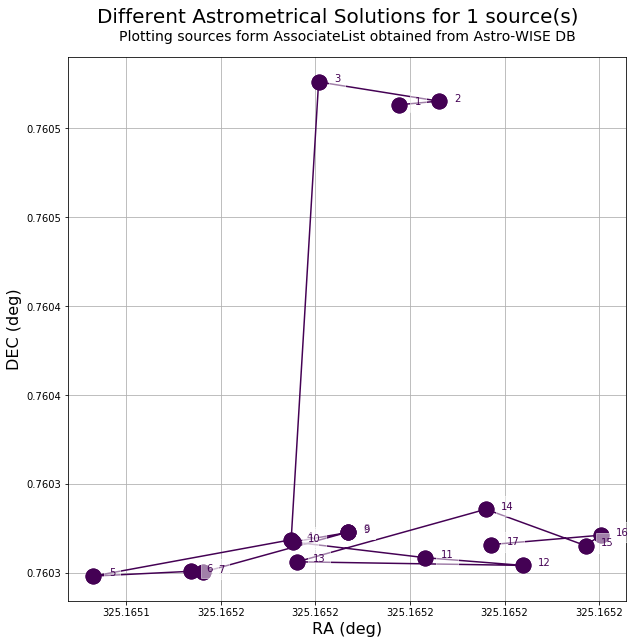

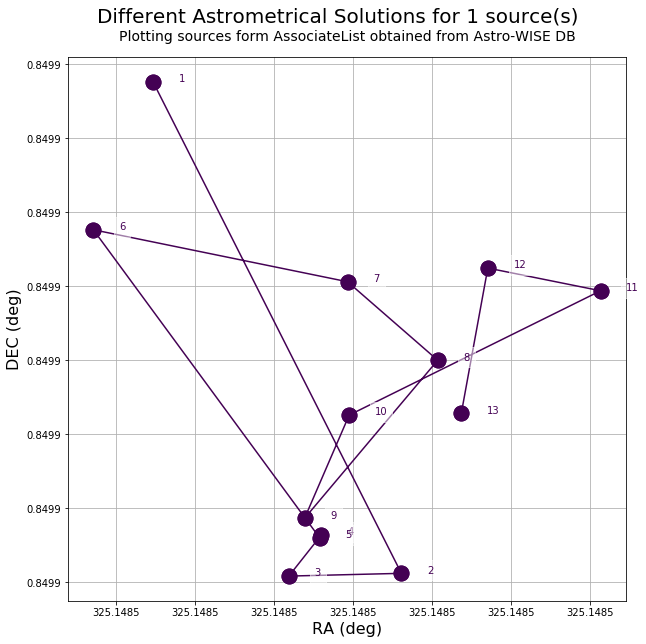

In [43]:
def plot_Association_radec(data=None, nr_sources=1, slid_ids=None, obs_date=None, markersize=3, plot_timeframe='off', select_source='off'):
    if data == None:
        data, slid_ids, obs_date = get_AssociateList_data()
    else: pass
    
    if select_source != 'off':
        plot_data_Assoc = [data[select_source]]
        filename = "./plots/thesis_Astromsolutions{}SourcesSelect[{}].pdf".format(nr_sources,select_source)
    else:
        plot_data_Assoc = data[:nr_sources]
        filename = "./plots/thesis_Astromsolutions{}Sources.pdf".format(nr_sources)

    fig, ax = plt.subplots(figsize=(10,10))

    viridis = plt.get_cmap('viridis')
    cNorm = colors.Normalize(vmin=0, vmax=nr_sources)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=viridis)

    ra_Assoc, dec_Assoc = [], []
    ra_AssocMeans, dec_AssocMeans = [], []
    ra_AssocDevs, dec_AssocDevs = [], []
    ObsTime = []

    for idx_sourceAssoc, sourceAssoc in enumerate(plot_data_Assoc):
        ra_source, dec_source = [], []
        colorVal = scalarMap.to_rgba(idx_sourceAssoc)
        for idx_sourceSingleObs, sourceSingleObs in enumerate(sourceAssoc):
            RA, DEC = sourceSingleObs[2], sourceSingleObs[3]
            ra_source.append(RA); dec_source.append(DEC)
            idx_mask_SLID = slid_ids.index(sourceSingleObs[0])
            ObsTime.append(obs_date[idx_mask_SLID])
        idx_ObsTimeSorted = np.argsort(ObsTime)
        if plot_timeframe != 'off':
            count = np.arange(1,len(idx_ObsTimeSorted)+1)
            ra_sort = np.array(ra_source)[idx_ObsTimeSorted]
            dec_sort = np.array(dec_source)[idx_ObsTimeSorted]
            ax.plot(ra_sort, dec_sort, color=colorVal, marker = '.', linestyle = '-', markersize=markersize)
            [ax.text(ra_sort[i]*1.00000001, dec_sort[i]*1.00000001, count[i], bbox={'color': 'white', 'alpha': 0.5, 'pad': 5}, color=colorVal ) for i in range(len(count))]
        ax.plot(np.array(ra_source)[idx_ObsTimeSorted], np.array(dec_source)[idx_ObsTimeSorted], color=colorVal, marker = '.', linestyle = '', markersize=markersize)
        ra_Assoc.append(ra_source); dec_Assoc.append(dec_source)
        ra_AssocMeans.append(np.mean(ra_source)); dec_AssocMeans.append(np.mean(dec_source))
        ra_AssocDevs.append(np.std(ra_source)); dec_AssocDevs.append(np.std(dec_source))

    fig.suptitle("Different Astrometrical Solutions for {} source(s)".format(nr_sources), fontsize=20, y=.95)
    ax.set_title("Plotting sources form AssociateList obtained from Astro-WISE DB", fontsize=14, y=1.02)
    ax.xaxis.set_label_text("RA (deg)", fontsize=16)
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:3.4f}"))
    ax.yaxis.set_label_text("DEC (deg)", fontsize=16)
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:3.4f}"))

    ax.grid(True)
    plt.savefig(filename, bbox_inches='tight', pad_inches=0)

    plt.show()
    plt.close
    return None

plot_Association_radec(data=data, nr_sources=1, slid_ids=slid_ids, obs_date=obs_date,  markersize=30, plot_timeframe='on', select_source=1)
plot_Association_radec(data=data, nr_sources=1, slid_ids=slid_ids, obs_date=obs_date,  markersize=30, plot_timeframe='on', select_source=90)

<center><i><b>Figure 3:</b>  Two plots to compare members of a single associations in $\texttt{AssociateList.ALID == 2692091)}$. Every dot is a $\texttt{SourceExtraction}$ from a $\texttt{DetectorImage}$. The numbers of the sources represent time in a chronological order from low to high. The differences in  $\texttt{DEC}$ are in the order of $10^{-4}$ degree, where the difference in  $\texttt{RA}$ are in the order of $10^{-5}$ degree</i></center>  

If all astrometrical solutions for every observation were perfect, all dots should have been located at one single place. Looking at Figure [3](#f3), there is no perfect alignment for all sources. However, the deviation is in the range of milliarcseconds (mas). 



<a id = "QT3.1" set up Quality tool></a>
### Analysing the SourceList's in ALID 2697571
#### Improve trend analysis by adding exposures 

As we can see from Figure [2](#f2), all exposures that were matched in the AssociateList `(AssociateList.ALID == 2692091)`, were observed in 2011. This could make our analysis a bit biased. We only have roughly the same conditions of distortions ect. Therefore, we decided to add a couple of exposures that awe spread over a range of 9 years that SA 113 had been observed. This is done in the following way:

1. Query all `RawScienceFrame` objects for SA113
* Produce a `ReducedScienceFrame` object for every `RawScienceFrame`
* Produce an `AstrometricParameters` object for every `ReducedScienceFrame`
* Produce a `SourceList` object for every `ReducedScienceFrame` with corresponding `AstrometricParameters`
* Print OBS_DATE for all SourceLists, and select 12 based on an equal distribution over time

The SourceList objects were created using [this notebook](./thesischapter5a_AWE_SourceListPipeline.pynb). (At this moment without using a Reference Catalogue. This was not known at the time.) <b>The following analysis will be without calibration towards an reference catalogue. Please look at this analysis with the knowlegde that we did not know that.</b> After creating and selecting the new SourceLists, we create an new AssociateList from those. 

This `AssociateList` can be queried by 

``` python
AL = (AssociateList.ALID==2697571)[0]
```

<a id = "f4" LOC></a>

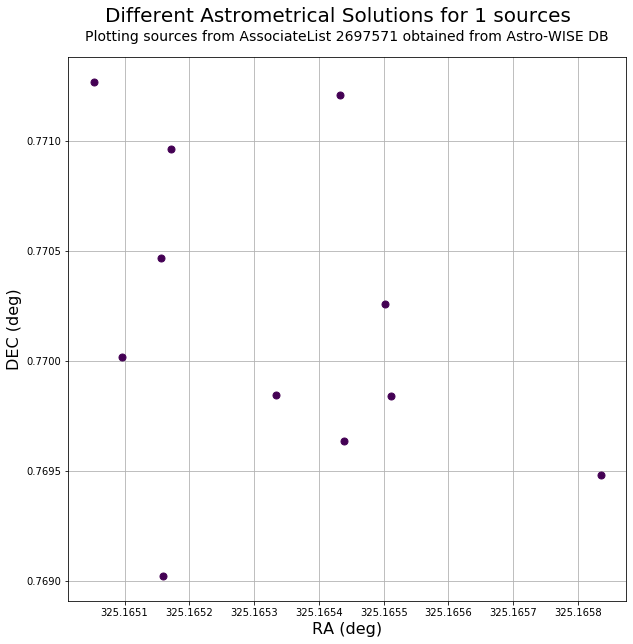

In [11]:
# We wanted to retrieve more data for AssociateLists and therefore added more attirbutes to the returmn statement

def get_AssociateList_data(alid, attrlist = ['SLID', 'SID', 'RA', 'DEC', 'MAG_ISO', 'MAGERR_ISO', 'MAG_APER', 'MAGERR_APER', 'FLUX_APER', 
                                       'FLUXERR_APER', 'FLUX_ISO', 'FLUXERR_ISO', 'FLUX_AUTO', 'FLUXERR_AUTO',  'ERRA_IMAGE', 'ERRX2_IMAGE', 
                                       'ERRY2_IMAGE', 'ERRXY_IMAGE', 'ERRTHETA_IMAGE'] , SA_radec=[325.375,0.499]):
    ''' Obtaining numpy array or list containing associations from MasterList made using SourceLists in the Astro-WISE database

    (1) Selecting AssociateList by ALID, from Astro-WISE Database
    (2) Obtaining requested attributes from AssociateList, as defined by attrlist
    (3) Per source append attributes to data list
    (4) Obtain information for SourceLists in AssociateList
    (5) Obtain information regarding pairs in AssocateList
    (6) Store the data as binary data stream

        Parameters
        ----------
        attrlist : list [Default = ['SLID', 'SID', 'RA', 'DEC', 'MAG_ISO', 'MAGERR_ISO', 'MAG_APER', 'MAGERR_APER', 'FLUX_APER', 
                                    'FLUXERR_APER', 'FLUX_ISO', 'FLUXERR_ISO', 'FLUX_AUTO', 'FLUXERR_AUTO',  'ERRA_IMAGE', 'ERRX2_IMAGE', 
                                    'ERRY2_IMAGE', 'ERRXY_IMAGE', 'ERRTHETA_IMAGE']
            List containing wanted attributes as str 

        alid : int [Default = 2692091]
            AssociateList Identifier number 
            by default: Name of AssociateList: mockupMasterTable200327_17 ---> containing 460 associated sources
        
        SA_radec : list [Default = [325.375,0.499]]
            List containing pointing of SA field in RA and DEC 

        Returns 
        -------
        data : list
            List containing ['AID', attrlist] ordered by Associates from AW-AssociateList
            'AID' contains SLID and SourceList index
        
        slid_ids : list
            List containing SourceList Identifier numbers SLID to quickly check ObservationDate in AssociateList
            
        obs_date : list
            List containing ObservationDates ordered in the same order as the slid_ids list

    > If problems with pickle [due to Python versions], replace by 
    >    np.savez('data/{}_AL{}.data'.format(SAfield, alid), attrlist=attrlist, data=data_float,slid_ids=slid_ids, 
    >              obs_date=obs_date, AID_PAIRS_UNIQUE=AID_PAIRS_UNIQUE, allow_pickle=True)
    
    ------------------------------- User example --------------------------------
    ###### Using get_AssociateList_data() to obtain AssociateList data from AW-AssociateList #######

        data, slid_ids, obs_date = get_AssociateList_data()

    '''
    # (1) Selecting AssociateList by ALID, from Astro-WISE Database
    import pickle
    try:
        AL = (AssociateList.ALID==alid)
    except NameError as err:
        try:
            with open('data/SA113_AL{}.data'.format(alid), 'rb') as filehandle: # open 'SA113_2692091.data' as binary data stream
                 attrlist, data_float, slid_ids, obs_date, AID_PAIRS_UNIQUE, AID_PAIRS, AID_PAIRS_SLID1, AID_PAIRS_SID1, AID_PAIRS_SLID2, AID_PAIRS_SID2, all_AIDINFO  = pickle.load(filehandle)
            return attrlist, data_float, slid_ids, obs_date, AID_PAIRS_UNIQUE, AID_PAIRS, AID_PAIRS_SLID1, AID_PAIRS_SID1, AID_PAIRS_SLID2, AID_PAIRS_SID2, all_AIDINFO 
        except ModuleNotFoundError as err:
            import pickle
            print("ModuleNotFoundError: data file contains data types that can only be opened in the Astro-WISE environment")
    data_float = []
    # (2) Obtaining requested attributes from AssociateList
    al_data_floats = AL[0].associates.get_data(attrlist, mask=None, mode='ANY', count=None, countmode='EQ')
    al_idxs = [key for key in al_data_floats.keys()] # al_idxs are association list indexes from which we obtain attrlist
    al_idxs.sort() # Sort by AssociateList index

    for aid in al_idxs:
        association_float = []
        # (3) Per source append attributes to data list
        for source in al_data_floats[aid]:
            source_nptype = []
            for idx_att, att in enumerate(source):
                if idx_att == 0 or idx_att == 1:
                    source_nptype.append(int(np.array(att).astype(np.float64)))
                else:
                    source_nptype.append(float(np.array(att).astype(np.float64)))
            association_float.append(source_nptype)
        data_float.append(association_float)
        
    # (4) Obtain information for SourceLists in AssociateList   
    slid_ids, obs_date = [], []
    for idx_sl, sl in enumerate(AL[0].sourcelists):
        try:
            obs_date.append(sl.frame.DATE_OBS); slid_ids.append(sl.SLID)
        except AttributeError as err:
            obs_date.append(datetime.datetime(2000, 1, 1)); slid_ids.append(sl.SLID)
    saveObject = (attrlist, data_float, slid_ids, obs_date)  
    
    # (5) Obtain information regarding pairs in AssocateList
    ### AL.get_distances_on_associates()
    # |      get_distances calculates the distances between all possible pairs in an
    # |      association. The output is a dictionary with as key the associate ID
    # |      (AID) and as value a list containing for each pair a tuple which
    # |      consists of three items: ((SLID1, SID1), (SLID2, SID2), DISTANCE).
    # |      SLID1 is always <= SLID2 and when SLID1=SLID2 SID1 < SID2.

    data_distances = AL[0].get_distances_on_associates()
    nr_pairs = len(data_distances)
    r = AL[0].get_distances_on_associates()
    aids = [k for k in r.keys()]
    AID_PAIRS_UNIQUE = [aid for aid in aids]
    AID_PAIRS = [[aid for row in r[aid]] for aid in aids]
    AID_PAIRS_SLID1 = [[row[0][0] for row in r[aid]] for aid in aids]
    AID_PAIRS_SID1 = [[row[0][1] for row in r[aid]] for aid in aids]
    AID_PAIRS_SLID2 = [[row[1][0] for row in r[aid]] for aid in aids]
    AID_PAIRS_SID2 = [[row[1][1] for row in r[aid]] for aid in aids]

    # |      for aid in aids[:10]:
    # |          for row in r[aid]:
    # |              print(aid, row[0][0], row[0][1], row[1][0], row[1][1], row[2])
    # |              print(aid, row)
    
    all_AIDINFO = []
    for aid in aids:
        for row in r[aid]:
            all_AIDINFO.append((aid, row))
#             print(aid, row[0][0], row[0][1], row[1][0], row[1][1], row[2])
#             print(aid, row)

    saveStatsPairs = (AID_PAIRS_UNIQUE, AID_PAIRS, AID_PAIRS_SLID1, AID_PAIRS_SID1, AID_PAIRS_SLID2, AID_PAIRS_SID2, all_AIDINFO)

    saveAll = (attrlist, data_float, slid_ids, obs_date, AID_PAIRS_UNIQUE, AID_PAIRS, AID_PAIRS_SLID1, AID_PAIRS_SID1, AID_PAIRS_SLID2, AID_PAIRS_SID2, all_AIDINFO)
    
    SAfield = 'SA113'
    # (6) Store the data as binary data stream
    with open('data/{}_AL{}.data'.format(SAfield, alid), 'wb') as filehandle:
        pickle.dump(saveAll, filehandle)#, allow_pickle=True)
    print("data/{}_AL{}.data is saved and stored".format(SAfield, alid)) 
    return attrlist, data_float, slid_ids, obs_date, AID_PAIRS_UNIQUE, AID_PAIRS, AID_PAIRS_SLID1, AID_PAIRS_SID1, AID_PAIRS_SLID2, AID_PAIRS_SID2, all_AIDINFO 


# -------------------------------------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------------------------------


def plot_Association_radec(data, alid='AssociateList', nr_sources=1, markersize=3):
    ''' Plotting of associated sources present in the data

    (1) Retrieving requested number of associations from data array

        Parameters
        ----------
        data: numpy.array
            Numpy array or list containing associations from MasterList made using SourceLists in the Astro-WISE database
                
                AL=(AssociateList.ALID==2692091)
                attrlist, data = ['RA', 'DEC'], []
                al_data = AL[0].associates.get_data(attrlist, mask=None, mode='ANY', count=None, countmode='EQ')
                al_idxs = [key for key in al_data.keys()] # al_idxs are association list indexes from which we obtain ['RA', 'DEC']
                al_idxs.sort() 

                for aid in al_idxs:
                    association = []
                    for row in data[aid]:
                        association.append(row)
                    data.append(association)

        nr_sources : int [Default = 10]
            Number of sources that will be plotted from imported data

        markersize : int [Default = 3]
            Markersize of the points indicating locations. 
            Recommended: markersize=5 for 100 sources, markersize=10 for 10 sources and markersize=30 for 1 source.

        Returns
        -------
        ra_Assoc, dec_Assoc [optional]
            List of deviation in sources per iteration giving sigma for our calculation of the surface area
        
        ra_AssocMeans, dec_AssocMeans [optional]
            List of deviation in sources per iteration giving sigma for our calculation of the surface area

        ra_AssocDevs, dec_AssocDevs [optional]
            List of deviation in sources per iteration giving sigma for our calculation of the surface area

        Astromsolutions{nr_sources}Sources.pdf:
            Plot stored as a .pdf file which is stored in the directory "plots"

    ------------------------------- User example --------------------------------
    ###### Using plot_Association_radec() to create plot showing distribution of sources in AW-AssociateList #######

        stats = plot_Association_radec(data, 100, markersize=5)
        ra_Assoc, dec_Assoc, ra_AssocMeans, dec_AssocMeans, ra_AssocDevs, dec_AssocDevs = stats

    '''
    # (1) Retrieving requested number of associations from data array
    if type(nr_sources) != int:
        try: 
            plot_data_Assoc = [data[idx_aid] for idx_aid in nr_sources]
        except TypeError as err:
            print("Attribute: nr_sources, should be either integer value or list containing AIDs")
    else:     
        plot_data_Assoc = data[:nr_sources]
    
    fig, ax = plt.subplots(figsize=(10,10))

    viridis = plt.get_cmap('viridis')
    try: 
        cNorm = colors.Normalize(vmin=0, vmax=nr_sources)
    except TypeError as err:
        nr_sources = len(nr_sources)
        cNorm = colors.Normalize(vmin=0, vmax=nr_sources)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=viridis)

    ra_Assoc, dec_Assoc = [], []
    ra_AssocMeans, dec_AssocMeans = [], []
    ra_AssocDevs, dec_AssocDevs = [], []

    for idx_sourceAssoc, sourceAssoc in enumerate(plot_data_Assoc):
        ra_source, dec_source = [], []
        colorVal = scalarMap.to_rgba(idx_sourceAssoc)
        for idx_sourceSingleObs, sourceSingleObs in enumerate(sourceAssoc):
            RA, DEC = sourceSingleObs[2], sourceSingleObs[3]
            ax.plot(RA, DEC, color=colorVal, marker = '.', markersize=markersize, rasterized=True) 
            ra_source.append(RA); dec_source.append(DEC)
        ra_Assoc.append(ra_source); dec_Assoc.append(dec_source)
        ra_AssocMeans.append(np.mean(ra_source)); dec_AssocMeans.append(np.mean(dec_source))
        ra_AssocDevs.append(np.std(ra_source)); dec_AssocDevs.append(np.std(dec_source))

    fig.suptitle("Different Astrometrical Solutions for {} sources".format(nr_sources), fontsize=20, y=.95)
    ax.set_title("Plotting sources from {} obtained from Astro-WISE DB".format(alid), fontsize=14, y=1.02)
    ax.xaxis.set_label_text("RA (deg)", fontsize=16)
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:3.4f}"))
    ax.yaxis.set_label_text("DEC (deg)", fontsize=16)
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:3.4f}"))

    ax.grid(True)
    filename = "./plots/test_Astromsolutions{}Sources.pdf".format(nr_sources)
    plt.savefig(filename, bbox_inches='tight', pad_inches=0)

    plt.show()
    plt.close
    return ra_Assoc, dec_Assoc, ra_AssocMeans, dec_AssocMeans, ra_AssocDevs, dec_AssocDevs

attrlist, data_float, slid_ids, obs_date, AID_PAIRS_UNIQUE, AID_PAIRS, AID_PAIRS_SLID1, AID_PAIRS_SID1, AID_PAIRS_SLID2, AID_PAIRS_SID2, all_AIDINFO = get_AssociateList_data(alid= 2697571)
plot = plot_Association_radec(data=data_float, alid='AssociateList 2697571', nr_sources=1, markersize=14)

<center><i><b>Figure 4:</b>  Plot revealing the locations for one association from $\texttt{AssociateList.ALID == 2692091)}$  <font color="#440154"> <b>coloured in purple dots </b></font>). This plot reveals the differences in astrometry for the same $\texttt{CelestialObject}$
. </i></center> 

<a id = "f5" LOC></a>

<a id = "f5.4" LOC from bottom of page></a>

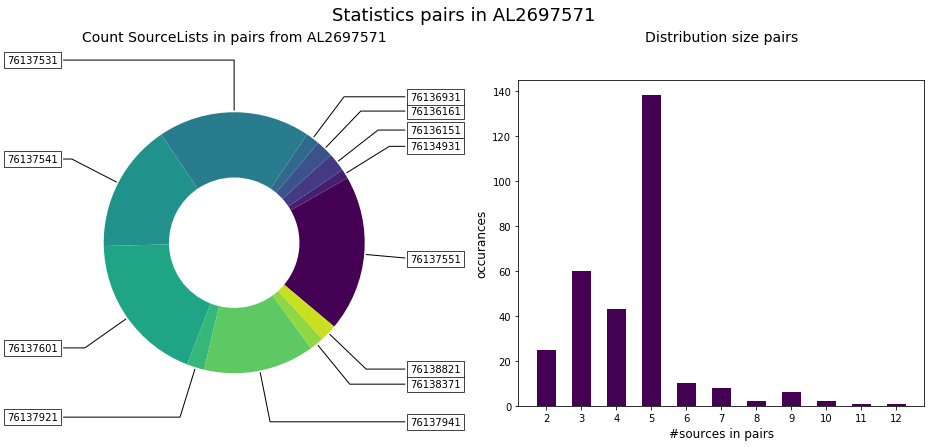

In [7]:
alid = 2697571
attrlist, data_2697571, slid_ids_2697571, obs_date_2697571, AID_PAIRS_UNIQUE_2697571, AID_PAIRS_2697571, AID_PAIRS_SLID1_2697571, AID_PAIRS_SID1_2697571, AID_PAIRS_SLID2_2697571, AID_PAIRS_SID2_2697571, all_AIDINFO_2697571 = get_AssociateList_data(2697571) # <--- Only containing 5 SL
AID_PAIRS, AID_PAIRS_SLID1, AID_PAIRS_SID1, AID_PAIRS_SLID2, AID_PAIRS_SID2 = AID_PAIRS_2697571, AID_PAIRS_SLID1_2697571, AID_PAIRS_SID1_2697571, AID_PAIRS_SLID2_2697571, AID_PAIRS_SID2_2697571

fig, (ax1, ax2) = plt.subplots(figsize=(16, 6), ncols=2, nrows=1, subplot_kw=dict(aspect="equal"))
fig.suptitle("Statistics pairs in AL{}".format(alid), fontsize=18, y=1.05)
freq=[]
for i in AID_PAIRS_SLID1:
    for j in i:
        freq.append(j)
for i in AID_PAIRS_SLID2:
    for j in i:
        freq.append(j)

ingredients = slid_ids_2697571

quantities = [freq.count(slid) for slid in slid_ids_2697571]

viridis = plt.get_cmap('viridis')
cNorm = colors.Normalize(vmin=0, vmax=len(np.unique(ingredients)))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=viridis)
c = [scalarMap.to_rgba(idx) for idx in range(len(np.unique(ingredients)))]

ax = ax1
ax.set_title("Count SourceLists in pairs from AL{}".format(alid), fontsize=14, y=1.1)
wedges, texts = ax.pie(quantities, colors=c, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(ingredients[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

    
ax = ax2
ax.set_title("Distribution size pairs", fontsize=14, y=1.1)

slids_in_assoc, nr_slids_in_assoc = [], []

for idx_association, association in enumerate(AID_PAIRS):
    slids_unique_perAssoc = np.unique(AID_PAIRS_SLID2[idx_association]+AID_PAIRS_SLID1[idx_association]) # find SLIDs SLIDS for every assocation
    slids_in_assoc.append(slids_unique_perAssoc) # SLIDs present in every association
    nr_slids_in_assoc.append(len(slids_unique_perAssoc)) # number of SLIDs == #sources present in every association
nr_slids_in_assoc_unique = np.unique(nr_slids_in_assoc)
occ_nr_slids_in_assoc = [nr_slids_in_assoc.count(nr_slids) for nr_slids in nr_slids_in_assoc_unique]

ax.bar(nr_slids_in_assoc_unique,occ_nr_slids_in_assoc, color=purple, width=max(nr_slids_in_assoc_unique)/(2.0*len(nr_slids_in_assoc_unique)))
ax.set_aspect('auto', 'datalim')
ax.xaxis.set_label_text("#sources in pairs", fontsize=12)
x_formatter = FixedFormatter([str(nr_slids) for nr_slids in nr_slids_in_assoc_unique])
x_locator = FixedLocator(nr_slids_in_assoc_unique)
ax.xaxis.set_major_locator(x_locator)
ax.yaxis.set_label_text("occurances", fontsize=12)

plt.show()


<center><i><b>Figure 5:</b>  Two plots showing statistics of $\texttt{AssociateList.ALID == 2692091)}$ On the left you find a pie diagram showing the occurances of SLID's in the associations. The masterlist, $\texttt{(SourceList.SLID == 76137551)}$, is <font color="#440154"> <b>coloured in purple</b></font>). On the right you find a bar diagram revealing the statistics on how many members the associations have. </i></center> 

From the bar plot in Figure [5](#f5) we can tell that most associations, with each a unique AID, consists of 5 members. The pie plot confirms this statement as we clearly see 5 wedges that roughly have the same size. We can not directly draw conclusions from wedges having the same size. However, as all these 5 wedges show the same size as the $\texttt{MasterSourceList}$ $\texttt{(SourceList.SLID == 76137551)}$, we can state that for all celestial source there was a match with a source extraction from 76137531, 76137541, 76137601, 76137941. These $\texttt{SourceList}$'s will be referred to as being 'good matched'. 

Looking at the pie diagram again, we see clearly that the other 7 $\texttt{SourceList}$'s are less frequently present in the associations. From this we conclude that some $\texttt{SourceList}$'s are not the right match for our masterlist. To analyse and grade the 'quality' of these lists we try to identify that makes the difference between the 'good matched' and the 'badly matched' $\texttt{SourceList}$'s. 



#### Analysing the 'badly matched'  $\texttt{SourceList}$'s. 
Let's start with analysing some of the 'rotte appels', as we say in Dutch. If we find sources on different values for RA and Dec for $\texttt{SourceList}$'s that 'should' (according to the stored observation information) look to the same patch of the sky, somewhere in the data processing pipeline, or even before that, something went wrong. Possible explanations could be that
* the pointing of the telescope is off by degrees, and you completely observe an other area in the sky
* there is something wrong with the data itself, e.g. astrometric solution, small pointing issues, telescope offset, low signal-to-noise

Before being published in the Astro-WISE database, data product undergo quality checks. Therefore, normally we would not consider the data to be wrong. For now, we will treat and analyse the data as if we do not know. This is where the real functionallity and imporance of data lineage lies. Recall the diagram:

```
                                                              MasterFlatFrame
$\texttt{SourceList}$ ----> AstrometricParameters/astrom_params ----> ReducedScienceFrame ---->   ColdPixelMap  ----> RawScienceFrame 
                                                                HotPixelMap
                                                                 BiasFrame
```

The mismatch could either happen in the stage where `RawScienceFrame`, `ReducedScienceFrame`, and `AstrometricParameters` objects are created. 
Let's start with analysing some of the 'rotte appels'. One explaination for the mismatch between the different $\texttt{SourceList}$'s is that we might not look at the same patch of the sky. Al least we know for sure, that somewhere in the data processing pipeline, or even in the raw data, something caused the mismatch. Possible explanations could be that:
* the pointing of the telescope is off by degrees, and you completely observe an other area in the sky
* there is something wrong with the data itself, e.g. astrometric solution, small pointing issues, telescope offset, low signal-to-noise



<a id = "QT2.3" set up Quality tool></a>
### Analysing the RawScienceFrame's in ALID 2697571
We can measure the quality of the RawScienceFrame in the following ways:
1. Checking the statistics on the raw pixel values, e.g. mean, median pixel values. The values should be similar for similar observation fields. If not, there might be an issue with the background. Note: in Astro-WISE, the background is subtracted when creating a RegriddedFrame, which is even after the production of ReducedScienceFrame's. 
2. Counting the number of sources in the $\texttt{SourceList}$
3. Simple overlay of plotting Sources


#### 1) RawScienceFrame pixel statistics

There are two AssociationList's to analyse. AL2697121 and AL2697571 consisting of 5 and 12 SourceList's respectively. Since from our previous analysis became clear that in the case of AL2697121 all SourceList's appear to be of even high importance, we will look at AL2697571. The analysis shows that specifically for SLIDs [76138371, 76136151, 76136161, 76136931, 76134931, 76137921, 76138821] less than 75% of the sources were matched with the MasterList. 


In [37]:
SL_76138371=(SourceList.SLID==76138371)
SLID_IN_AL_2697571_bad = [76138371, 76136151, 76136161, 76136931, 76134931, 76137921, 76138821]
SLID_IN_AL_2697571_good = []
MasterList_2697571_SLID = 76137551

for sl in AL_2697571[0].sourcelists:
    if sl.SLID == MasterList_2697571_SLID:
        print("Masterlist: ", "\nSL"+str(sl.SLID), "     median ="+str(sl.frame.raw.imstat.median), "     min ="+str(sl.frame.raw.imstat.min), "     max ="+str(sl.frame.raw.imstat.max) )
        print("-------------------------------------------------------------------------\n'Bad matching' SourceList:")
    elif sl.SLID in SLID_IN_AL_2697571_bad:
        print("SL"+str(sl.SLID), "     median ="+str(sl.frame.raw.imstat.median), "     min ="+str(sl.frame.raw.imstat.min), "     max ="+str(sl.frame.raw.imstat.max))
    else: 
        SLID_IN_AL_2697571_good.append(sl.SLID)
print("-------------------------------------------------------------------------\n'Good matching' SourceList:")
output = [(print("SL"+str(slid), "     median ="+str((SourceList.SLID==slid)[0].frame.raw.imstat.median), "     min ="+str((SourceList.SLID==slid)[0].frame.raw.imstat.min), "     max ="+str((SourceList.SLID==slid)[0].frame.raw.imstat.max))) for slid in SLID_IN_AL_2697571_good]
        
print("\n\n\n\nOutput of awe> AL_2697571[0].sourcelists[0].frame.raw.imstat.info() \n--------------------------------------------------\n")
# AL_2697571[0].sourcelists[0].frame.raw.raw_fits_data.info()
AL_2697571[0].sourcelists[0].frame.raw.imstat.info()

Masterlist:  
SL76137551      median =370.0      min =285.0      max =65535.0
-------------------------------------------------------------------------
Bad SourceLists:
SL76134931      median =399.0      min =274.0      max =65535.0
SL76136151      median =379.0      min =277.0      max =65535.0
SL76136161      median =400.0      min =276.0      max =65535.0
SL76136931      median =487.0      min =287.0      max =65535.0
SL76137921      median =411.0      min =290.0      max =65535.0
SL76138371      median =430.0      min =280.0      max =65535.0
SL76138821      median =405.0      min =277.0      max =65535.0
-------------------------------------------------------------------------
Good SourceLists:
SL76137531      median =389.0      min =279.0      max =65535.0
SL76137541      median =388.0      min =282.0      max =65535.0
SL76137601      median =407.0      min =286.0      max =65535.0
SL76137941      median =886.0      min =283.0      max =65535.0




Output of awe> AL_2697571[0].so

Above we show the the median, minimum and maximum pixel values obtained from the RawSienceFrames being the basis of the SL's. 
There are no straightforward correlations to be found looking at the differences between the SL's that we marked as good and bad quality. What does stand out are the values for SL76137941. Compared to all the others the values for the median are twice as high. 
``` bash
SL76137941      median =886.0      min =283.0      max =65535.0
```
To check what is causing this difference, we look at the exposure time to check whether the change is caused either a deeper observation (longer exposure time), or the use of an other filter. 

In [38]:
SL_76138371=(SourceList.SLID==76137941)
print("The RawScienceFrame from SL{} has an exposure time of {} seconds, which is what we expect from observations of SA113. Like all other SL's the sources have been observed in the {} filter. However, remarkable is the name of the RawScienceFrame: {}".format(SL_76138371[0].SLID, SL_76138371[0].frame.EXPTIME, SL_76138371[0].frame.filter.name, SL_76138371[0].frame.raw.observing_block.name))
print("The name of the MasterList is {}".format((SourceList.SLID==76137551)[0].frame.raw.observing_block.name))
print("\nBut, after checking all the observing block names, we see the difference in observations:")

print("\nThe ObservingBlock names for the 'bad quality SL's are:")
for i in SLID_IN_AL_2697571_bad:
    print("--->   SL{}:  {}".format(i, (SourceList.SLID==i)[0].frame.raw.observing_block.name))
print("\nwhile the ObservingBlock names for the 'good quality SL's are:")
for i in SLID_IN_AL_2697571_good:
    print("--->   SL{}:  {}".format(i, (SourceList.SLID==i)[0].frame.raw.observing_block.name))  

The RawScienceFrame from SL76137941 has an exposure time of 75.0 seconds, which is what we expect from observations of SA113. Like all other SL's the sources have been observed in the OCAM_r_SDSS filter. However, remarkable is the name of the RawScienceFrame: High_airmass_OMEGACAM_Landolt_SA113_Master_Key
The name of the MasterList is High_airmass_OMEGACAM_Landolt_SA113_Master_Key

But, after checking all the observing block names, we see the difference in observations:

The ObservingBlock names for the 'bad quality SL's are:
--->   SL76138371:  OMEGACAM_Landolt_SA113_Master_Key
--->   SL76136151:  OMEGACAM_Landolt_SA113_Master_Key
--->   SL76136161:  OMEGACAM_Landolt_SA113_Master_Key
--->   SL76136931:  OMEGACAM_Landolt_SA113_Master_Key
--->   SL76134931:  OMEGACAM_Landolt_SA113_Master_Key
--->   SL76137921:  High_airmass_OMEGACAM_Landolt_SA113_Master_Key
--->   SL76138821:  OMEGACAM_Landolt_SA113_Master_Key

while the ObservingBlock names for the 'good quality SL's are:
--->   SL7613


The RawScienceFrame from SL76137941 has an exposure time of 75.0 seconds, which is what we expect from observations of SA113. Like all other SL's the sources have been observed in the OCAM_r_SDSS filter. However, remarkable is the name of the RawScienceFrame: High_airmass_OMEGACAM_Landolt_SA113_Master_Key
The name of the MasterList is High_airmass_OMEGACAM_Landolt_SA113_Master_Key

But, after checking all the observing block names, we see the difference in observations:
``` bash
The ObservingBlock names for the 'bad quality SL's are:
--->   SL76138371:  OMEGACAM_Landolt_SA113_Master_Key
--->   SL76136151:  OMEGACAM_Landolt_SA113_Master_Key
--->   SL76136161:  OMEGACAM_Landolt_SA113_Master_Key
--->   SL76136931:  OMEGACAM_Landolt_SA113_Master_Key
--->   SL76134931:  OMEGACAM_Landolt_SA113_Master_Key
--->   SL76137921:  High_airmass_OMEGACAM_Landolt_SA113_Master_Key
--->   SL76138821:  OMEGACAM_Landolt_SA113_Master_Key

while the ObservingBlock names for the 'good quality SL's are:
--->   SL76137531:  High_airmass_OMEGACAM_Landolt_SA113_Master_Key
--->   SL76137541:  High_airmass_OMEGACAM_Landolt_SA113_Master_Key
--->   SL76137601:  High_airmass_OMEGACAM_Landolt_SA113_Master_Key
--->   SL76137941:  High_airmass_OMEGACAM_Landolt_SA113_Master_Key

```

So it appears we are looking to regular and to high airmass observations.

#### 2) Counting number of sources in RawScienceFrame
An additional check is to look at the number of extracted sources for every `SourceList` and to see whether there is a clear difference between the 'bad' and 'good' matched `SourceList`'s. For example, it could be the case that the bad matches occur because they have less extracted sources than the masterlist.

In [39]:
AL_2697571=(AssociateList.ALID==2697571)

MasterList_2697571 = AL_2697571[0].sourcelists[0]
MasterList_2697571_SLID = MasterList_2697571.SLID
SLID_IN_AL_2697571 = [sl.SLID for sl in AL_2697571[0].sourcelists]

SLID_IN_AL_2697571_bad = [76138371, 76136151, 76136161, 76136931, 76134931, 76137921, 76138821]

obtain_SL_data = 'no'

if obtain_SL_data == 'yes':
    idx_SLWMULDER_2697571 = []
    for slid in SLID_IN_AL_2697571:
        try:
            data_float, slid_id, obs_date, attrlist = get_SourceList_data(slid)
            idx_SLWMULDER_2697571.append(slid)
        except:
            None

SL_76138371=(SourceList.SLID==76138371)
SLID_IN_AL_2697571_bad = [76138371, 76136151, 76136161, 76136931, 76134931, 76137921, 76138821]
SLID_IN_AL_2697571_good = []

for sl in AL_2697571[0].sourcelists:
    if sl.SLID == MasterList_2697571_SLID:
        print("Masterlist: ", "SL"+str(sl.SLID), "     number_of_sources ="+str(sl.number_of_sources))
        print('-------------------------------------------------------------------------\nBad SourceLists:')
    elif sl.SLID in SLID_IN_AL_2697571_bad:
        print("SL"+str(sl.SLID), "     number_of_sources ="+str(sl.number_of_sources))
    else: 
        SLID_IN_AL_2697571_good.append(sl.SLID)
print('-------------------------------------------------------------------------\nGood SourceLists:')
output = [(print("SL"+str(slid), "     number_of_sources ="+str((SourceList.SLID==slid)[0].number_of_sources))) for slid in SLID_IN_AL_2697571_good]

Masterlist:  SL76137551      number_of_sources =311
-------------------------------------------------------------------------
Bad SourceLists:
SL76134931      number_of_sources =278
SL76136151      number_of_sources =297
SL76136161      number_of_sources =310
SL76136931      number_of_sources =298
SL76137921      number_of_sources =303
SL76138371      number_of_sources =288
SL76138821      number_of_sources =307
-------------------------------------------------------------------------
Good SourceLists:
SL76137531      number_of_sources =282
SL76137541      number_of_sources =215
SL76137601      number_of_sources =308
SL76137941      number_of_sources =183


The number of source extractions per `SourceList` are quiet similar comparing the bad and the good matches. Therefore, we can not draw conclusions from only looking at the number of sources per exposure.

To see what happens we can look at Figure [6](#f6), showing the two matching scenarios.

<a id = "f6" LOC></a>

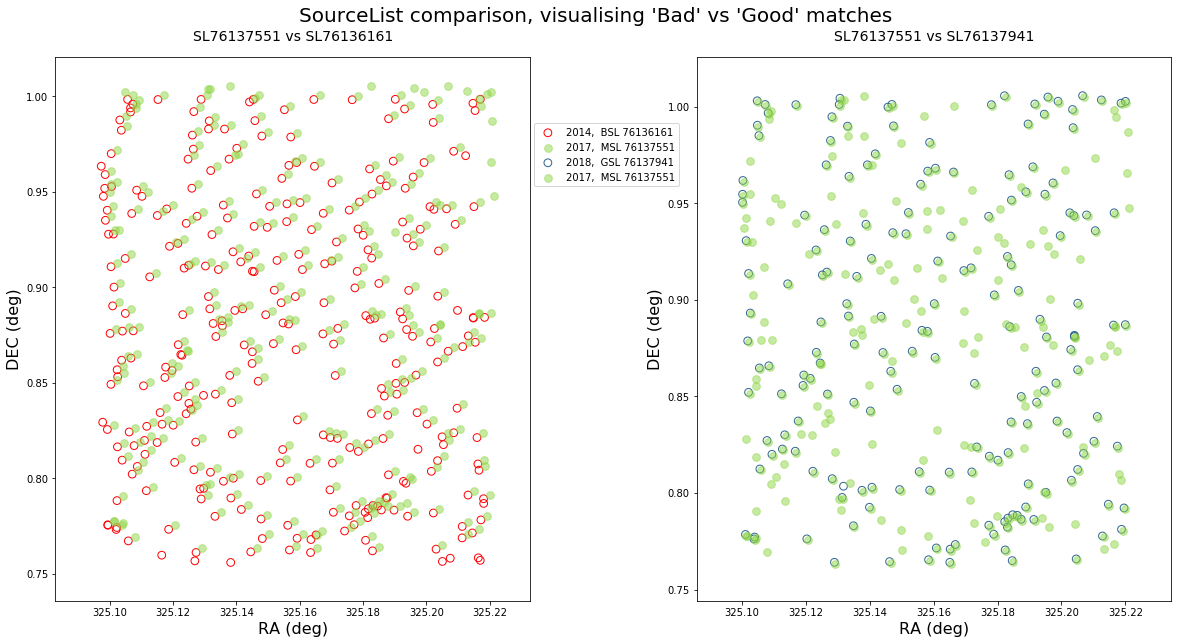

In [44]:
# Code we need to obtain data from SourceList objects. 

def intitialize_PandasTable_from_SL_checkbyeye(SLID, save='off', printing='off'):
    data, slid_id, obs_date, attrlist = get_SourceList_data(slid=SLID)
    df_raw = pd.DataFrame({'SLID': pd.Series([], dtype='int'), 'SID': pd.Series([], dtype='int'), 'RA': pd.Series([], dtype='float'), 'DEC': pd.Series([], dtype='float'), 'Xpos': pd.Series([], dtype='float'), 'Ypos': pd.Series([], dtype='float'), 'MAG_ISO': pd.Series([], dtype='float'), 'FLUX_APER': pd.Series([], dtype='float'), 'FLUXERR_APER': pd.Series([], dtype='float'),  'S2N': pd.Series([], dtype='float'), 'ERRX2_IMAGE': pd.Series([], dtype='float'), 'ERRY2_IMAGE': pd.Series([], dtype='float'), 'ERRXY_IMAGE': pd.Series([], dtype='float')  })
    df_stats = pd.DataFrame({'SLID': pd.Series([], dtype='int'), 'RA_MEAN': pd.Series([], dtype='float'), 'RA_RES': pd.Series([], dtype='float'), 'DEC_MEAN': pd.Series([], dtype='float'), 'DEC_RES': pd.Series([], dtype='float'), 'MAG_MEAN': pd.Series([], dtype='float'), 'FLUX_MEAN': pd.Series([], dtype='float'),  'FLUXERR_MEAN': pd.Series([], dtype='float'), 'S2N_MEAN': pd.Series([], dtype='float') })
    idx_ra = attrlist.index("RA")
    idx_dec =  attrlist.index("DEC")
    idx_xpos = attrlist.index("Xpos")
    idx_ypos =  attrlist.index("Ypos")
    idx_mag = attrlist.index("MAG_ISO")
    idx_flux = attrlist.index("FLUX_APER")
    idx_fluxerr, idx_errx2, idx_erry2, idx_errxy = attrlist.index("FLUXERR_APER"), attrlist.index("ERRX2_IMAGE"), attrlist.index("ERRY2_IMAGE"), attrlist.index("ERRXY_IMAGE")
    nr_sources = len(data)
    # Obtaining information/statistics per attribute
    RA = [data[i][idx_ra] for i in range(nr_sources)]
    DEC = [data[i][idx_dec] for i in range(nr_sources)] 
    XPOS = [data[i][idx_xpos] for i in range(nr_sources)]
    YPOS = [data[i][idx_ypos] for i in range(nr_sources)]
    ISO = [data[i][idx_mag] for i in range(nr_sources)]
    FLUX = [data[i][idx_flux] for i in range(nr_sources)]
    FLUXERR = [data[i][idx_fluxerr] for i in range(nr_sources)]
    ERRX2 = [data[i][idx_errx2] for i in range(nr_sources)]
    ERRY2 = [data[i][idx_erry2] for i in range(nr_sources)]
    ERRXY = [data[i][idx_errxy] for i in range(nr_sources)]
    RA_MEAN, DEC_MEAN, ISO_MEAN = np.mean(RA), np.mean(DEC), np.mean(ISO),
    FLUX_ISOMEAN, FLUXERR_ISOMEAN, S2N_MEAN = np.mean(FLUX), np.mean(FLUXERR), (np.mean(FLUX)/np.mean(FLUXERR))
    RA_RES, DEC_RES = [], []
    for idx_source in range(nr_sources):
        # Obtaining information/statistics per source in single associates
        sid = idx_source
        ra = RA[idx_source]
        dec = DEC[idx_source]
        xpos = XPOS[idx_source]
        ypos = YPOS[idx_source]
        mag_iso = ISO[idx_source]
        flux_aper = FLUX[idx_source]
        fluxerr_aper = FLUXERR[idx_source]
        s2n = FLUX[idx_source]/FLUXERR[idx_source]
        errx2 = ERRX2[idx_source]
        erry2 = ERRY2[idx_source]
        errxy = ERRXY[idx_source]
        row_raw = [{'SLID': SLID, 'SID': sid,'RA': ra, 'DEC': dec, 'Xpos': xpos, 'Ypos': ypos, 'MAG_ISO': mag_iso, 'FLUX_APER': flux_aper, 'FLUXERR_APER': fluxerr_aper, 'S2N': s2n, 'ERRX2_IMAGE': errx2, 'ERRY2_IMAGE': erry2, 'ERRXY_IMAGE': errxy }]
        df_raw = df_raw.append(row_raw, ignore_index=False, sort=False)
        RA_RES.append(ra - RA_MEAN) ; DEC_RES.append(dec - DEC_MEAN)
        if printing != 'off':
            print("{}/{}".format(idx_source + 1, nr_sources), end='\r')
    sl_stats = [{'SLID': SLID, 'RA_MEAN': np.mean(RA_MEAN), 'RA_RES': np.mean(RA_RES),  'DEC_MEAN': DEC_MEAN, 'DEC_RES': np.mean(DEC_RES), 'MAG_MEAN': ISO_MEAN, 'FLUX_MEAN': FLUX_ISOMEAN,  'FLUXERR_MEAN': FLUXERR_ISOMEAN, 'S2N_MEAN': S2N_MEAN }]
    df_stats = df_stats.append(sl_stats, ignore_index=False, sort=False)
    
    if save == 'on':
        if printing != 'off':
            print("PandasTable from Sourcelist SLID={} has been created".format(SLID))
        df_raw.to_csv('data/sl{}raw.csv'.format(SLID))
        df_stats.to_csv('data/sl{}stats.csv'.format(SLID))
        if printing != 'off':
            print("Tables stored as data/sl{}raw.csv, and data/sl{}stats.csv".format(SLID, SLID))
    else:
        pass
    return df_stats, df_raw, obs_date


# BAD AND GOOD SL MATCHING TESTING

MasterSL = 76137551
BadSL = 76136161
GoodSL = 76137941 #76137601

data_floatMSL, slid_idMSL, obs_dateMSL, attrlist = get_SourceList_data(slid=MasterSL)

df_statsMasterSL, df_rawMasterSL, obs_dateMSL = intitialize_PandasTable_from_SL_checkbyeye(SLID=MasterSL)
df_statsBadSL, df_rawBadSL, obs_dateBSL = intitialize_PandasTable_from_SL_checkbyeye(SLID=BadSL)
df_statsGoodSL, df_rawGoodSL, obs_dateGSL = intitialize_PandasTable_from_SL_checkbyeye(SLID=GoodSL)

fig, (ax1, ax2) = plt.subplots(figsize=(20, 10), ncols=2, nrows=1)

ax1.set_title(r"SL{} vs SL{}".format(MasterSL , BadSL, ), fontsize=14, y=1.02)
ax1.scatter(df_rawBadSL['RA'], df_rawBadSL['DEC'],  marker='o', facecolors='none', edgecolors=cum_red, alpha= 1, s= 60, label="{},  BSL {}".format(obs_dateBSL.strftime('%Y'), BadSL))
ax1.scatter(df_rawMasterSL['RA'], df_rawMasterSL['DEC'], color = yellow_green, alpha = 0.50, s=  60, label="{},  MSL {}".format(obs_dateMSL.strftime('%Y'), MasterSL))
ax1.xaxis.set_label_text(r"RA (deg)", fontsize=16)
ax1.yaxis.set_label_text(r"DEC (deg)", fontsize=16)

ax2.set_title(r"SL{} vs SL{}".format(MasterSL , GoodSL, ), fontsize=14, y=1.02)
ax2.scatter(df_rawGoodSL['RA'], df_rawGoodSL['DEC'],  marker='o', facecolors='none', edgecolors=blue, alpha= 1, s= 60, label="{},  GSL {}".format(obs_dateGSL.strftime('%Y'), GoodSL))
ax2.scatter(df_rawMasterSL['RA'], df_rawMasterSL['DEC'], color = yellow_green, alpha = 0.50, s=  60, label="{},  MSL {}".format(obs_dateMSL.strftime('%Y'), MasterSL))
ax2.xaxis.set_label_text(r"RA (deg)", fontsize=16)
ax2.yaxis.set_label_text(r"DEC (deg)", fontsize=16)

# Plotting grid, adding title, show plot and save it
fig.suptitle(r"SourceList comparison, visualising 'Bad' vs 'Good' matches", fontsize=20, y=0.95)
fig.subplots_adjust(wspace=0.35)
filename = "./plots/thesis_comparison_MSL{}_BSL{}GSL{}_strangepizelcount.pdf".format(MasterSL , BadSL, GoodSL)

fig.legend(loc='best', bbox_to_anchor=(-0.025, 0.23, 0.5, 0.5))
plt.savefig(filename, bbox_inches='tight', pad_inches=0, loc='best', bbox_to_anchor=(0.1, 0., 0.5, 0.5))
plt.show()
plt.close()


<center><i><b>Figure 6:</b>  Two plots showing the difference between two SourceList objects with our masterlist. On the left the masterlist (SourceList.SLID == 76137551), is coloured in <font color="#8ed645"> <b>green dots</b></font>) and a 'bad' matching novicelist (SourceList.SLID == 76137551) is overplotted in <font color="#FD0306"> <b>red circles</b></font>). On the right side we see the same masterlist but with a 'good' matching novicelist overplotted in <font color="#440154"> <b>purple circles</b></font>) </i></center> 

On the left hand side of Figure [6](#f6) we find the celestial sources from our masterlist in <font color="#8ed645"> <b>green</b></font> and the source extractions from `(SourceList.SLID == 76137551)` overplotted in <font color="#FD0306"> <b>red</b></font>. Apart from some exceptions at the boarders, we do find a source for every celestial object. However, the sources all seem to be shifted with a distance of about $\sim$7 arcseconds. In the right plot we clearly see that there are less sources in the exposure (<font color="#440154"> <b>purple circles</b></font>), but but at least they overlap with one of the celestial sources. 

***

<b>The conclusion from Figure [6](#f6) is, that the reason why we have bad matching exposures is not because of difference int he number of sources found, but is 'just' a linear shift in the extractions themselves. We found out that the SourceLists only take into account the Linear tranfromations, and are not yet calibrated towards an external reference catalogue. In the next Section we will investigate the differences between:

*  Instrumental astrometric solutions
*  Calibrated astrometric solutions with USNO-B1.0 as reference catalogue

We use the same 12 Detector images that were also now qualified as 'good' and 'bad'. Now we know these are not 'good' and 'bad'. The 'good' astrometry was based on the fact that the instrument showed the same distortions. </b>

<a id = "green2" LOC></a>

<div class="alert alert-block alert-success">
<b>NOTE:</b> The information will now continue with the information presented in the Master Thesis.
</div>

[ <font color="#35b779"> Jump back to first green block </font>](#green1)

<br><br>

[Go back to list of contents](#LOC)

<a id = "5.3.1" LOC></a>
***
# Comparing Instrumental and Calibrated $\texttt{AstrometricSolutions }$

We select 12 $\texttt{DetectorImages}$ that represent a proper distribution of exposures of SA 113 over the timespan of 2011 - 2018. 
We already obtained SourceLists that were produces by all $\texttt{DetectorImages}$ without a reference catalogue. These we call the <b> Instrumental Astrometric Solutions </b>. 
We calibrate all $\texttt{DetectorImages}$ again using [this notebook](./thesischapter5a_AWE_SourceListPipeline.pynb), but now using the USNO-B1.0 reference catalogie. This provides us with another set of new SourceLists that we refer to as <b> Calibrated Astrometric Solutions </b>. 
<br><br>
From these SourceLists we create two AssociateList. (i) One that is associating the Sourcelists with <b> Instrumental Astrometric Solutions </b> against the USNO-B1.0 catlogue (also provided as a SourceList!), and (ii) the other that uses the <b> Calibrated Astrometric Solutions </b>. 

In [ ]:
qredsfall_SA113=(ReducedScienceFrame.raw.chip.name=='ESO_CCD_#90') & (ReducedScienceFrame.raw.astrom.CRVAL1<ra_SA113+dra_SA113) & (ReducedScienceFrame.raw.astrom.CRVAL1>ra_SA113-dra_SA113) & (ReducedScienceFrame.raw.astrom.CRVAL2<dec_SA113+ddec_SA113) & (ReducedScienceFrame.raw.astrom.CRVAL2>dec_SA113-ddec_SA113)
qredsf_SA113= qrawsfall_SA113 & (ReducedScienceFrame.raw.OBJECT=='STD,ZEROPOINT') & (ReducedScienceFrame.raw.filter.name=='OCAM_r_SDSS') & (ReducedScienceFrame.raw.EXPTIME==75.0) 
n_qredsfall_pub_SA113=len(qredsfall_SA113)
n_qredsf_pub_SA113=len(qredsf_SA113)

print("From all {} public ReducedScienceFrame's, we select {} based on our criteria".format(n_qredsfall_pub_SA113, n_qredsf_pub_SA113))

In [ ]:
##### INSTRUMENTAL Astrometric Solutions 
##### against USNO-B1.0 represented by (SourceList.SLID == 565361)[0]

run = 'no'

masterlist = (SourceList.SLID == 565361)[0]
novicelistSLIDS = [76138371, 76138821, 76134931, 76136161, 76136151, 76136931, 76137531, 76137601, 76137541, 76137551, 76137921, 76137941]
novicelists = [(SourceList.SLID == slid)[0] for slid in novicelistSLIDS]
nr_sourcelists = len(novicelists)

if run == 'yes':
    import datetime
    today = datetime.date.today().strftime("%y%m%d")
    AL0_name = 'MasterAssocation_CH4_instrumental{}_{}_0'.format(nr_sourcelists, today)
    print("Name AssociateList: {}".format(AL0_name))

    sourcelists=novicelists

    AL0 = AssociateList()
    AL0.input_lists.append(masterlist)
    AL0.input_lists.append(novicelists[0])
    AL0.set_search_distance(5.0)
    AL0.associatelisttype = 2
    AL0.process_params.SEXTRACTOR_FLAG_MASK = 255
    AL0.name = AL0_name
    AL0.make()
    AL0.commit()

    AL_previous = AL0
    i=0
    for sl in novicelists[1:]:
        i = i+1
        AL_name = 'MasterAssocation_CH4_instrumental{}_{}_{}'.format(nr_sourcelists, today, i)
        print("Creating: {}".format(AL_name))

        AL=AssociateList()
        AL.input_lists.append(AL_previous)
        AL.input_lists.append(sl)
        AL.set_search_distance(5.0)
        AL.associatelisttype = 2
        AL.process_params.SEXTRACTOR_FLAG_MASK = 255
        AL.name = AL_name
        AL.make()
        AL.commit()
        AL_previous = AL

#  Created Master AssociateList with ALID = 2710241, name = "MasterAssocation_CH4_instrumental12_200811_11" and 902 associates!


In [ ]:
##### INSTRUMENTAL Astrometric Solutions 
##### against USNO-B1.0 represented by (SourceList.SLID == 565361)[0]

run = 'no'

masterlist = (SourceList.SLID == 565361)[0]
novicelistSLIDS = [76154181, 76154971, 76154981, 76154991, 76155001, 76155011, 76155021, 76155031, 76155041, 76155051, 76155061, 76155071]
novicelists = [(SourceList.SLID == slid)[0] for slid in novicelistSLIDS]
nr_sourcelists = len(novicelists)

if run == 'yes':
    import datetime
    today = datetime.date.today().strftime("%y%m%d")
    AL0_name = 'MasterAssocation_CH4_calibration{}_{}_0'.format(nr_sourcelists, today)
    print("Name AssociateList: {}".format(AL0_name))

    sourcelists=novicelists

    AL0 = AssociateList()
    AL0.input_lists.append(masterlist)
    AL0.input_lists.append(novicelists[0])
    AL0.set_search_distance(5.0)
    AL0.associatelisttype = 2
    AL0.process_params.SEXTRACTOR_FLAG_MASK = 255
    AL0.name = AL0_name
    AL0.make()
    AL0.commit()

    AL_previous = AL0
    i=0
    for sl in novicelists[1:]:
        i = i+1
        AL_name = 'MasterAssocation_CH4_calibration{}_{}_{}'.format(nr_sourcelists, today, i)
        print("Creating: {}".format(AL_name))

        AL=AssociateList()
        AL.input_lists.append(AL_previous)
        AL.input_lists.append(sl)
        AL.set_search_distance(5.0)
        AL.associatelisttype = 2
        AL.process_params.SEXTRACTOR_FLAG_MASK = 255
        AL.name = AL_name
        AL.make()
        AL.commit()
        AL_previous = AL

#  Created Master AssociateList with ALID = 2710361, name = "MasterAssocation_CH4_calibration12_200811_11" and 851 associates!


<br><br>

[Go back to list of contents](#LOC)

<a id = "5.4" LOC></a>
***
# Criteria to Define the Quality of Associations
***




<a id = “fthesis” LOC></a>

Usage of the quality tool.. This tool was made to produce the Figures 5.4, 5.5 and 5.6 from the thesis. 

* Make sure you have the SA113_AL2710361.data, and SA113_AL2710241.data in the data folder. 
* Download the notebook locally. [unfortunately the webinterface does not show the interactive plotting tool]
* Run the Kernel on top of this notebook to load packages!
* Run the Kernel below

There will the three taps appearing

1. Distibution associations:
    * The dropdown menu with AL let you choose either the Instumental of Calibrated astrometrical solutions. SELECT ONE of the two in the dropdown
    * Press the `Load AL data` button
    * The dropdown menu with Pairs allows you to choose how many associations you want to see. PAIRS, will show all associations [best option if you ask me]
    * Markersize can help for people with bad eyes, as the plots are quiet small
    * Press `Plot` and wait
* Timespan source:
    * The dropdown menu with AL let you choose either the Instumental of Calibrated astrometrical solutions. SELECT ONE of the two in the dropdown
    * Press the `Load AL data` button
    * The select source allows you to choose which association you want to see
    * Markersize can help for people with bad eyes, as the plots are quiet small
    * Press `Plot` and wait
* Timespan source:
    * The dropdown menu with AL let you choose either the Instumental of Calibrated astrometrical solutions. SELECT ONE of the two in the dropdown
    * Press the `Load AL data` button
    * The select PAIR allows an extra option to see how many associations have that amount of pairs within the association. This figure will appear on the bottom left side. It is a difficult plot. Take e.g. 10. The plot reveals the associations that have 10 pairs. The colors show the SourceLists that have a contribution to that association. 
    * Press `Plot` and wait


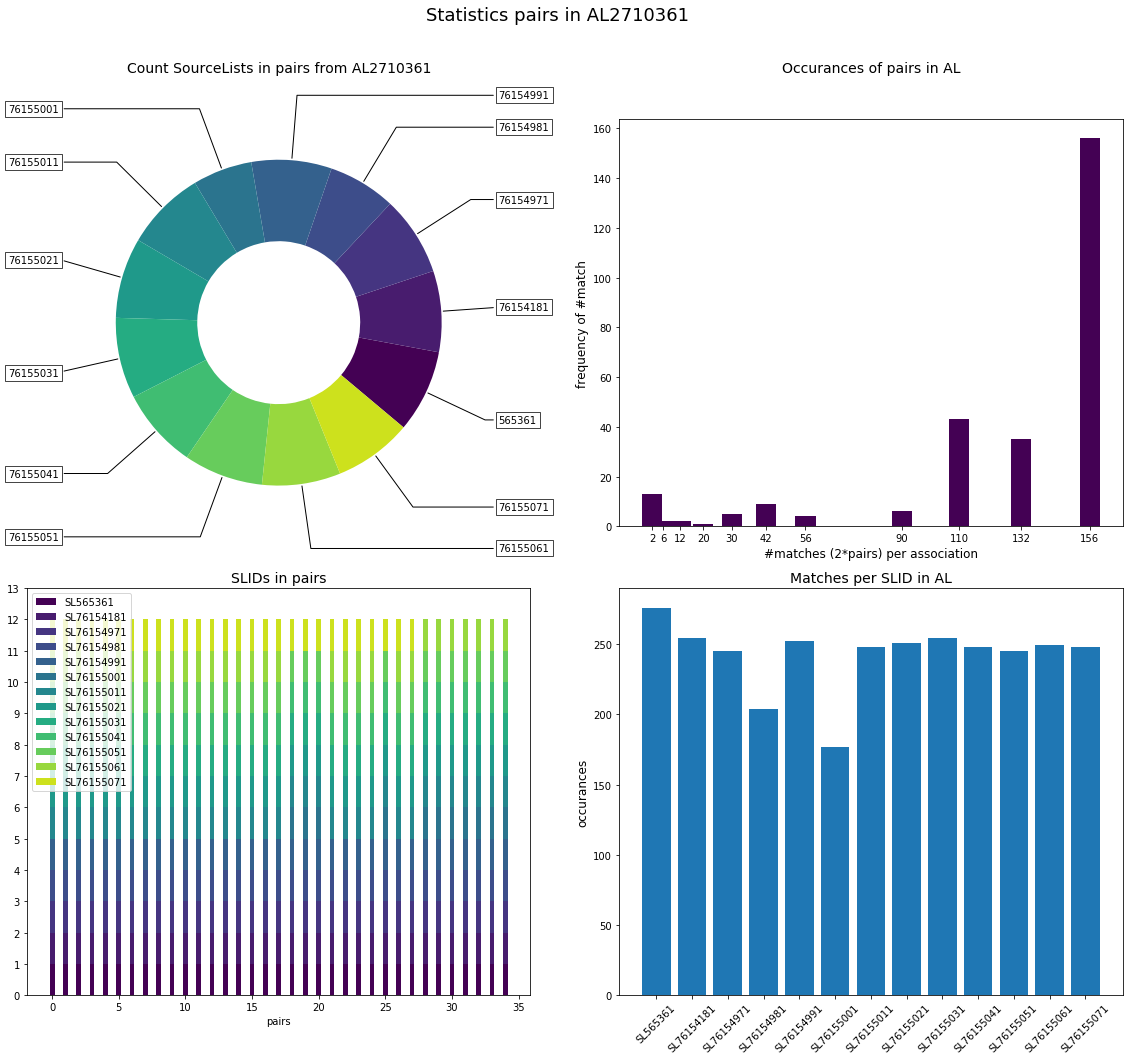

In [15]:
from IPython.display import clear_output
from ipywidgets import HBox, VBox
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import cufflinks as cf
from collections import OrderedDict

selectAL_dropdown = widgets.Dropdown(
    options= {'Instrumental Astrometrical Solutions': 2710241, 'USNO-B1.0 Astrometrical Solutions': 2710361},
    value= 2710241,
    description='AL:',
    disabled=False,
)
selectAL_dropdown

nrSources_dropdown = widgets.Dropdown(
    options= ['1', '10', '100', 'PAIRS', 'ALL'],
    value= 'PAIRS',
    description='Source(s):',
    disabled=False,
)
nrSources_dropdown

grid_button = widgets.ToggleButton(
    value=True,
    description='Grid',
    icon='check'
)
grid_button

markersize_slider = widgets.IntSlider(
    value=5,
    min=1,
    max=20,
    step=1,
    description='Markersize:',
    readout_format='d',
)
markersize_slider

loaddata_button = widgets.Button(
    description='Load AL data',
)
loaddata_button

# ------------------------------------------
# plot_Associations_radec_interactive(plot=None)
# ------------------------------------------

plotdist_button = widgets.Button(
    description='Plot',
)
plotdist_button

# ------------------------------------------
# def plot_Singlessociations_radec_interactive(plot=None)
# ------------------------------------------

plotsingle_button = widgets.Button(
    description='Plot',
)
plotsingle_button

markersize_single_slider = widgets.IntSlider(
    value=25,
    min=20,
    max=40,
    step=1,
    description='Markersize:',
    readout_format='d',
)
markersize_single_slider

selectsource_slider = widgets.IntSlider(
    value=1,
    min=1,
    max=200,
    step=1,
    description='Select source:',
    readout_format='d',
)
selectsource_slider

# ------------------------------------------
# ------------------------------------------

plotdonut_button = widgets.Button(
    description='Plot',
)
plotdonut_button

pair_dropdown = widgets.Dropdown(
    options= ['1', '3', '6', '10', '15', '21', '28', '36', '45', '55', '66'],
    value= '10',
    description='PAIR:',
    disabled=False,
)
pair_dropdown




# ----- if code works, add to check existance data:
# try:
#    myVar
# except NameError:
#    # Do something.


def load_AL(load=None):  #2697571
    alid = selectAL_dropdown.value
    with open('./data/SA113_AL{}.data'.format(alid), 'rb') as filehandle: # open 'SA113_2692091.data' as binary data stream
        attrlist, data, slid_ids, obs_date, AID_PAIRS_UNIQUE, AID_PAIRS, AID_PAIRS_SLID1, AID_PAIRS_SID1, AID_PAIRS_SLID2, AID_PAIRS_SID2, all_AIDDATA = pickle.load(filehandle)
    
    df_pairs = pd.DataFrame({'AID_PAIR': pd.Series([], dtype='int'),
                        'AID_PAIRS_SLID1': pd.Series([], dtype='int'),
                        'AID_PAIRS_SID1': pd.Series([], dtype='int'),
                        'AID_PAIRS_SLID2': pd.Series([], dtype='int'),
                        'AID_PAIRS_SID2': pd.Series([], dtype='int') })

    for idx_aidpairs, aidpairs in enumerate(AID_PAIRS):
        for idx_aidpair, aidpair in enumerate(aidpairs):
            aid = AID_PAIRS[idx_aidpairs][idx_aidpair]
            aslid1 = AID_PAIRS_SLID1[idx_aidpairs][idx_aidpair]
            asid1 = AID_PAIRS_SID1[idx_aidpairs][idx_aidpair]
            aslid2 = AID_PAIRS_SLID2[idx_aidpairs][idx_aidpair]
            asid2 = AID_PAIRS_SID2[idx_aidpairs][idx_aidpair]

            row_stats = [{'AID_PAIR': aid, 'AID_PAIRS_SLID1': aslid1, 'AID_PAIRS_SID1': asid1, 'AID_PAIRS_SLID2': aslid2, 'AID_PAIRS_SID2': asid2 }]
            df_pairs = df_pairs.append(row_stats, ignore_index=False, sort=False)
    print("Data from AL{}.data loaded, \nYou can now start plotting for AL{}".format(alid, alid))
    return attrlist, data, slid_ids, obs_date, df_pairs

def plot_Association_radec_interactive(plot=None):
    alid = selectAL_dropdown.value
    clear_output()
    display(tab)
    alid = selectAL_dropdown.value
    nr_sources = nrSources_dropdown.value
    mark_size = markersize_slider.value
    grid = grid_button.value
    
    # (1) Retrieving requested number of associations from data array
    if nr_sources == 'PAIRS':
        unique_aid_pairs= df_pairs['AID_PAIR'].unique() # getting unique AID_PAIRS 
        plot_data_Assoc = [data[idx_aid] for idx_aid in unique_aid_pairs]
        nr_sources = len(unique_aid_pairs)
    
    elif nr_sources == '1' or nr_sources == '10' or nr_sources == '100': 
        plot_data_Assoc = data[:int(nr_sources)]
    
    fig, ax = plt.subplots(figsize=(10,10))

    viridis = plt.get_cmap('viridis')
    try: 
        cNorm = colors.Normalize(vmin=0, vmax=nr_sources)
    except TypeError as err:
        nr_sources = len(nr_sources)
        cNorm = colors.Normalize(vmin=0, vmax=nr_sources)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=viridis)

    ra_Assoc, dec_Assoc = [], []
    ra_AssocMeans, dec_AssocMeans = [], []
    ra_AssocDevs, dec_AssocDevs = [], []
    idx_ra = attrlist.index("RA")
    idx_dec =  attrlist.index("DEC")
    
    for idx_sourceAssoc, sourceAssoc in enumerate(plot_data_Assoc):
        ra_source, dec_source = [], []
        colorVal = scalarMap.to_rgba(idx_sourceAssoc)
        for idx_sourceSingleObs, sourceSingleObs in enumerate(sourceAssoc):
            RA, DEC = sourceSingleObs[idx_ra], sourceSingleObs[idx_dec] 
            ax.plot(RA, DEC, color=colorVal, marker = '.', markersize=mark_size, rasterized=True) 
            ra_source.append(RA); dec_source.append(DEC)
        ra_Assoc.append(ra_source); dec_Assoc.append(dec_source)
        ra_AssocMeans.append(np.mean(ra_source)); dec_AssocMeans.append(np.mean(dec_source))
        ra_AssocDevs.append(np.std(ra_source)); dec_AssocDevs.append(np.std(dec_source))

    fig.suptitle("Different Astrometrical Solutions for {} associations".format(nr_sources), fontsize=20, y=.95)
    ax.set_title("Plotting associations from AL{} obtained from AstroWISE".format(alid), fontsize=14, y=1.02)
    ax.xaxis.set_label_text("RA (deg)", fontsize=16)
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:3.2f}"))
    ax.yaxis.set_label_text("DEC (deg)", fontsize=16)
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:3.2f}"))

    ax.grid(grid)
    return plt.show()
  
# ------------------------------------------
# ------------------------------------------


def plot_Singlessociations_radec_interactive(plot=None):
    clear_output()
    display(tab)
    alid = selectAL_dropdown.value
    select_source = int(selectsource_slider.value)
    mark_size = markersize_single_slider.value
    grid = grid_button.value
    
    unique_aid_pairs= df_pairs['AID_PAIR'].unique() # getting unique AID_PAIRS 
    aid_select_source = unique_aid_pairs[select_source]
    plot_data_Assoc = [data[aid_select_source]] # Select source only from pairs
    nr_sources = 1

    fig, ax = plt.subplots(figsize=(10,10))

    viridis = plt.get_cmap('viridis')
    if nr_sources == 1:
        obs_date_sort = np.array(obs_date)[np.argsort(obs_date)]
        slid_ids_sort = np.array(slid_ids)[np.argsort(obs_date)]
        cNorm = colors.Normalize(vmin=0, vmax=len(obs_date_sort))
    else:
        cNorm = colors.Normalize(vmin=0, vmax=nr_sources)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=viridis)

    ObsTime = []
    slid_sorted = []

    for idx_sourceAssoc, sourceAssoc in enumerate(plot_data_Assoc):
        ra_source, dec_source = [], []
        colorVal = scalarMap.to_rgba(idx_sourceAssoc)
        for idx_sourceSingleObs, sourceSingleObs in enumerate(sourceAssoc):
            RA, DEC = sourceSingleObs[2], sourceSingleObs[3]
            ra_source.append(RA); dec_source.append(DEC)
            idx_mask_SLID = slid_ids.index(sourceSingleObs[0])
            ObsTime.append(obs_date[idx_mask_SLID])
            slid_sorted.append(sourceSingleObs[0])
        idx_ObsTimeSorted = np.argsort(ObsTime)
        
        count = np.arange(1,len(idx_ObsTimeSorted)+1)
        ra_sort = np.array(ra_source)[idx_ObsTimeSorted]
        dec_sort = np.array(dec_source)[idx_ObsTimeSorted]
        time_sort = np.array(ObsTime)[idx_ObsTimeSorted]
        ax.plot(ra_sort, dec_sort, color='k', marker = '', linestyle = '-') 
        for o in range(len(count)):
            idx_color = np.where(obs_date_sort == time_sort[o])
            colorVal = scalarMap.to_rgba(idx_color[0][0])
            ax.plot(ra_sort[o], dec_sort[o], color=colorVal, marker = '.', linestyle = '-', markersize=mark_size, label="{},  SL{}".format(time_sort[o].strftime('%Y'), slid_sorted[o]))
            ax.text(ra_sort[o]+.00000005, dec_sort[o]*1.00000005, count[o], color=colorVal)

    fig.suptitle("Different Astrometrical Solutions for {} source".format(nr_sources), fontsize=20, y=.95)
    ax.set_title("Plotting source AID={} from AL{}".format(aid_select_source, alid), fontsize=14, y=1.02)
    ax.xaxis.set_label_text("RA (deg)", fontsize=16)
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:3.3f}"))
    ax.yaxis.set_label_text("DEC (deg)", fontsize=16)
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:3.3f}"))

    ax.grid(grid)
    ax.legend()

    return plt.show()


# ------------------------------------------
# ------------------------------------------

    
def plot_statistics_interactive(plot=None):
    clear_output()
    display(tab)
    alid = selectAL_dropdown.value
    pairsize = int(pair_dropdown.value)
        
    fig, axes = plt.subplots(figsize=(16, 14), ncols=2, nrows=2, subplot_kw=dict(aspect="equal"))
    (ax1, ax2, ax3, ax4) = axes.flatten()
    fig.suptitle("Statistics pairs in AL{}".format(alid), fontsize=18, y=1.05)
    
    pairs = [df_pairs['AID_PAIRS_SLID2'][(df_pairs['AID_PAIRS_SLID1'] == slid)] for slid in slid_ids]
    matches = [df_pairs['AID_PAIRS_SLID2'][(df_pairs['AID_PAIRS_SLID1'] == slid) |  (df_pairs['AID_PAIRS_SLID2'] == slid) ] for slid in slid_ids]

    ingredients = slid_ids # the ingredients of the AL are the SL present in the pairings
    quantities = [len(pair) for pair in pairs] # the quantities give a quick measure of the quantities added to the recipe

    viridis = plt.get_cmap('viridis')
    cNorm = colors.Normalize(vmin=0, vmax=len(np.unique(ingredients))) # create a color for each ingredient to distinguish them 
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=viridis)
    c = [scalarMap.to_rgba(idx) for idx in range(len(np.unique(ingredients)))]

    ax = ax1 # plotting of the first figure: a pie-chart of the full overview of the recipe ingredients
    ax.set_title("Count SourceLists in pairs from AL{}".format(alid), fontsize=14, y=1.1)
    wedges, texts = ax.pie(quantities, colors=c, wedgeprops=dict(width=0.5), startangle=-40)

    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
              bbox=bbox_props, zorder=0, va="center")

    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(ingredients[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                    horizontalalignment=horizontalalignment, **kw)
        
    ax = ax2 # plotting of the second figure: a barplot showing the occurances of the size of pairs/associations
    ax.set_title("Occurances of pairs in AL", fontsize=14, y=1.1)
    
    unique_aid_pairs= df_pairs['AID_PAIR'].unique() # getting unique AID_PAIRS 
    count_matches_unique_aid_pairs = [len(df_pairs[df_pairs['AID_PAIR'] == unique_aid]) for unique_aid in unique_aid_pairs] # counting how many matches were present in these association
    unique_slids_unique_aid_pairs = [(df_pairs['AID_PAIRS_SLID1'][df_pairs['AID_PAIR'] == unique_aid]).unique() for unique_aid in unique_aid_pairs] # findingthe unique slids present per association
    
    nr_of_matches = np.unique(count_matches_unique_aid_pairs) # getting unique matching numbers [meaning how many matches we find in an association]
    occ_count_matches_unique_aid = [count_matches_unique_aid_pairs.count(match) for match in nr_of_matches] # counting occurances of the number of matches that we find

    ax.bar(nr_of_matches,occ_count_matches_unique_aid, color=purple, width=max(nr_of_matches)/(2.0*len(nr_of_matches)))
    ax.set_aspect('auto', 'datalim')
    ax.xaxis.set_label_text("#matches (2*pairs) per association", fontsize=12)
    x_formatter = FixedFormatter([str(nr_slids) for nr_slids in nr_of_matches])
    x_locator = FixedLocator(nr_of_matches)
    ax.xaxis.set_major_locator(x_locator)
    ax.yaxis.set_label_text("frequency of #match", fontsize=12)
    ax.set_aspect('auto', 'datalim')
    

    ax = ax3 # plotting of the third figure: a barplot showing the ingredients per pairing
    ax.set_title("SLIDs in pairs", fontsize=14)
    
    #try: <--- end of plotting ax4 # pairsize is given as interactive input parameter, since paring numbers depend on the input AL, we check values by TRY
    idx_pairsize_in_nr_slids_in_assoc = np.where(np.array(count_matches_unique_aid_pairs)/2 == pairsize)[0] # pairsize is given as interactive input parameter
    pair_list = list(map(unique_slids_unique_aid_pairs.__getitem__, idx_pairsize_in_nr_slids_in_assoc))

    ingr_pairings = [] 
    for idx_ingr, ingr in enumerate(ingredients):
        ingr_per_pairing = []
        for pair in pair_list:
            presence = list(pair).count(ingr) # presence is either 1 or 0
            ingr_per_pairing.append(presence)
        ingr_pairings.append(ingr_per_pairing)

    ind = np.arange(len(ingredients)) # the x locations for the groups
    width = 0.35
    
    bottom_bar = np.zeros(len(ingr_per_pairing))
    for ind_ingr, ingr in enumerate(ingr_pairings):
        ind = np.arange(len(ingr)) 
        ax.bar(ind, ingr, width, color=c[ind_ingr], bottom=bottom_bar)
        bottom_bar = [bottom_bar[b]+ingr[b] for b in range(len(ingr))]

    ax.set_xlabel('pairs')
    
#     ax.set_ylim(top=len(ingr_pairings)+1)
    ax.set_yticks(np.arange(0, len(ingredients)+1, len(ingredients)/len(ingredients)))
    try:
        ax.legend(labels=["SL"+str(i) for i in ingredients])
    except IndexError as err:
        print("IndexError: not plotting data since for AL{}, you can only select PAIRS: {}".format(alid, [str(int(pair)) for pair in nr_of_matches/2]))
    ax.set_aspect('auto', 'datalim')         
        
    ax = ax4 # plotting of the second figure: a barplot showing the occurances of the size of pairs/associations
    ax.set_title("Matches per SLID in AL", fontsize=14)
       
    idx_quantities_sorted = np.argsort(quantities)
    q_sort = np.array(quantities)[idx_quantities_sorted]
    i_sort = np.array(ingredients)[idx_quantities_sorted]
    
    select_matches_for_slid = [df_pairs['AID_PAIR'][(df_pairs['AID_PAIRS_SLID1'] == slid)] for slid in slid_ids]
    count_presence_slid_in_aids = [len( s.unique()) for  s in select_matches_for_slid]

    for s in select_matches_for_slid:
        occurances_slid_per_aid = [len(s[s == i]) for i in s.unique()] 
        aids_occurances_slid_per_aid = s.unique()
    
    
    ax.bar(range(len(slid_ids)), [len(s.unique()) for  s in select_matches_for_slid])#, labels= ["SL"+str(slid) for slid in slid_ids])
    ax.set_aspect('auto', 'datalim')
    labels = ["SL"+str(slid) for slid in slid_ids]
    x = np.arange(len(labels))
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    plt.xticks(rotation=45)
    ax.yaxis.set_label_text("occurances", fontsize=12)
    ax.set_aspect('auto', 'datalim')      
    
    plt.tight_layout()
    return plt.show()

@plotdist_button.on_click
def plot_on_click(plot):
    plot_Association_radec_interactive()

@plotsingle_button.on_click
def plot_on_click(plot):
    plot_Singlessociations_radec_interactive()    

@plotdonut_button.on_click
def plot_on_click(plot):
    plot_statistics_interactive()
    
@loaddata_button.on_click
def load_on_click(load):
    global attrlist, data, slid_ids, obs_date, df_pairs
    alid = selectAL_dropdown.value
    attrlist, data, slid_ids, obs_date, df_pairs = load_AL()


tab1 = VBox(children=[HBox(children=[selectAL_dropdown,
                                     loaddata_button,
                                     nrSources_dropdown,
                                     ]),
                      HBox(children=[markersize_slider,
                                     grid_button,
                                     plotdist_button,
                                     ]),
                    ])
tab2 = VBox(children=[HBox(children=[selectAL_dropdown,
                                     loaddata_button,
                                     ]),
                      HBox(children=[selectsource_slider,
                                     plotsingle_button,
                                     ]),
                      HBox(children=[markersize_single_slider,
                                     ]),
                    ])

tab3 = VBox(children=[selectAL_dropdown,
                      loaddata_button,
                      pair_dropdown,
                      plotdonut_button,
                    ])
tab = widgets.Tab(children=[tab1, tab2, tab3])
tab.set_title(0, "Distribution assoc's")
tab.set_title(1, "Timespan source")
tab.set_title(2, "SL's presence in AL")
VBox(children=[tab])



<center><i><b>Figure 7:</b> Four plots showing 'quality' of <b>Internal and Calibrated Astrometrical Solutions</b>. The plot profided by the notebook self shows the quality of the <b> Calibrated Solutions</b>. On the top left you find a pie diagram showing the occurances of SLID's in the associations. The reference catalogue, USNO-B1.0 $\texttt{(SourceList.SLID == 565361)}$, is <font color="#440154"> <b>coloured in purple</b></font>). On the right you find a bar diagram revealing the statistics on how many members each associations has. The bottom right zooms in on the associations that contain 12 of the 13 $\texttt{DetectorImage}s$ per association. It reveals how common each $\texttt{DetectorImage}$ is in an association with 12 pairs. The bottom right shows a bar diagram revealing the number of $\texttt{SourceExtraction}$ from each $\texttt{DetectorImage}$ that are matched with the USNO-B1.0 catalogue. The USNO-B1.0 catalogue is the highest bar. This is because USNO-B1.0 has the most sources in this field. </i></center> 